In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward_user, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.2 0.9]
 [0.5 0.9]
 [0.  0.3]
 [0.2 0.1]
 [0.  0.3]
 [0.8 0.5]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.0, 0.1, 0.3, 0.3] -1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([0], maxlen=1024)
deque([-1], maxlen=1024)
deque([[0.0, 0.1, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[ 0.04233556 -0.01055862  0.03403879  0.03276874]], shape=(1, 4), dtype=float32)


  0%|                                                                             | 109/100000 [00:01<24:30, 67.92it/s]

Updated Weights
Mean Reward = -3.2099009900990088
10


  0%|▏                                                                            | 212/100000 [00:02<24:42, 67.32it/s]

Updated Weights
Mean Reward = -3.669999999999998
11


  0%|▏                                                                            | 306/100000 [00:04<31:54, 52.07it/s]

Updated Weights
Mean Reward = -2.030999999999999
23


  0%|▎                                                                            | 409/100000 [00:06<27:22, 60.63it/s]

Updated Weights
Mean Reward = -1.8999999999999992
16


  0%|▍                                                                            | 496/100000 [00:07<30:01, 55.23it/s]

Updated Weights
Mean Reward = -1.020999999999999
24


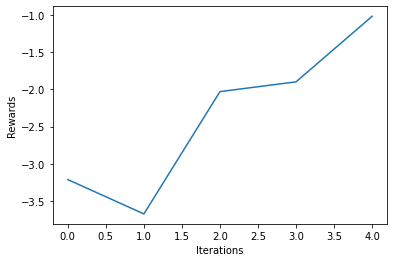

  1%|▍                                                                            | 607/100000 [00:10<35:36, 46.52it/s]

Updated Weights
Mean Reward = -0.9169999999999989
17


  1%|▌                                                                            | 707/100000 [00:12<32:41, 50.63it/s]

Updated Weights
Mean Reward = 1.4770000000000012
34


  1%|▌                                                                            | 806/100000 [00:14<39:55, 41.41it/s]

Updated Weights
Mean Reward = -1.3099999999999992
22


  1%|▋                                                                            | 910/100000 [00:17<35:24, 46.63it/s]

Updated Weights
Mean Reward = 0.9890000000000011
29


  1%|▊                                                                           | 1000/100000 [00:19<42:23, 38.92it/s]

Updated Weights
Mean Reward = -2.0019999999999984
21


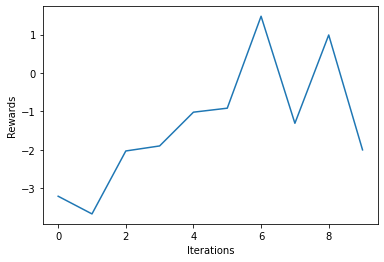

  1%|▊                                                                           | 1107/100000 [00:22<41:32, 39.67it/s]

Updated Weights
Mean Reward = 3.2320000000000007
41


  1%|▉                                                                           | 1205/100000 [00:24<43:30, 37.84it/s]

Updated Weights
Mean Reward = 2.504000000000001
35


  1%|▉                                                                           | 1306/100000 [00:27<49:41, 33.10it/s]

Updated Weights
Mean Reward = 3.446
42


  1%|█                                                                           | 1404/100000 [00:30<53:38, 30.63it/s]

Updated Weights
Mean Reward = -1.1369999999999991
32


  1%|█▏                                                                          | 1497/100000 [00:33<52:34, 31.22it/s]

Updated Weights
Mean Reward = -1.5519999999999987
27


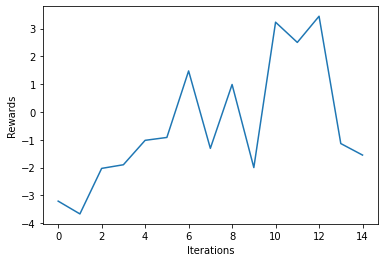

  2%|█▏                                                                          | 1607/100000 [00:37<45:08, 36.33it/s]

Updated Weights
Mean Reward = 3.684000000000001
38


  2%|█▎                                                                          | 1704/100000 [00:40<43:52, 37.34it/s]

Updated Weights
Mean Reward = 1.616000000000001
35


  2%|█▎                                                                          | 1807/100000 [00:43<52:22, 31.25it/s]

Updated Weights
Mean Reward = 3.05
41


  2%|█▍                                                                          | 1902/100000 [00:46<49:55, 32.75it/s]

Updated Weights
Mean Reward = 3.1920000000000006
39


  2%|█▌                                                                          | 1998/100000 [00:48<49:21, 33.09it/s]

Updated Weights
Mean Reward = 4.003000000000002
42


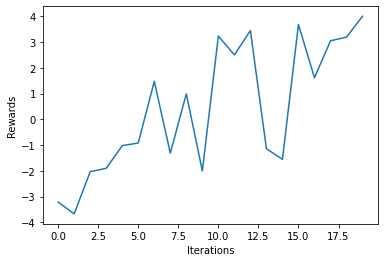

  2%|█▌                                                                          | 2104/100000 [00:52<48:46, 33.45it/s]

Updated Weights
Mean Reward = 2.3000000000000016
26


  2%|█▋                                                                          | 2206/100000 [00:55<51:48, 31.46it/s]

Updated Weights
Mean Reward = 1.7750000000000017
34


  2%|█▋                                                                          | 2302/100000 [00:58<52:25, 31.06it/s]

Updated Weights
Mean Reward = 4.590000000000002
32


  2%|█▊                                                                          | 2406/100000 [01:01<54:11, 30.01it/s]

Updated Weights
Mean Reward = 1.6460000000000006
24


  2%|█▉                                                                          | 2496/100000 [01:04<58:33, 27.75it/s]

Updated Weights
Mean Reward = -0.4969999999999991
18


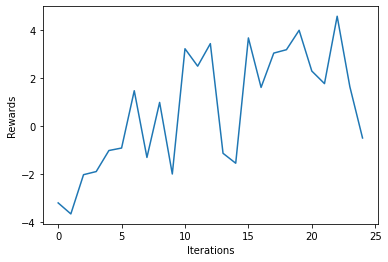

  3%|█▉                                                                        | 2603/100000 [01:08<1:00:25, 26.87it/s]

Updated Weights
Mean Reward = 1.070000000000001
12


  3%|██                                                                          | 2704/100000 [01:12<46:50, 34.62it/s]

Updated Weights
Mean Reward = 0.5170000000000012
24


  3%|██▏                                                                         | 2804/100000 [01:15<57:15, 28.29it/s]

Updated Weights
Mean Reward = 2.044000000000001
26


  3%|██▏                                                                         | 2906/100000 [01:19<58:57, 27.45it/s]

Updated Weights
Mean Reward = 1.7280000000000009
21


  3%|██▎                                                                         | 2999/100000 [01:22<56:15, 28.74it/s]

Updated Weights
Mean Reward = 1.7210000000000008
20


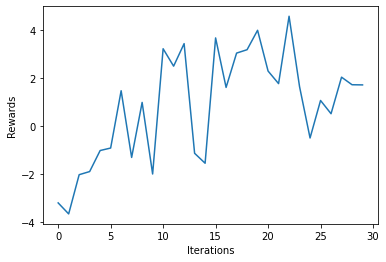

  3%|██▎                                                                       | 3103/100000 [01:26<1:04:15, 25.13it/s]

Updated Weights
Mean Reward = 0.2920000000000013
20


  3%|██▎                                                                       | 3203/100000 [01:30<1:04:43, 24.92it/s]

Updated Weights
Mean Reward = -1.0929999999999993
11


  3%|██▍                                                                       | 3303/100000 [01:33<1:01:40, 26.13it/s]

Updated Weights
Mean Reward = 2.5520000000000014
25


  3%|██▌                                                                         | 3403/100000 [01:37<59:54, 26.87it/s]

Updated Weights
Mean Reward = 1.4710000000000016
23


  4%|██▌                                                                       | 3500/100000 [01:40<1:05:06, 24.70it/s]

Updated Weights
Mean Reward = 1.6440000000000012
12


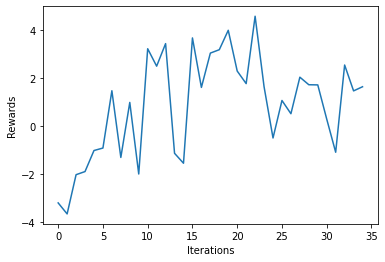

  4%|██▋                                                                         | 3605/100000 [01:45<57:22, 28.00it/s]

Updated Weights
Mean Reward = 2.9140000000000015
20


  4%|██▋                                                                       | 3705/100000 [01:48<1:01:43, 26.00it/s]

Updated Weights
Mean Reward = 1.9610000000000014
17


  4%|██▊                                                                       | 3803/100000 [01:52<1:07:38, 23.70it/s]

Updated Weights
Mean Reward = -0.41199999999999903
20


  4%|██▉                                                                         | 3906/100000 [01:56<56:50, 28.18it/s]

Updated Weights
Mean Reward = -0.9769999999999984
18


  4%|██▉                                                                       | 4000/100000 [02:00<1:02:07, 25.76it/s]

Updated Weights
Mean Reward = 2.938000000000002
27


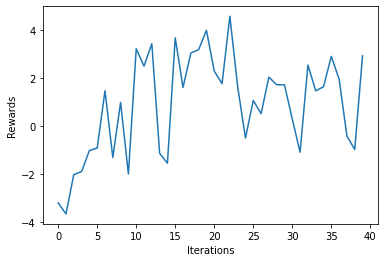

  4%|███                                                                       | 4103/100000 [02:04<1:09:40, 22.94it/s]

Updated Weights
Mean Reward = 1.1590000000000003
10


  4%|███                                                                       | 4203/100000 [02:08<1:09:19, 23.03it/s]

Updated Weights
Mean Reward = 0.5720000000000011
13


  4%|███▏                                                                      | 4304/100000 [02:12<1:00:26, 26.39it/s]

Updated Weights
Mean Reward = 2.555000000000001
25


  4%|███▎                                                                      | 4405/100000 [02:16<1:08:01, 23.42it/s]

Updated Weights
Mean Reward = -0.8879999999999995
9


  4%|███▎                                                                      | 4499/100000 [02:20<1:11:21, 22.31it/s]

Updated Weights
Mean Reward = 0.37500000000000044
5


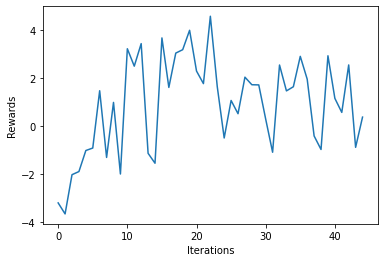

  5%|███▍                                                                      | 4605/100000 [02:25<1:08:53, 23.08it/s]

Updated Weights
Mean Reward = 1.140000000000002
7


  5%|███▍                                                                      | 4704/100000 [02:29<1:04:31, 24.62it/s]

Updated Weights
Mean Reward = 1.2910000000000008
12


  5%|███▋                                                                        | 4804/100000 [02:33<59:26, 26.69it/s]

Updated Weights
Mean Reward = 2.3410000000000015
19


  5%|███▋                                                                      | 4903/100000 [02:37<1:12:17, 21.92it/s]

Updated Weights
Mean Reward = 1.7840000000000016
9


  5%|███▋                                                                      | 4999/100000 [02:41<1:09:52, 22.66it/s]

Updated Weights
Mean Reward = 2.346000000000002
8


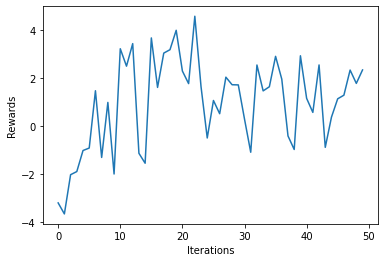

  5%|███▊                                                                      | 5102/100000 [02:45<1:09:36, 22.72it/s]

Updated Weights
Mean Reward = -0.06899999999999902
13


  5%|███▊                                                                      | 5205/100000 [02:49<1:03:08, 25.02it/s]

Updated Weights
Mean Reward = 3.649000000000001
30


  5%|███▉                                                                      | 5303/100000 [02:53<1:11:13, 22.16it/s]

Updated Weights
Mean Reward = -0.4209999999999988
20


  5%|███▉                                                                      | 5403/100000 [02:58<1:11:56, 21.91it/s]

Updated Weights
Mean Reward = 2.1530000000000022
11


  5%|████                                                                      | 5498/100000 [03:02<1:06:19, 23.75it/s]

Updated Weights
Mean Reward = 1.760000000000002
10


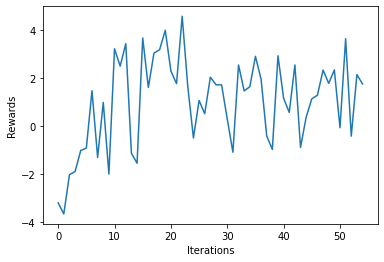

  6%|████▏                                                                     | 5604/100000 [03:06<1:07:55, 23.16it/s]

Updated Weights
Mean Reward = 1.9220000000000015
17


  6%|████▏                                                                     | 5705/100000 [03:11<1:02:28, 25.15it/s]

Updated Weights
Mean Reward = 1.1500000000000008
12


  6%|████▎                                                                     | 5803/100000 [03:15<1:23:55, 18.71it/s]

Updated Weights
Mean Reward = 2.9480000000000017
23


  6%|████▎                                                                     | 5904/100000 [03:19<1:05:58, 23.77it/s]

Updated Weights
Mean Reward = 1.4980000000000013
22


  6%|████▍                                                                     | 6000/100000 [03:23<1:04:00, 24.48it/s]

Updated Weights
Mean Reward = 1.9050000000000011
21


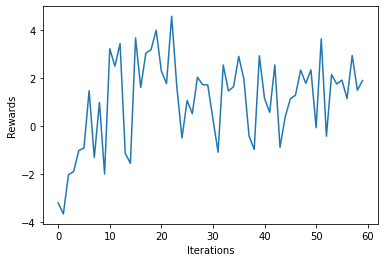

  6%|████▋                                                                       | 6103/100000 [03:27<54:51, 28.53it/s]

Updated Weights
Mean Reward = 0.8860000000000012
29


  6%|████▌                                                                     | 6205/100000 [03:31<1:02:08, 25.15it/s]

Updated Weights
Mean Reward = 1.9590000000000014
23


  6%|████▋                                                                     | 6304/100000 [03:35<1:06:25, 23.51it/s]

Updated Weights
Mean Reward = -0.540999999999999
10


  6%|████▋                                                                     | 6403/100000 [03:39<1:06:03, 23.61it/s]

Updated Weights
Mean Reward = 1.4420000000000022
7


  6%|████▉                                                                       | 6499/100000 [03:43<54:14, 28.73it/s]

Updated Weights
Mean Reward = 2.6100000000000008
14


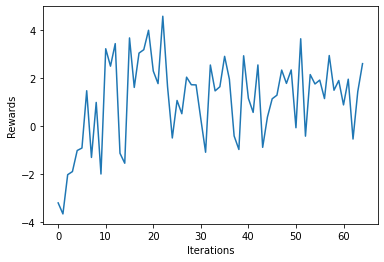

  7%|████▉                                                                     | 6602/100000 [03:48<1:09:27, 22.41it/s]

Updated Weights
Mean Reward = 0.45300000000000096
15


  7%|████▉                                                                     | 6705/100000 [03:52<1:07:37, 23.00it/s]

Updated Weights
Mean Reward = 0.03200000000000091
9


  7%|█████▏                                                                      | 6805/100000 [03:57<59:50, 25.96it/s]

Updated Weights
Mean Reward = 2.2270000000000016
14


  7%|█████                                                                     | 6902/100000 [04:00<1:09:48, 22.22it/s]

Updated Weights
Mean Reward = 2.777000000000001
19


  7%|█████▏                                                                    | 6998/100000 [04:04<1:05:15, 23.75it/s]

Updated Weights
Mean Reward = 1.0720000000000014
23


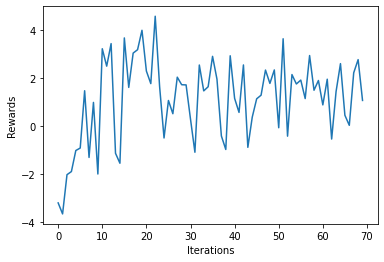

  7%|█████▎                                                                    | 7104/100000 [04:09<1:13:01, 21.20it/s]

Updated Weights
Mean Reward = 1.7570000000000012
21


  7%|█████▎                                                                    | 7203/100000 [04:13<1:09:53, 22.13it/s]

Updated Weights
Mean Reward = 2.2850000000000015
24


  7%|█████▍                                                                    | 7304/100000 [04:17<1:09:23, 22.26it/s]

Updated Weights
Mean Reward = 1.0490000000000013
18


  7%|█████▍                                                                    | 7403/100000 [04:21<1:02:38, 24.64it/s]

Updated Weights
Mean Reward = 0.922000000000001
14


  7%|█████▋                                                                      | 7499/100000 [04:25<53:44, 28.69it/s]

Updated Weights
Mean Reward = 2.035000000000001
24


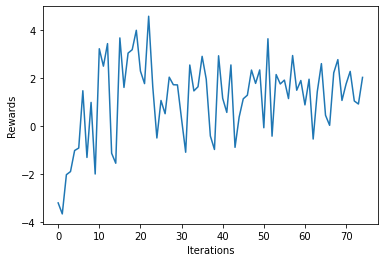

  8%|█████▋                                                                    | 7602/100000 [04:29<1:11:37, 21.50it/s]

Updated Weights
Mean Reward = -0.9019999999999991
7


  8%|█████▋                                                                    | 7704/100000 [04:34<1:10:40, 21.77it/s]

Updated Weights
Mean Reward = -0.6089999999999993
1


  8%|█████▊                                                                    | 7805/100000 [04:38<1:03:29, 24.20it/s]

Updated Weights
Mean Reward = 1.3110000000000013
11


  8%|█████▊                                                                    | 7905/100000 [04:42<1:02:00, 24.76it/s]

Updated Weights
Mean Reward = 3.0190000000000015
19


  8%|█████▉                                                                    | 7997/100000 [04:46<1:04:42, 23.70it/s]

Updated Weights
Mean Reward = 1.9560000000000013
25


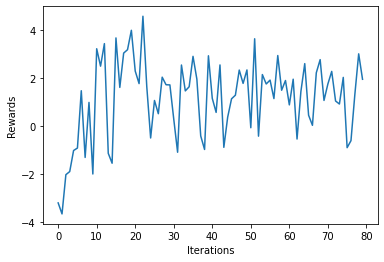

  8%|█████▉                                                                    | 8104/100000 [04:50<1:06:54, 22.89it/s]

Updated Weights
Mean Reward = 0.5230000000000008
17


  8%|██████▏                                                                     | 8207/100000 [04:55<57:26, 26.63it/s]

Updated Weights
Mean Reward = 0.0020000000000014806
10


  8%|██████▏                                                                   | 8302/100000 [04:59<1:09:38, 21.95it/s]

Updated Weights
Mean Reward = 3.349000000000001
21


  8%|██████▏                                                                   | 8404/100000 [05:03<1:03:53, 23.89it/s]

Updated Weights
Mean Reward = 1.1470000000000011
5


  8%|██████▎                                                                   | 8498/100000 [05:07<1:06:07, 23.06it/s]

Updated Weights
Mean Reward = 1.9920000000000018
12


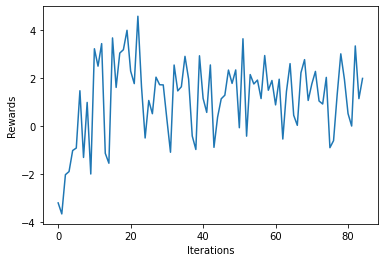

  9%|██████▎                                                                   | 8606/100000 [05:12<1:05:19, 23.32it/s]

Updated Weights
Mean Reward = 1.111000000000001
11


  9%|██████▍                                                                   | 8703/100000 [05:16<1:03:57, 23.79it/s]

Updated Weights
Mean Reward = 2.5500000000000016
21


  9%|██████▌                                                                   | 8804/100000 [05:20<1:04:01, 23.74it/s]

Updated Weights
Mean Reward = 0.6860000000000004
12


  9%|██████▌                                                                   | 8903/100000 [05:24<1:05:38, 23.13it/s]

Updated Weights
Mean Reward = 1.2520000000000016
21


  9%|██████▋                                                                   | 8999/100000 [05:28<1:03:01, 24.06it/s]

Updated Weights
Mean Reward = 1.4650000000000012
9


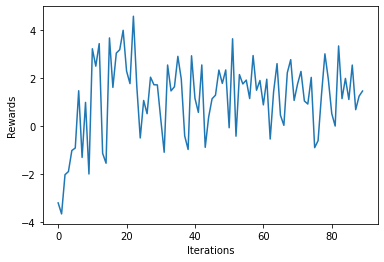

  9%|██████▋                                                                   | 9105/100000 [05:33<1:06:09, 22.90it/s]

Updated Weights
Mean Reward = 1.2250000000000012
8


  9%|██████▊                                                                   | 9203/100000 [05:37<1:01:42, 24.53it/s]

Updated Weights
Mean Reward = 2.125000000000001
18


  9%|██████▉                                                                   | 9304/100000 [05:41<1:08:50, 21.96it/s]

Updated Weights
Mean Reward = 0.3520000000000008
15


  9%|██████▉                                                                   | 9403/100000 [05:45<1:03:54, 23.62it/s]

Updated Weights
Mean Reward = 1.4340000000000013
10


  9%|███████                                                                   | 9499/100000 [05:50<1:09:34, 21.68it/s]

Updated Weights
Mean Reward = 0.03300000000000102
3


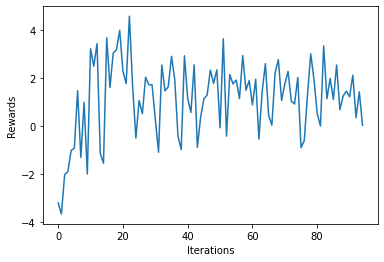

 10%|███████                                                                   | 9603/100000 [05:54<1:02:32, 24.09it/s]

Updated Weights
Mean Reward = 0.6830000000000005
6


 10%|███████▍                                                                    | 9709/100000 [05:58<45:16, 33.24it/s]

Updated Weights
Mean Reward = 2.798
24


 10%|███████▍                                                                    | 9804/100000 [06:02<53:11, 28.26it/s]

Updated Weights
Mean Reward = -0.8999999999999986
34


 10%|███████▎                                                                  | 9904/100000 [06:06<1:09:05, 21.73it/s]

Updated Weights
Mean Reward = -5.986000000000001
10


 10%|███████▍                                                                  | 9998/100000 [06:11<1:08:59, 21.74it/s]

Updated Weights
Mean Reward = 0.011000000000000152
6


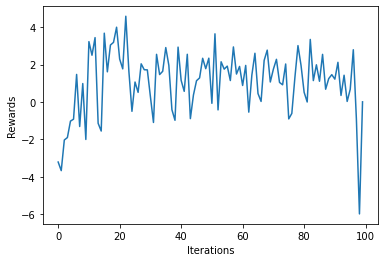

 10%|███████▍                                                                 | 10103/100000 [06:15<1:08:17, 21.94it/s]

Updated Weights
Mean Reward = 0.7990000000000008
2


 10%|███████▍                                                                 | 10203/100000 [06:20<1:07:59, 22.01it/s]

Updated Weights
Mean Reward = 1.0690000000000006
9


 10%|███████▌                                                                 | 10306/100000 [06:24<1:02:33, 23.90it/s]

Updated Weights
Mean Reward = 1.2520000000000016
8


 10%|███████▊                                                                   | 10405/100000 [06:28<59:41, 25.02it/s]

Updated Weights
Mean Reward = 1.6940000000000013
14


 10%|███████▋                                                                 | 10498/100000 [06:32<1:03:59, 23.31it/s]

Updated Weights
Mean Reward = 1.1010000000000002
16


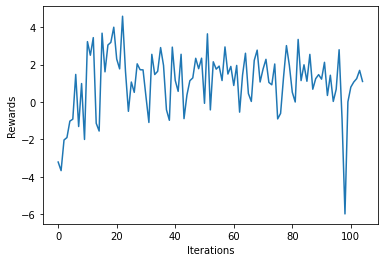

 11%|███████▋                                                                 | 10603/100000 [06:37<1:05:51, 22.62it/s]

Updated Weights
Mean Reward = 1.2570000000000008
17


 11%|███████▊                                                                 | 10704/100000 [06:41<1:07:16, 22.12it/s]

Updated Weights
Mean Reward = 0.6530000000000017
7


 11%|███████▉                                                                 | 10804/100000 [06:46<1:05:01, 22.86it/s]

Updated Weights
Mean Reward = 1.1140000000000008
7


 11%|████████▏                                                                  | 10904/100000 [06:50<56:13, 26.41it/s]

Updated Weights
Mean Reward = 1.3530000000000004
12


 11%|████████▏                                                                  | 10998/100000 [06:54<54:30, 27.21it/s]

Updated Weights
Mean Reward = 2.2730000000000015
17


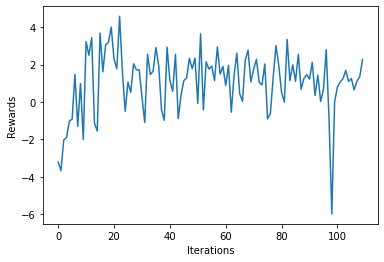

 11%|████████                                                                 | 11104/100000 [06:59<1:09:52, 21.20it/s]

Updated Weights
Mean Reward = 1.1070000000000009
10


 11%|████████▏                                                                | 11204/100000 [07:03<1:06:47, 22.16it/s]

Updated Weights
Mean Reward = 0.9390000000000005
13


 11%|████████▎                                                                | 11303/100000 [07:07<1:04:52, 22.79it/s]

Updated Weights
Mean Reward = 1.667000000000001
6


 11%|████████▎                                                                | 11402/100000 [07:12<1:02:20, 23.69it/s]

Updated Weights
Mean Reward = 2.1530000000000014
12


 12%|████████▋                                                                  | 11500/100000 [07:16<56:39, 26.03it/s]

Updated Weights
Mean Reward = 1.746000000000001
14


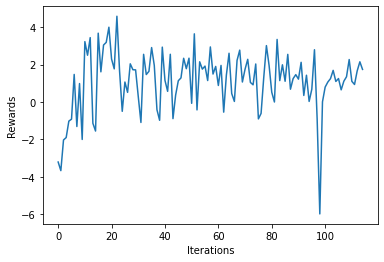

 12%|████████▋                                                                  | 11604/100000 [07:20<59:28, 24.77it/s]

Updated Weights
Mean Reward = 2.080000000000002
21


 12%|████████▌                                                                | 11703/100000 [07:24<1:04:31, 22.81it/s]

Updated Weights
Mean Reward = -0.25499999999999867
3


 12%|████████▌                                                                | 11803/100000 [07:29<1:03:25, 23.17it/s]

Updated Weights
Mean Reward = 1.685000000000001
6


 12%|████████▉                                                                  | 11905/100000 [07:33<55:13, 26.58it/s]

Updated Weights
Mean Reward = 3.5890000000000013
20


 12%|████████▉                                                                  | 11997/100000 [07:37<53:09, 27.59it/s]

Updated Weights
Mean Reward = 2.4830000000000014
23


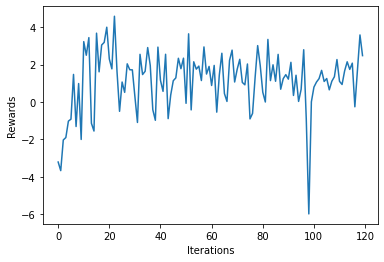

 12%|████████▊                                                                | 12105/100000 [07:42<1:04:00, 22.89it/s]

Updated Weights
Mean Reward = 1.052000000000001
16


 12%|████████▉                                                                | 12204/100000 [07:46<1:01:30, 23.79it/s]

Updated Weights
Mean Reward = 2.6180000000000008
22


 12%|████████▉                                                                | 12304/100000 [07:50<1:06:16, 22.05it/s]

Updated Weights
Mean Reward = 1.7580000000000013
9


 12%|█████████                                                                | 12406/100000 [07:54<1:01:32, 23.72it/s]

Updated Weights
Mean Reward = 1.2970000000000022
13


 12%|█████████                                                                | 12498/100000 [07:58<1:01:36, 23.67it/s]

Updated Weights
Mean Reward = 0.8700000000000014
14


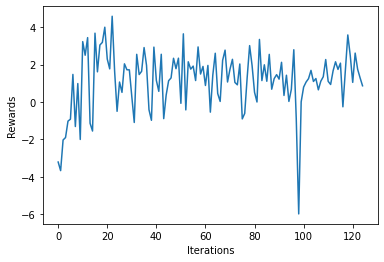

 13%|█████████▏                                                               | 12605/100000 [08:03<1:03:18, 23.01it/s]

Updated Weights
Mean Reward = 2.124000000000002
10


 13%|█████████▌                                                                 | 12702/100000 [08:07<59:15, 24.56it/s]

Updated Weights
Mean Reward = 4.350000000000001
30


 13%|█████████▌                                                                 | 12805/100000 [08:11<57:33, 25.25it/s]

Updated Weights
Mean Reward = -0.11599999999999897
17


 13%|█████████▍                                                               | 12904/100000 [08:15<1:04:09, 22.63it/s]

Updated Weights
Mean Reward = 1.6040000000000014
12


 13%|█████████▍                                                               | 12999/100000 [08:19<1:02:42, 23.12it/s]

Updated Weights
Mean Reward = 2.038000000000002
19


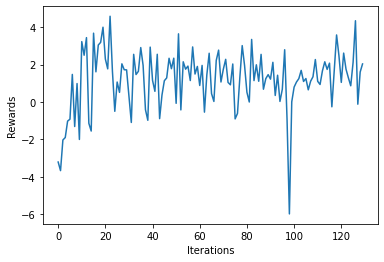

 13%|█████████▊                                                                 | 13103/100000 [08:24<58:01, 24.96it/s]

Updated Weights
Mean Reward = 3.2160000000000006
21


 13%|█████████▉                                                                 | 13204/100000 [08:28<52:12, 27.71it/s]

Updated Weights
Mean Reward = 1.9120000000000017
16


 13%|█████████▉                                                                 | 13302/100000 [08:32<57:34, 25.10it/s]

Updated Weights
Mean Reward = 1.571000000000002
21


 13%|██████████                                                                 | 13405/100000 [08:36<58:22, 24.72it/s]

Updated Weights
Mean Reward = -0.08199999999999864
11


 13%|█████████▊                                                               | 13497/100000 [08:40<1:04:49, 22.24it/s]

Updated Weights
Mean Reward = 2.836000000000002
15


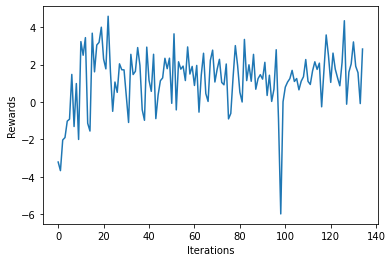

 14%|█████████▉                                                               | 13602/100000 [08:45<1:04:14, 22.42it/s]

Updated Weights
Mean Reward = 2.184000000000001
23


 14%|██████████▎                                                                | 13704/100000 [08:49<57:33, 24.99it/s]

Updated Weights
Mean Reward = 3.236
20


 14%|██████████                                                               | 13803/100000 [08:53<1:02:27, 23.00it/s]

Updated Weights
Mean Reward = 2.873000000000001
16


 14%|██████████▏                                                              | 13905/100000 [08:57<1:06:10, 21.68it/s]

Updated Weights
Mean Reward = -0.10299999999999918
12


 14%|██████████▏                                                              | 13998/100000 [09:01<1:01:32, 23.29it/s]

Updated Weights
Mean Reward = 1.0150000000000008
10


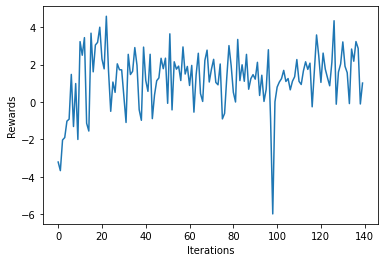

 14%|██████████▌                                                                | 14104/100000 [09:06<51:15, 27.93it/s]

Updated Weights
Mean Reward = 3.518000000000001
20


 14%|██████████▎                                                              | 14204/100000 [09:10<1:00:27, 23.65it/s]

Updated Weights
Mean Reward = 1.8210000000000022
20


 14%|██████████▋                                                                | 14303/100000 [09:14<58:17, 24.50it/s]

Updated Weights
Mean Reward = 2.1330000000000022
27


 14%|██████████▊                                                                | 14405/100000 [09:18<58:45, 24.28it/s]

Updated Weights
Mean Reward = 1.7000000000000017
19


 14%|██████████▊                                                                | 14498/100000 [09:21<48:31, 29.37it/s]

Updated Weights
Mean Reward = 3.9310000000000014
27


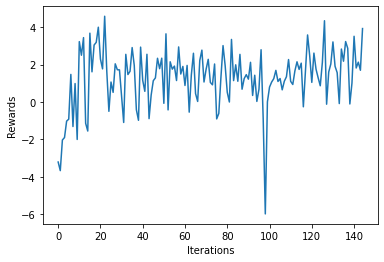

 15%|██████████▉                                                                | 14604/100000 [09:26<58:58, 24.13it/s]

Updated Weights
Mean Reward = 0.4400000000000008
17


 15%|██████████▋                                                              | 14704/100000 [09:30<1:08:36, 20.72it/s]

Updated Weights
Mean Reward = 2.320000000000001
10


 15%|██████████▊                                                              | 14804/100000 [09:35<1:00:44, 23.38it/s]

Updated Weights
Mean Reward = 2.6190000000000015
13


 15%|███████████▏                                                               | 14905/100000 [09:40<58:57, 24.06it/s]

Updated Weights
Mean Reward = 2.884000000000001
21


 15%|██████████▉                                                              | 15000/100000 [09:44<1:07:53, 20.87it/s]

Updated Weights
Mean Reward = -0.4669999999999991
22


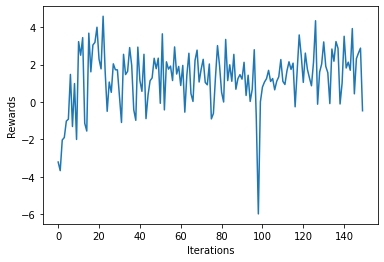

 15%|███████████                                                              | 15104/100000 [09:49<1:09:58, 20.22it/s]

Updated Weights
Mean Reward = -0.35699999999999854
8


 15%|███████████                                                              | 15202/100000 [09:54<1:10:37, 20.01it/s]

Updated Weights
Mean Reward = 1.6810000000000018
5


 15%|███████████▏                                                             | 15304/100000 [09:59<1:03:12, 22.34it/s]

Updated Weights
Mean Reward = 4.159000000000001
25


 15%|███████████▏                                                             | 15404/100000 [10:03<1:02:06, 22.70it/s]

Updated Weights
Mean Reward = 4.147000000000001
28


 15%|███████████▎                                                             | 15498/100000 [10:07<1:03:17, 22.25it/s]

Updated Weights
Mean Reward = 1.515000000000002
26


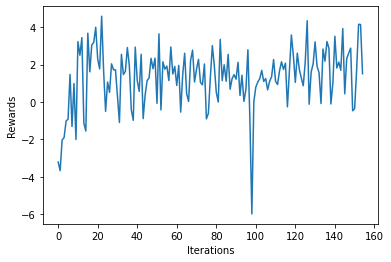

 16%|███████████▍                                                             | 15603/100000 [10:13<1:09:26, 20.26it/s]

Updated Weights
Mean Reward = 2.590000000000001
26


 16%|███████████▊                                                               | 15704/100000 [10:17<49:36, 28.32it/s]

Updated Weights
Mean Reward = 2.142000000000002
30


 16%|███████████▌                                                             | 15804/100000 [10:21<1:08:28, 20.49it/s]

Updated Weights
Mean Reward = -0.10099999999999985
7


 16%|███████████▉                                                               | 15902/100000 [10:26<59:25, 23.59it/s]

Updated Weights
Mean Reward = 1.2770000000000008
10


 16%|████████████                                                               | 16000/100000 [10:30<53:11, 26.32it/s]

Updated Weights
Mean Reward = 2.1340000000000012
19


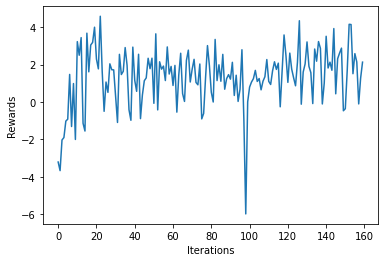

 16%|███████████▊                                                             | 16104/100000 [10:34<1:00:34, 23.08it/s]

Updated Weights
Mean Reward = 1.4650000000000014
23


 16%|████████████▏                                                              | 16203/100000 [10:39<57:31, 24.27it/s]

Updated Weights
Mean Reward = 1.9070000000000025
17


 16%|███████████▉                                                             | 16303/100000 [10:42<1:02:19, 22.38it/s]

Updated Weights
Mean Reward = 3.083000000000002
29


 16%|████████████▎                                                              | 16403/100000 [10:46<58:52, 23.67it/s]

Updated Weights
Mean Reward = 1.0260000000000011
22


 16%|████████████▎                                                              | 16498/100000 [10:50<54:56, 25.33it/s]

Updated Weights
Mean Reward = 2.938000000000002
27


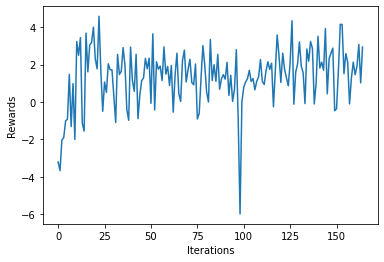

 17%|████████████▍                                                              | 16603/100000 [10:54<57:53, 24.01it/s]

Updated Weights
Mean Reward = 1.248000000000002
23


 17%|████████████▏                                                            | 16703/100000 [10:58<1:00:49, 22.83it/s]

Updated Weights
Mean Reward = 1.1510000000000014
12


 17%|████████████▌                                                              | 16803/100000 [11:03<59:20, 23.36it/s]

Updated Weights
Mean Reward = 0.5280000000000011
8


 17%|████████████▎                                                            | 16904/100000 [11:07<1:01:21, 22.57it/s]

Updated Weights
Mean Reward = 2.7150000000000016
18


 17%|████████████▋                                                              | 16998/100000 [11:11<59:16, 23.34it/s]

Updated Weights
Mean Reward = 3.172000000000001
27


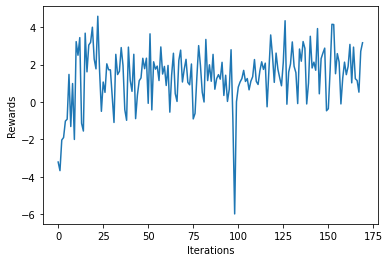

 17%|████████████▊                                                              | 17103/100000 [11:15<56:37, 24.40it/s]

Updated Weights
Mean Reward = 2.795000000000002
26


 17%|████████████▉                                                              | 17204/100000 [11:19<54:33, 25.29it/s]

Updated Weights
Mean Reward = 2.4410000000000016
28


 17%|████████████▋                                                            | 17304/100000 [11:24<1:19:35, 17.32it/s]

Updated Weights
Mean Reward = 3.0390000000000015
21


 17%|████████████▋                                                            | 17403/100000 [11:29<1:11:23, 19.28it/s]

Updated Weights
Mean Reward = 4.503000000000002
30


 18%|████████████▊                                                            | 17500/100000 [11:35<1:18:16, 17.57it/s]

Updated Weights
Mean Reward = 1.8790000000000018
25


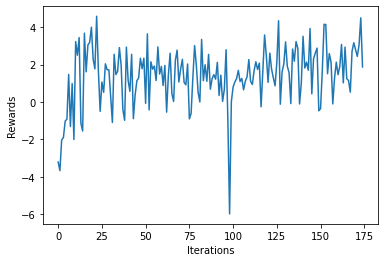

 18%|████████████▊                                                            | 17602/100000 [11:41<1:28:18, 15.55it/s]

Updated Weights
Mean Reward = 2.1470000000000016
25


 18%|████████████▉                                                            | 17703/100000 [11:47<1:13:50, 18.57it/s]

Updated Weights
Mean Reward = 0.3140000000000015
17


 18%|████████████▉                                                            | 17803/100000 [11:53<1:16:19, 17.95it/s]

Updated Weights
Mean Reward = 4.586000000000002
33


 18%|█████████████                                                            | 17902/100000 [11:59<1:26:57, 15.73it/s]

Updated Weights
Mean Reward = -1.4689999999999983
13


 18%|█████████████▏                                                           | 18000/100000 [12:05<1:36:54, 14.10it/s]

Updated Weights
Mean Reward = 1.993000000000002
12


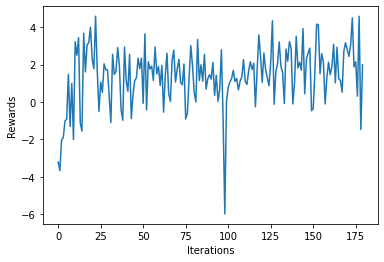

 18%|█████████████▏                                                           | 18102/100000 [12:12<1:38:03, 13.92it/s]

Updated Weights
Mean Reward = 2.7630000000000012
21


 18%|█████████████▎                                                           | 18203/100000 [12:19<1:20:00, 17.04it/s]

Updated Weights
Mean Reward = 2.922000000000001
17


 18%|█████████████▎                                                           | 18303/100000 [12:25<1:31:04, 14.95it/s]

Updated Weights
Mean Reward = 2.5670000000000015
21


 18%|█████████████▍                                                           | 18403/100000 [12:31<1:32:06, 14.77it/s]

Updated Weights
Mean Reward = 1.7810000000000015
21


 18%|█████████████▌                                                           | 18499/100000 [12:37<1:19:00, 17.19it/s]

Updated Weights
Mean Reward = 1.9940000000000004
22


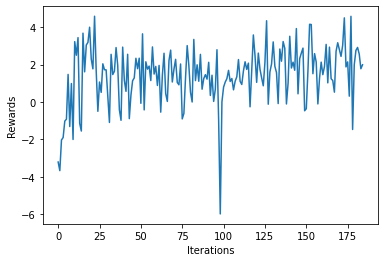

 19%|█████████████▌                                                           | 18602/100000 [12:44<1:34:50, 14.31it/s]

Updated Weights
Mean Reward = 1.7100000000000015
25


 19%|█████████████▋                                                           | 18703/100000 [12:51<1:30:30, 14.97it/s]

Updated Weights
Mean Reward = 1.1660000000000006
9


 19%|█████████████▋                                                           | 18804/100000 [12:58<1:31:56, 14.72it/s]

Updated Weights
Mean Reward = 2.814000000000002
17


 19%|█████████████▊                                                           | 18902/100000 [13:05<1:35:57, 14.09it/s]

Updated Weights
Mean Reward = 0.3050000000000022
11


 19%|█████████████▊                                                           | 18999/100000 [13:11<1:36:04, 14.05it/s]

Updated Weights
Mean Reward = 2.998000000000003
21


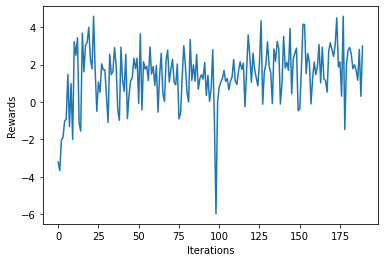

 19%|█████████████▉                                                           | 19103/100000 [13:18<1:32:57, 14.50it/s]

Updated Weights
Mean Reward = 1.8150000000000028
20


 19%|██████████████                                                           | 19203/100000 [13:24<1:29:26, 15.06it/s]

Updated Weights
Mean Reward = 2.201000000000002
30


 19%|██████████████                                                           | 19304/100000 [13:30<1:12:56, 18.44it/s]

Updated Weights
Mean Reward = 3.2530000000000023
24


 19%|██████████████▏                                                          | 19402/100000 [13:36<1:27:19, 15.38it/s]

Updated Weights
Mean Reward = 1.8700000000000014
34


 20%|██████████████▏                                                          | 19500/100000 [13:43<1:33:37, 14.33it/s]

Updated Weights
Mean Reward = 2.1210000000000018
17


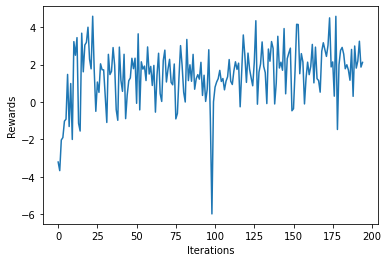

 20%|██████████████▎                                                          | 19603/100000 [13:50<1:47:52, 12.42it/s]

Updated Weights
Mean Reward = 1.4610000000000019
14


 20%|██████████████▍                                                          | 19704/100000 [13:56<1:24:48, 15.78it/s]

Updated Weights
Mean Reward = 1.8100000000000025
23


 20%|██████████████▍                                                          | 19804/100000 [14:03<1:24:08, 15.89it/s]

Updated Weights
Mean Reward = 2.247000000000002
25


 20%|██████████████▌                                                          | 19903/100000 [14:09<1:39:16, 13.45it/s]

Updated Weights
Mean Reward = 0.8670000000000018
16


 20%|██████████████▌                                                          | 20000/100000 [14:16<1:32:54, 14.35it/s]

Updated Weights
Mean Reward = 2.389000000000002
27


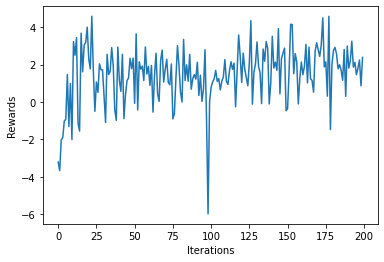

 20%|██████████████▋                                                          | 20103/100000 [14:22<1:27:24, 15.23it/s]

Updated Weights
Mean Reward = 1.8280000000000016
24


 20%|██████████████▋                                                          | 20203/100000 [14:29<1:33:30, 14.22it/s]

Updated Weights
Mean Reward = 2.1920000000000015
22


 20%|██████████████▊                                                          | 20303/100000 [14:36<1:39:11, 13.39it/s]

Updated Weights
Mean Reward = 0.7410000000000012
6


 20%|██████████████▉                                                          | 20404/100000 [14:43<1:20:27, 16.49it/s]

Updated Weights
Mean Reward = 1.8960000000000017
9


 20%|██████████████▉                                                          | 20499/100000 [14:49<1:34:48, 13.98it/s]

Updated Weights
Mean Reward = 2.5200000000000014
22


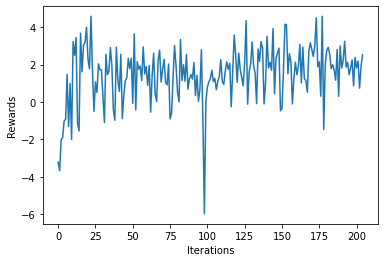

 21%|███████████████                                                          | 20603/100000 [14:55<1:15:08, 17.61it/s]

Updated Weights
Mean Reward = 2.6960000000000024
32


 21%|███████████████                                                          | 20702/100000 [15:02<1:36:08, 13.75it/s]

Updated Weights
Mean Reward = 0.33000000000000135
19


 21%|███████████████▏                                                         | 20802/100000 [15:09<1:36:58, 13.61it/s]

Updated Weights
Mean Reward = 1.253000000000001
9


 21%|███████████████▎                                                         | 20904/100000 [15:16<1:24:40, 15.57it/s]

Updated Weights
Mean Reward = 1.1950000000000014
9


 21%|███████████████▎                                                         | 20998/100000 [15:22<1:35:35, 13.77it/s]

Updated Weights
Mean Reward = 2.3630000000000018
11


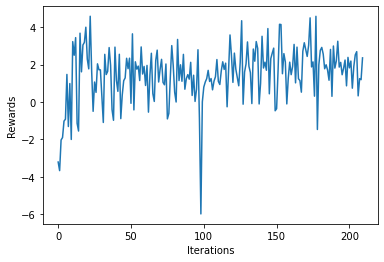

 21%|███████████████▍                                                         | 21102/100000 [15:30<1:28:20, 14.89it/s]

Updated Weights
Mean Reward = 1.455000000000002
13


 21%|███████████████▍                                                         | 21202/100000 [15:37<1:37:02, 13.53it/s]

Updated Weights
Mean Reward = -0.6709999999999994
2


 21%|███████████████▌                                                         | 21304/100000 [15:44<1:27:06, 15.06it/s]

Updated Weights
Mean Reward = 0.9120000000000015
4


 21%|███████████████▌                                                         | 21403/100000 [15:51<1:31:13, 14.36it/s]

Updated Weights
Mean Reward = 1.7860000000000016
10


 21%|███████████████▋                                                         | 21497/100000 [15:57<1:16:17, 17.15it/s]

Updated Weights
Mean Reward = 2.6120000000000005
19


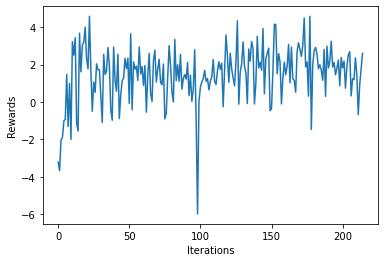

 22%|███████████████▊                                                         | 21603/100000 [16:04<1:23:52, 15.58it/s]

Updated Weights
Mean Reward = 1.932000000000002
19


 22%|███████████████▊                                                         | 21702/100000 [16:09<1:00:51, 21.44it/s]

Updated Weights
Mean Reward = 2.2440000000000024
20


 22%|████████████████▎                                                          | 21804/100000 [16:14<49:09, 26.51it/s]

Updated Weights
Mean Reward = 2.460000000000002
23


 22%|███████████████▉                                                         | 21904/100000 [16:19<1:08:43, 18.94it/s]

Updated Weights
Mean Reward = 2.055000000000001
25


 22%|████████████████                                                         | 21999/100000 [16:24<1:14:25, 17.47it/s]

Updated Weights
Mean Reward = 2.217000000000001
17


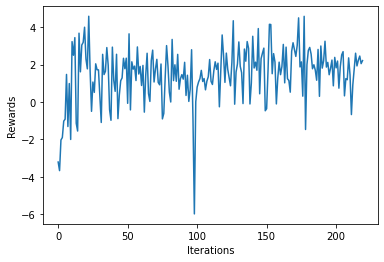

 22%|████████████████▌                                                          | 22103/100000 [16:29<51:38, 25.14it/s]

Updated Weights
Mean Reward = 2.6150000000000024
29


 22%|████████████████▏                                                        | 22202/100000 [16:33<1:07:40, 19.16it/s]

Updated Weights
Mean Reward = -1.0659999999999987
16


 22%|████████████████▎                                                        | 22304/100000 [16:38<1:02:58, 20.56it/s]

Updated Weights
Mean Reward = 2.568000000000002
15


 22%|████████████████▎                                                        | 22402/100000 [16:43<1:01:55, 20.89it/s]

Updated Weights
Mean Reward = 0.5690000000000012
7


 22%|████████████████▊                                                          | 22498/100000 [16:47<56:27, 22.88it/s]

Updated Weights
Mean Reward = 1.928000000000001
14


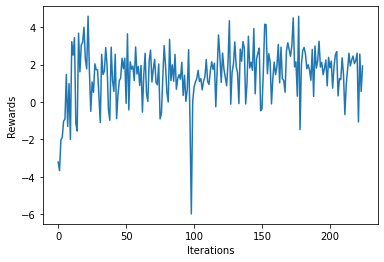

 23%|████████████████▉                                                          | 22604/100000 [16:52<56:19, 22.90it/s]

Updated Weights
Mean Reward = 0.08700000000000122
3


 23%|█████████████████                                                          | 22704/100000 [16:56<56:24, 22.84it/s]

Updated Weights
Mean Reward = 1.916000000000001
13


 23%|█████████████████                                                          | 22803/100000 [17:00<55:09, 23.32it/s]

Updated Weights
Mean Reward = 2.5640000000000005
13


 23%|█████████████████▏                                                         | 22903/100000 [17:05<53:27, 24.04it/s]

Updated Weights
Mean Reward = 2.1770000000000014
8


 23%|█████████████████▎                                                         | 23000/100000 [17:09<55:15, 23.23it/s]

Updated Weights
Mean Reward = 2.7370000000000023
8


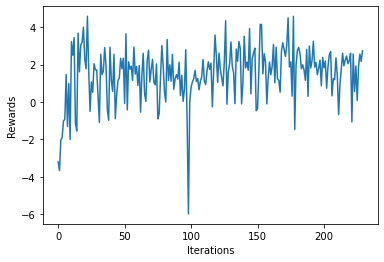

 23%|█████████████████▎                                                         | 23104/100000 [17:14<56:23, 22.73it/s]

Updated Weights
Mean Reward = 2.135000000000001
11


 23%|█████████████████▍                                                         | 23204/100000 [17:18<53:16, 24.03it/s]

Updated Weights
Mean Reward = 1.8590000000000015
11


 23%|█████████████████▍                                                         | 23302/100000 [17:22<55:41, 22.95it/s]

Updated Weights
Mean Reward = 2.2860000000000023
16


 23%|█████████████████▌                                                         | 23402/100000 [17:26<57:45, 22.10it/s]

Updated Weights
Mean Reward = 2.286000000000002
11


 23%|█████████████████▌                                                         | 23498/100000 [17:31<52:19, 24.37it/s]

Updated Weights
Mean Reward = 1.9390000000000018
13


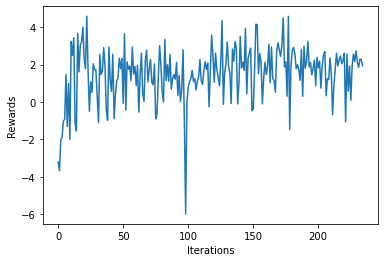

 24%|█████████████████▋                                                         | 23604/100000 [17:35<51:13, 24.86it/s]

Updated Weights
Mean Reward = 1.785000000000002
26


 24%|█████████████████▊                                                         | 23703/100000 [17:39<57:26, 22.14it/s]

Updated Weights
Mean Reward = 0.9280000000000009
10


 24%|█████████████████▊                                                         | 23802/100000 [17:43<54:01, 23.51it/s]

Updated Weights
Mean Reward = 1.8850000000000013
13


 24%|█████████████████▉                                                         | 23904/100000 [17:47<54:14, 23.38it/s]

Updated Weights
Mean Reward = 3.2130000000000014
26


 24%|██████████████████                                                         | 24000/100000 [17:51<54:04, 23.42it/s]

Updated Weights
Mean Reward = 1.0680000000000016
24


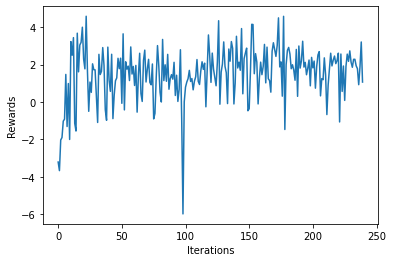

 24%|█████████████████▌                                                       | 24104/100000 [17:56<1:02:44, 20.16it/s]

Updated Weights
Mean Reward = -0.4489999999999994
7


 24%|██████████████████▏                                                        | 24204/100000 [18:01<55:06, 22.92it/s]

Updated Weights
Mean Reward = 1.9590000000000019
9


 24%|██████████████████▏                                                        | 24303/100000 [18:05<51:08, 24.67it/s]

Updated Weights
Mean Reward = 2.2370000000000014
14


 24%|██████████████████▎                                                        | 24405/100000 [18:09<54:35, 23.08it/s]

Updated Weights
Mean Reward = 2.674000000000001
16


 24%|██████████████████▎                                                        | 24499/100000 [18:13<52:11, 24.11it/s]

Updated Weights
Mean Reward = 1.922000000000002
31


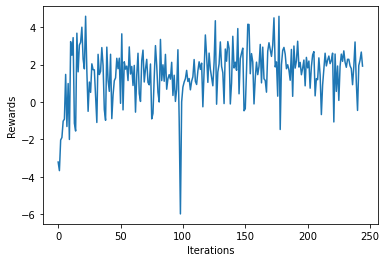

 25%|██████████████████▍                                                        | 24603/100000 [18:18<55:43, 22.55it/s]

Updated Weights
Mean Reward = 1.879000000000002
12


 25%|██████████████████▌                                                        | 24705/100000 [18:22<42:45, 29.35it/s]

Updated Weights
Mean Reward = 2.290000000000002
20


 25%|██████████████████▌                                                        | 24804/100000 [18:26<51:06, 24.52it/s]

Updated Weights
Mean Reward = 2.476000000000001
22


 25%|██████████████████▋                                                        | 24903/100000 [18:30<58:38, 21.34it/s]

Updated Weights
Mean Reward = 1.0260000000000025
20


 25%|██████████████████▋                                                        | 24998/100000 [18:34<45:22, 27.54it/s]

Updated Weights
Mean Reward = 1.346000000000001
15


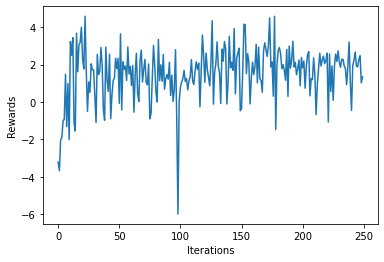

 25%|██████████████████▊                                                        | 25104/100000 [18:38<48:47, 25.58it/s]

Updated Weights
Mean Reward = 2.799000000000002
24


 25%|██████████████████▉                                                        | 25202/100000 [18:42<50:46, 24.55it/s]

Updated Weights
Mean Reward = 2.2780000000000022
24


 25%|██████████████████▉                                                        | 25302/100000 [18:46<48:52, 25.47it/s]

Updated Weights
Mean Reward = 3.6020000000000025
27


 25%|███████████████████                                                        | 25404/100000 [18:50<59:09, 21.01it/s]

Updated Weights
Mean Reward = 1.0980000000000016
18


 25%|███████████████████                                                        | 25499/100000 [18:54<47:21, 26.22it/s]

Updated Weights
Mean Reward = 1.9270000000000016
20


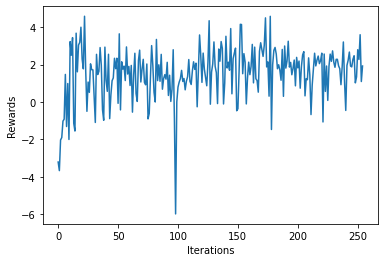

 26%|███████████████████▏                                                       | 25603/100000 [18:58<50:40, 24.47it/s]

Updated Weights
Mean Reward = 1.5390000000000015
24


 26%|███████████████████▎                                                       | 25706/100000 [19:02<48:40, 25.44it/s]

Updated Weights
Mean Reward = 3.2550000000000012
25


 26%|███████████████████▎                                                       | 25807/100000 [19:06<48:50, 25.32it/s]

Updated Weights
Mean Reward = 3.310000000000001
28


 26%|███████████████████▍                                                       | 25905/100000 [19:10<46:29, 26.56it/s]

Updated Weights
Mean Reward = 3.1990000000000016
30


 26%|███████████████████▌                                                       | 26000/100000 [19:13<50:28, 24.43it/s]

Updated Weights
Mean Reward = 2.043000000000001
28


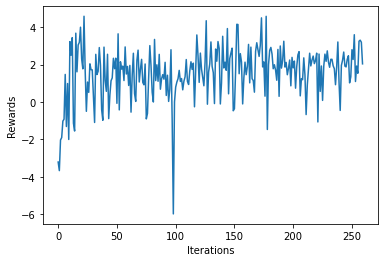

 26%|███████████████████▌                                                       | 26107/100000 [19:18<48:12, 25.55it/s]

Updated Weights
Mean Reward = 0.7410000000000012
21


 26%|███████████████████▋                                                       | 26205/100000 [19:22<55:07, 22.31it/s]

Updated Weights
Mean Reward = 2.148000000000002
16


 26%|███████████████████▋                                                       | 26304/100000 [19:26<52:26, 23.43it/s]

Updated Weights
Mean Reward = 1.5730000000000024
23


 26%|███████████████████▊                                                       | 26405/100000 [19:30<50:57, 24.07it/s]

Updated Weights
Mean Reward = -1.8589999999999995
8


 26%|███████████████████▊                                                       | 26498/100000 [19:34<53:21, 22.96it/s]

Updated Weights
Mean Reward = 1.803000000000001
12


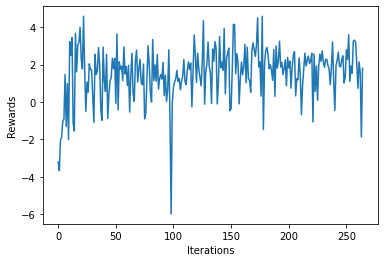

 27%|███████████████████▉                                                       | 26604/100000 [19:39<58:32, 20.90it/s]

Updated Weights
Mean Reward = 0.32500000000000123
5


 27%|████████████████████                                                       | 26706/100000 [19:44<52:02, 23.47it/s]

Updated Weights
Mean Reward = 0.7990000000000008
6


 27%|███████████████████▌                                                     | 26804/100000 [19:48<1:01:16, 19.91it/s]

Updated Weights
Mean Reward = 1.2760000000000016
6


 27%|████████████████████▏                                                      | 26902/100000 [19:53<55:51, 21.81it/s]

Updated Weights
Mean Reward = -0.01899999999999924
3


 27%|███████████████████▋                                                     | 26998/100000 [19:57<1:00:10, 20.22it/s]

Updated Weights
Mean Reward = -1.3489999999999993
1


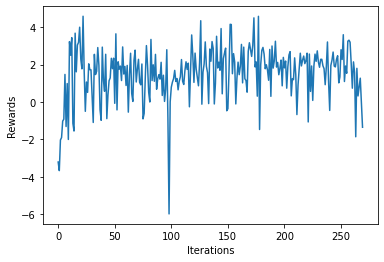

 27%|████████████████████▎                                                      | 27107/100000 [20:02<48:33, 25.02it/s]

Updated Weights
Mean Reward = -1.046999999999999
8


 27%|████████████████████▍                                                      | 27205/100000 [20:06<51:31, 23.55it/s]

Updated Weights
Mean Reward = 1.7480000000000013
15


 27%|████████████████████▍                                                      | 27303/100000 [20:11<55:59, 21.64it/s]

Updated Weights
Mean Reward = 1.9510000000000016
12


 27%|████████████████████▌                                                      | 27405/100000 [20:16<58:05, 20.83it/s]

Updated Weights
Mean Reward = 0.5040000000000016
8


 27%|████████████████████▌                                                      | 27498/100000 [20:20<44:04, 27.42it/s]

Updated Weights
Mean Reward = 1.6450000000000014
11


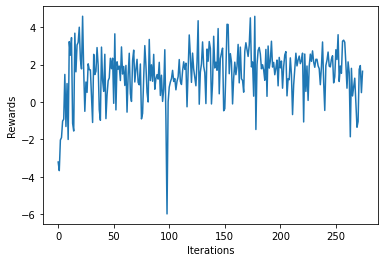

 28%|████████████████████▋                                                      | 27604/100000 [20:24<50:25, 23.93it/s]

Updated Weights
Mean Reward = 1.4750000000000016
7


 28%|████████████████████▊                                                      | 27702/100000 [20:29<59:28, 20.26it/s]

Updated Weights
Mean Reward = 0.7900000000000013
7


 28%|████████████████████▊                                                      | 27804/100000 [20:33<53:18, 22.58it/s]

Updated Weights
Mean Reward = 1.8180000000000012
12


 28%|████████████████████▉                                                      | 27902/100000 [20:37<51:37, 23.28it/s]

Updated Weights
Mean Reward = 2.4660000000000006
17


 28%|████████████████████▉                                                      | 27998/100000 [20:41<57:46, 20.77it/s]

Updated Weights
Mean Reward = 2.7710000000000012
14


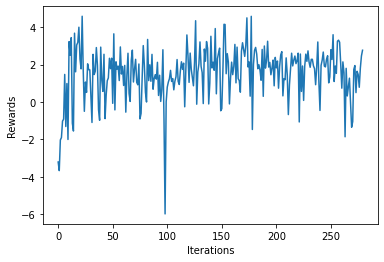

 28%|█████████████████████                                                      | 28102/100000 [20:47<58:44, 20.40it/s]

Updated Weights
Mean Reward = 2.9320000000000017
19


 28%|████████████████████▌                                                    | 28201/100000 [20:52<1:01:11, 19.56it/s]

Updated Weights
Mean Reward = 2.3620000000000005
28


 28%|████████████████████▋                                                    | 28302/100000 [20:57<1:05:45, 18.17it/s]

Updated Weights
Mean Reward = 2.954000000000001
25


 28%|█████████████████████▎                                                     | 28402/100000 [21:02<55:38, 21.45it/s]

Updated Weights
Mean Reward = 3.9780000000000006
34


 28%|████████████████████▊                                                    | 28500/100000 [21:08<1:10:33, 16.89it/s]

Updated Weights
Mean Reward = -1.8019999999999985
8


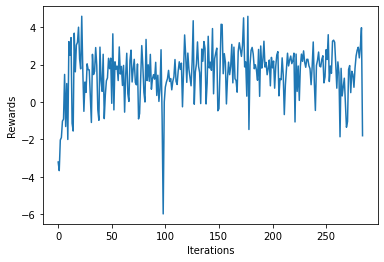

 29%|█████████████████████▍                                                     | 28602/100000 [21:14<56:35, 21.03it/s]

Updated Weights
Mean Reward = 0.7380000000000018
8


 29%|█████████████████████▌                                                     | 28705/100000 [21:18<49:46, 23.87it/s]

Updated Weights
Mean Reward = 1.5590000000000008
9


 29%|█████████████████████▌                                                     | 28804/100000 [21:23<50:19, 23.58it/s]

Updated Weights
Mean Reward = 3.336000000000001
21


 29%|█████████████████████▋                                                     | 28903/100000 [21:27<47:12, 25.10it/s]

Updated Weights
Mean Reward = 2.8190000000000013
18


 29%|█████████████████████▋                                                     | 28998/100000 [21:30<51:33, 22.95it/s]

Updated Weights
Mean Reward = 0.7940000000000011
16


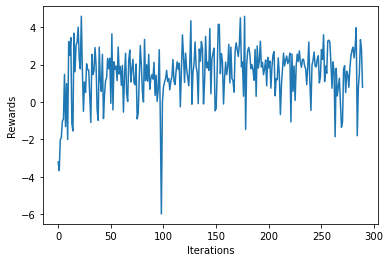

 29%|█████████████████████▊                                                     | 29103/100000 [21:35<48:21, 24.43it/s]

Updated Weights
Mean Reward = 3.868000000000001
28


 29%|█████████████████████▉                                                     | 29204/100000 [21:39<47:55, 24.62it/s]

Updated Weights
Mean Reward = 1.6720000000000015
30


 29%|█████████████████████▉                                                     | 29303/100000 [21:43<44:14, 26.63it/s]

Updated Weights
Mean Reward = 2.106000000000001
20


 29%|██████████████████████                                                     | 29405/100000 [21:47<53:35, 21.96it/s]

Updated Weights
Mean Reward = 1.256000000000001
19


 29%|██████████████████████                                                     | 29498/100000 [21:52<59:10, 19.86it/s]

Updated Weights
Mean Reward = 1.874000000000001
13


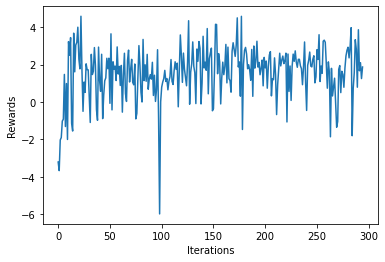

 30%|█████████████████████▌                                                   | 29603/100000 [21:58<1:11:35, 16.39it/s]

Updated Weights
Mean Reward = 3.164000000000001
19


 30%|█████████████████████▋                                                   | 29703/100000 [22:04<1:14:51, 15.65it/s]

Updated Weights
Mean Reward = 2.751000000000002
26


 30%|█████████████████████▊                                                   | 29802/100000 [22:09<1:11:45, 16.31it/s]

Updated Weights
Mean Reward = 3.232000000000001
26


 30%|██████████████████████▍                                                    | 29904/100000 [22:14<59:23, 19.67it/s]

Updated Weights
Mean Reward = 3.873000000000001
31


 30%|██████████████████████▍                                                    | 29998/100000 [22:20<49:49, 23.41it/s]

Updated Weights
Mean Reward = 2.745000000000001
32


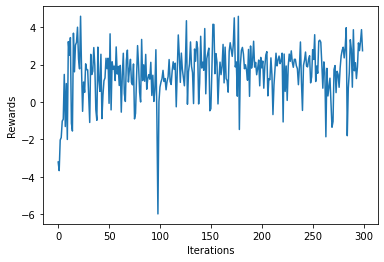

 30%|██████████████████████▌                                                    | 30103/100000 [22:26<48:12, 24.16it/s]

Updated Weights
Mean Reward = 1.0540000000000012
27


 30%|██████████████████████                                                   | 30202/100000 [22:34<2:18:41,  8.39it/s]

Updated Weights
Mean Reward = -1.7709999999999995
14


 30%|██████████████████████                                                   | 30304/100000 [22:42<1:22:59, 14.00it/s]

Updated Weights
Mean Reward = -1.0049999999999988
4


 30%|██████████████████████▏                                                  | 30403/100000 [22:48<1:24:32, 13.72it/s]

Updated Weights
Mean Reward = 1.0690000000000013
4


 30%|██████████████████████▎                                                  | 30499/100000 [22:54<1:13:20, 15.80it/s]

Updated Weights
Mean Reward = 1.767000000000002
6


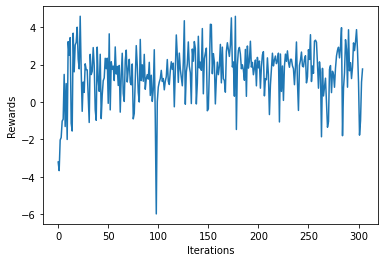

 31%|██████████████████████▎                                                  | 30602/100000 [23:01<1:32:37, 12.49it/s]

Updated Weights
Mean Reward = 2.5540000000000016
10


 31%|██████████████████████▍                                                  | 30702/100000 [23:09<1:12:20, 15.97it/s]

Updated Weights
Mean Reward = 2.136000000000002
6


 31%|██████████████████████▍                                                  | 30804/100000 [23:15<1:07:39, 17.04it/s]

Updated Weights
Mean Reward = 2.941000000000002
13


 31%|██████████████████████▌                                                  | 30903/100000 [23:21<1:05:40, 17.53it/s]

Updated Weights
Mean Reward = 2.993000000000001
13


 31%|███████████████████████▏                                                   | 30998/100000 [23:26<46:15, 24.86it/s]

Updated Weights
Mean Reward = 3.789000000000002
14


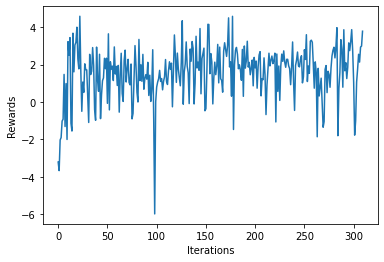

 31%|███████████████████████▎                                                   | 31103/100000 [23:31<47:29, 24.18it/s]

Updated Weights
Mean Reward = 3.038000000000001
11


 31%|███████████████████████▍                                                   | 31201/100000 [23:35<54:55, 20.88it/s]

Updated Weights
Mean Reward = 2.022000000000002
10


 31%|███████████████████████▍                                                   | 31304/100000 [23:39<52:22, 21.86it/s]

Updated Weights
Mean Reward = 2.8790000000000022
13


 31%|███████████████████████▌                                                   | 31403/100000 [23:44<51:03, 22.39it/s]

Updated Weights
Mean Reward = 2.6300000000000012
9


 31%|███████████████████████▌                                                   | 31499/100000 [23:48<57:28, 19.86it/s]

Updated Weights
Mean Reward = 4.012000000000002
22


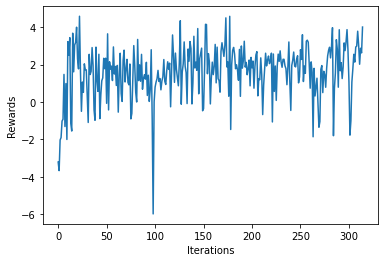

 32%|███████████████████████▋                                                   | 31604/100000 [23:53<46:45, 24.38it/s]

Updated Weights
Mean Reward = 2.485000000000001
28


 32%|███████████████████████▊                                                   | 31703/100000 [23:57<49:57, 22.78it/s]

Updated Weights
Mean Reward = 0.2390000000000015
7


 32%|███████████████████████▊                                                   | 31803/100000 [24:02<47:19, 24.02it/s]

Updated Weights
Mean Reward = 2.290000000000002
8


 32%|███████████████████████▉                                                   | 31902/100000 [24:06<48:13, 23.53it/s]

Updated Weights
Mean Reward = 1.905000000000001
13


 32%|███████████████████████▉                                                   | 31998/100000 [24:10<44:52, 25.26it/s]

Updated Weights
Mean Reward = 2.6420000000000003
15


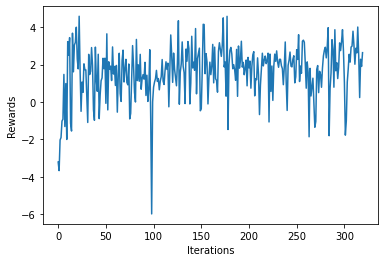

 32%|████████████████████████                                                   | 32103/100000 [24:14<49:22, 22.92it/s]

Updated Weights
Mean Reward = 4.085000000000002
24


 32%|████████████████████████▏                                                  | 32204/100000 [24:18<47:51, 23.61it/s]

Updated Weights
Mean Reward = 2.580000000000002
30


 32%|████████████████████████▏                                                  | 32304/100000 [24:23<50:24, 22.38it/s]

Updated Weights
Mean Reward = 1.9200000000000015
11


 32%|████████████████████████▎                                                  | 32404/100000 [24:27<47:58, 23.49it/s]

Updated Weights
Mean Reward = 2.880000000000002
16


 32%|████████████████████████▎                                                  | 32498/100000 [24:31<46:40, 24.10it/s]

Updated Weights
Mean Reward = 3.421000000000002
20


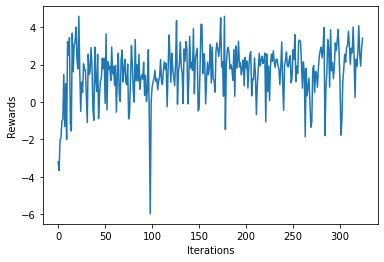

 33%|████████████████████████▍                                                  | 32606/100000 [24:35<39:34, 28.38it/s]

Updated Weights
Mean Reward = 3.4790000000000014
28


 33%|████████████████████████▌                                                  | 32703/100000 [24:39<38:47, 28.91it/s]

Updated Weights
Mean Reward = 3.7990000000000013
33


 33%|████████████████████████▌                                                  | 32803/100000 [24:43<51:24, 21.79it/s]

Updated Weights
Mean Reward = -2.3449999999999984
7


 33%|████████████████████████▋                                                  | 32903/100000 [24:48<46:12, 24.20it/s]

Updated Weights
Mean Reward = 1.8270000000000008
7


 33%|████████████████████████▋                                                  | 32998/100000 [24:52<49:07, 22.73it/s]

Updated Weights
Mean Reward = 2.745
19


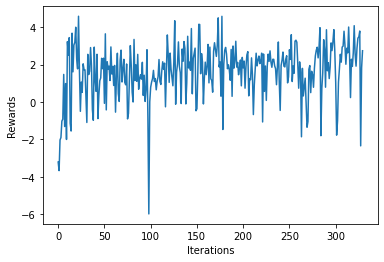

 33%|████████████████████████▊                                                  | 33103/100000 [24:56<45:47, 24.35it/s]

Updated Weights
Mean Reward = 4.331000000000002
23


 33%|████████████████████████▉                                                  | 33206/100000 [25:00<39:44, 28.01it/s]

Updated Weights
Mean Reward = 3.7660000000000013
25


 33%|████████████████████████▉                                                  | 33302/100000 [25:04<45:30, 24.43it/s]

Updated Weights
Mean Reward = 4.4970000000000026
36


 33%|█████████████████████████                                                  | 33402/100000 [25:07<44:15, 25.08it/s]

Updated Weights
Mean Reward = 1.4680000000000009
28


 34%|█████████████████████████▏                                                 | 33500/100000 [25:12<54:41, 20.26it/s]

Updated Weights
Mean Reward = 1.1070000000000009
9


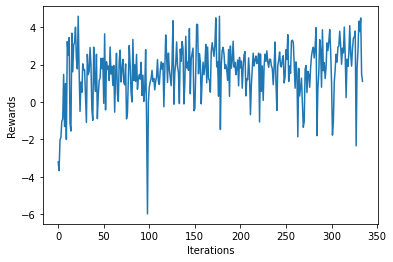

 34%|████████████████████████▌                                                | 33602/100000 [25:18<1:08:45, 16.09it/s]

Updated Weights
Mean Reward = 2.788000000000002
16


 34%|████████████████████████▌                                                | 33702/100000 [25:24<1:13:04, 15.12it/s]

Updated Weights
Mean Reward = 2.9910000000000014
20


 34%|████████████████████████▋                                                | 33803/100000 [25:31<1:05:40, 16.80it/s]

Updated Weights
Mean Reward = 3.312000000000001
22


 34%|████████████████████████▋                                                | 33904/100000 [25:36<1:05:18, 16.87it/s]

Updated Weights
Mean Reward = 3.468000000000002
34


 34%|████████████████████████▊                                                | 34000/100000 [25:42<1:15:57, 14.48it/s]

Updated Weights
Mean Reward = 1.7580000000000018
24


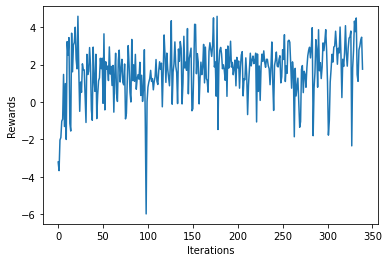

 34%|████████████████████████▉                                                | 34103/100000 [25:49<1:12:52, 15.07it/s]

Updated Weights
Mean Reward = 0.14200000000000176
9


 34%|█████████████████████████▋                                                 | 34205/100000 [25:54<46:28, 23.59it/s]

Updated Weights
Mean Reward = 4.735000000000002
33


 34%|█████████████████████████▋                                                 | 34303/100000 [25:59<59:40, 18.35it/s]

Updated Weights
Mean Reward = 1.976000000000002
21


 34%|█████████████████████████▊                                                 | 34405/100000 [26:04<50:35, 21.61it/s]

Updated Weights
Mean Reward = 1.7750000000000015
8


 34%|█████████████████████████▊                                                 | 34498/100000 [26:08<47:52, 22.80it/s]

Updated Weights
Mean Reward = 2.838000000000002
15


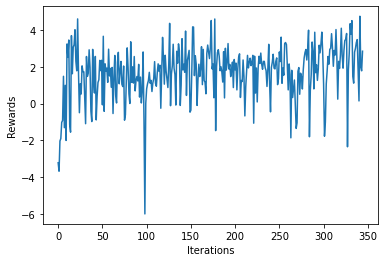

 35%|█████████████████████████▉                                                 | 34604/100000 [26:13<46:13, 23.58it/s]

Updated Weights
Mean Reward = 2.9720000000000018
22


 35%|██████████████████████████                                                 | 34704/100000 [26:17<46:56, 23.19it/s]

Updated Weights
Mean Reward = 3.247000000000001
19


 35%|██████████████████████████                                                 | 34804/100000 [26:21<45:42, 23.77it/s]

Updated Weights
Mean Reward = 4.306000000000001
35


 35%|██████████████████████████▏                                                | 34902/100000 [26:25<45:40, 23.75it/s]

Updated Weights
Mean Reward = 0.304000000000001
15


 35%|██████████████████████████▏                                                | 34998/100000 [26:29<46:24, 23.34it/s]

Updated Weights
Mean Reward = 2.473000000000001
16


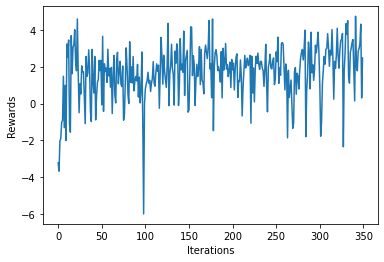

 35%|██████████████████████████▎                                                | 35103/100000 [26:34<47:27, 22.79it/s]

Updated Weights
Mean Reward = 1.0140000000000011
5


 35%|██████████████████████████▍                                                | 35202/100000 [26:38<49:39, 21.75it/s]

Updated Weights
Mean Reward = 1.1230000000000013
3


 35%|██████████████████████████▍                                                | 35302/100000 [26:43<53:14, 20.25it/s]

Updated Weights
Mean Reward = 1.534000000000001
6


 35%|██████████████████████████▌                                                | 35402/100000 [26:47<51:27, 20.92it/s]

Updated Weights
Mean Reward = 1.4100000000000024
9


 36%|██████████████████████████▋                                                | 35500/100000 [26:52<44:47, 24.00it/s]

Updated Weights
Mean Reward = 2.991000000000001
15


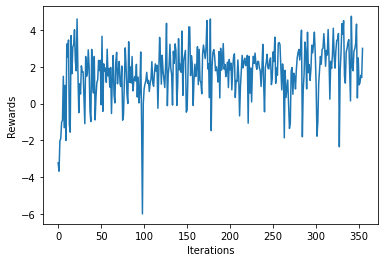

 36%|██████████████████████████▋                                                | 35605/100000 [26:57<51:10, 20.97it/s]

Updated Weights
Mean Reward = 2.633000000000002
11


 36%|██████████████████████████▊                                                | 35704/100000 [27:02<47:59, 22.33it/s]

Updated Weights
Mean Reward = 2.5560000000000014
10


 36%|██████████████████████████▊                                                | 35805/100000 [27:07<40:27, 26.45it/s]

Updated Weights
Mean Reward = 2.5340000000000007
12


 36%|██████████████████████████▉                                                | 35903/100000 [27:11<44:12, 24.17it/s]

Updated Weights
Mean Reward = 2.8240000000000016
16


 36%|██████████████████████████▉                                                | 35998/100000 [27:15<42:50, 24.90it/s]

Updated Weights
Mean Reward = 3.512000000000001
20


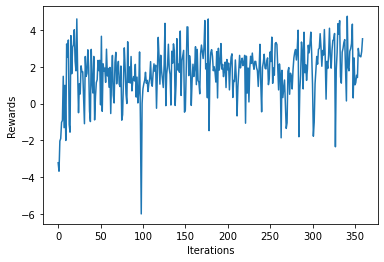

 36%|███████████████████████████                                                | 36105/100000 [27:19<43:51, 24.28it/s]

Updated Weights
Mean Reward = 3.873000000000001
20


 36%|███████████████████████████▏                                               | 36203/100000 [27:23<42:20, 25.11it/s]

Updated Weights
Mean Reward = 4.141000000000002
32


 36%|███████████████████████████▏                                               | 36302/100000 [27:27<46:10, 23.00it/s]

Updated Weights
Mean Reward = 2.141000000000001
21


 36%|███████████████████████████▎                                               | 36402/100000 [27:32<50:11, 21.12it/s]

Updated Weights
Mean Reward = 1.5600000000000016
10


 36%|███████████████████████████▍                                               | 36500/100000 [27:36<41:50, 25.29it/s]

Updated Weights
Mean Reward = 4.253000000000002
27


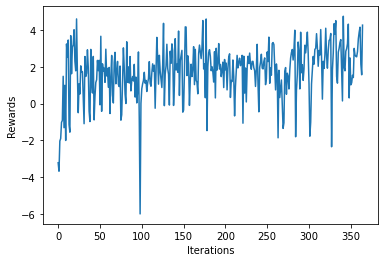

 37%|███████████████████████████▍                                               | 36605/100000 [27:40<44:29, 23.74it/s]

Updated Weights
Mean Reward = 3.7740000000000014
28


 37%|██████████████████████████▊                                              | 36703/100000 [27:45<1:02:55, 16.76it/s]

Updated Weights
Mean Reward = 3.8030000000000017
37


 37%|██████████████████████████▊                                              | 36802/100000 [27:51<1:09:14, 15.21it/s]

Updated Weights
Mean Reward = 0.3820000000000012
9


 37%|██████████████████████████▉                                              | 36902/100000 [27:57<1:00:29, 17.38it/s]

Updated Weights
Mean Reward = 1.726000000000001
10


 37%|███████████████████████████▊                                               | 37000/100000 [28:03<55:26, 18.94it/s]

Updated Weights
Mean Reward = 3.2000000000000015
19


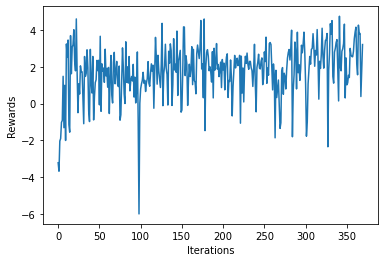

 37%|███████████████████████████                                              | 37104/100000 [28:09<1:00:25, 17.35it/s]

Updated Weights
Mean Reward = 1.100000000000002
13


 37%|███████████████████████████▉                                               | 37205/100000 [28:14<41:55, 24.96it/s]

Updated Weights
Mean Reward = 3.782000000000002
25


 37%|███████████████████████████▉                                               | 37303/100000 [28:18<45:53, 22.77it/s]

Updated Weights
Mean Reward = 3.268000000000001
26


 37%|████████████████████████████                                               | 37404/100000 [28:22<48:58, 21.30it/s]

Updated Weights
Mean Reward = -0.7399999999999991
24


 37%|████████████████████████████                                               | 37498/100000 [28:27<48:23, 21.52it/s]

Updated Weights
Mean Reward = 0.4660000000000013
7


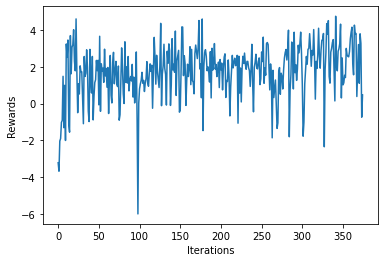

 38%|████████████████████████████▏                                              | 37603/100000 [28:31<47:24, 21.94it/s]

Updated Weights
Mean Reward = 1.759000000000001
8


 38%|████████████████████████████▎                                              | 37703/100000 [28:36<45:09, 22.99it/s]

Updated Weights
Mean Reward = 1.3370000000000013
3


 38%|████████████████████████████▎                                              | 37805/100000 [28:40<47:44, 21.71it/s]

Updated Weights
Mean Reward = 1.4280000000000013
6


 38%|████████████████████████████▍                                              | 37902/100000 [28:45<46:17, 22.36it/s]

Updated Weights
Mean Reward = 2.2830000000000013
10


 38%|████████████████████████████▌                                              | 38000/100000 [28:49<47:09, 21.91it/s]

Updated Weights
Mean Reward = 1.3470000000000015
8


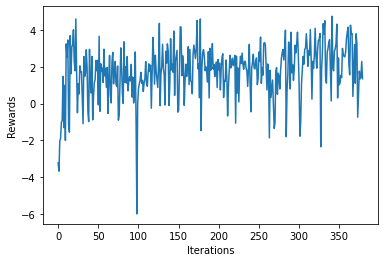

 38%|████████████████████████████▌                                              | 38105/100000 [28:54<38:38, 26.69it/s]

Updated Weights
Mean Reward = 1.9440000000000015
8


 38%|████████████████████████████▋                                              | 38204/100000 [28:58<39:51, 25.84it/s]

Updated Weights
Mean Reward = 2.5010000000000017
9


 38%|████████████████████████████▋                                              | 38303/100000 [29:03<58:04, 17.71it/s]

Updated Weights
Mean Reward = 2.8680000000000017
10


 38%|████████████████████████████▊                                              | 38404/100000 [29:08<45:45, 22.43it/s]

Updated Weights
Mean Reward = 2.2410000000000023
9


 38%|████████████████████████████▉                                              | 38500/100000 [29:12<40:38, 25.22it/s]

Updated Weights
Mean Reward = 4.128000000000001
23


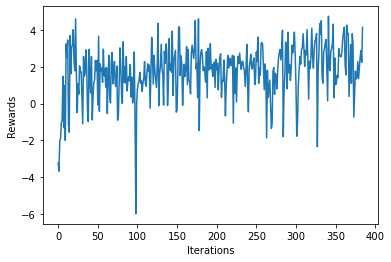

 39%|████████████████████████████▉                                              | 38605/100000 [29:16<46:16, 22.12it/s]

Updated Weights
Mean Reward = 2.083000000000001
6


 39%|█████████████████████████████                                              | 38705/100000 [29:21<42:17, 24.16it/s]

Updated Weights
Mean Reward = 1.527000000000001
18


 39%|█████████████████████████████                                              | 38804/100000 [29:25<39:05, 26.09it/s]

Updated Weights
Mean Reward = 4.4620000000000015
20


 39%|█████████████████████████████▏                                             | 38903/100000 [29:29<40:36, 25.07it/s]

Updated Weights
Mean Reward = 4.0550000000000015
23


 39%|█████████████████████████████▎                                             | 39000/100000 [29:33<41:07, 24.72it/s]

Updated Weights
Mean Reward = 4.514000000000002
26


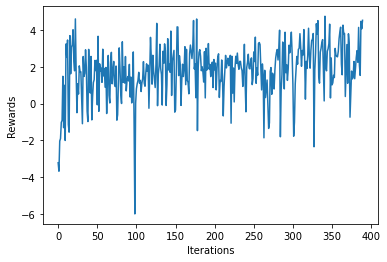

 39%|█████████████████████████████▎                                             | 39106/100000 [29:37<34:51, 29.12it/s]

Updated Weights
Mean Reward = 3.5730000000000013
22


 39%|█████████████████████████████▍                                             | 39204/100000 [29:41<32:57, 30.75it/s]

Updated Weights
Mean Reward = 4.425000000000002
33


 39%|█████████████████████████████▍                                             | 39305/100000 [29:45<43:07, 23.45it/s]

Updated Weights
Mean Reward = 2.0210000000000012
23


 39%|█████████████████████████████▌                                             | 39404/100000 [29:49<44:33, 22.67it/s]

Updated Weights
Mean Reward = 5.010000000000002
34


 40%|█████████████████████████████▋                                             | 39500/100000 [29:53<45:37, 22.10it/s]

Updated Weights
Mean Reward = 2.0480000000000014
18


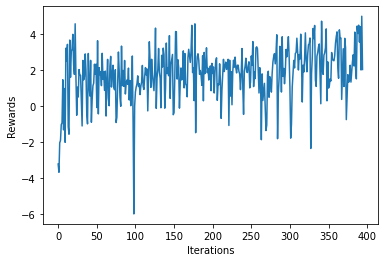

 40%|█████████████████████████████▋                                             | 39607/100000 [29:57<39:21, 25.58it/s]

Updated Weights
Mean Reward = 3.9490000000000016
24


 40%|█████████████████████████████▊                                             | 39704/100000 [30:01<42:04, 23.89it/s]

Updated Weights
Mean Reward = 4.360000000000002
35


 40%|█████████████████████████████▊                                             | 39803/100000 [30:05<45:49, 21.90it/s]

Updated Weights
Mean Reward = 2.1180000000000017
23


 40%|█████████████████████████████▉                                             | 39904/100000 [30:09<37:29, 26.72it/s]

Updated Weights
Mean Reward = 2.471000000000002
15


 40%|██████████████████████████████                                             | 40000/100000 [30:13<38:09, 26.21it/s]

Updated Weights
Mean Reward = 3.780000000000001
28


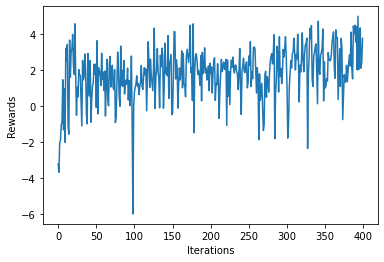

 40%|██████████████████████████████                                             | 40103/100000 [30:18<47:38, 20.95it/s]

Updated Weights
Mean Reward = 1.913000000000002
14


 40%|██████████████████████████████▏                                            | 40203/100000 [30:23<43:30, 22.91it/s]

Updated Weights
Mean Reward = 2.959000000000001
15


 40%|██████████████████████████████▏                                            | 40302/100000 [30:27<41:44, 23.84it/s]

Updated Weights
Mean Reward = 3.552000000000001
30


 40%|██████████████████████████████▎                                            | 40404/100000 [30:31<47:46, 20.79it/s]

Updated Weights
Mean Reward = 2.7460000000000013
26


 40%|██████████████████████████████▎                                            | 40499/100000 [30:36<48:00, 20.65it/s]

Updated Weights
Mean Reward = 3.917000000000001
34


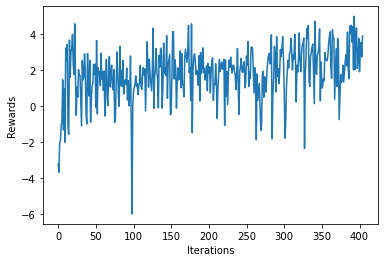

 41%|██████████████████████████████▍                                            | 40603/100000 [30:42<59:47, 16.56it/s]

Updated Weights
Mean Reward = 1.6320000000000017
14


 41%|██████████████████████████████▌                                            | 40703/100000 [30:47<54:38, 18.08it/s]

Updated Weights
Mean Reward = 5.311000000000003
34


 41%|█████████████████████████████▊                                           | 40804/100000 [30:53<1:00:29, 16.31it/s]

Updated Weights
Mean Reward = 1.4980000000000013
21


 41%|██████████████████████████████▋                                            | 40903/100000 [30:58<59:53, 16.45it/s]

Updated Weights
Mean Reward = 2.692000000000001
13


 41%|██████████████████████████████▋                                            | 41000/100000 [31:04<57:31, 17.09it/s]

Updated Weights
Mean Reward = 3.2510000000000012
14


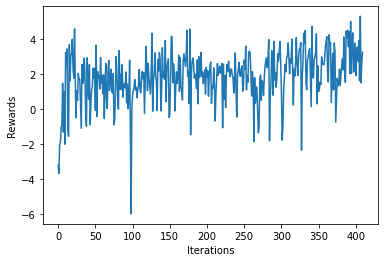

 41%|██████████████████████████████▊                                            | 41104/100000 [31:10<56:15, 17.45it/s]

Updated Weights
Mean Reward = 2.551000000000001
14


 41%|██████████████████████████████                                           | 41203/100000 [31:16<1:00:53, 16.09it/s]

Updated Weights
Mean Reward = 2.9410000000000007
16


 41%|██████████████████████████████▉                                            | 41305/100000 [31:20<39:36, 24.69it/s]

Updated Weights
Mean Reward = 5.0360000000000005
34


 41%|███████████████████████████████                                            | 41405/100000 [31:24<36:53, 26.47it/s]

Updated Weights
Mean Reward = 4.047000000000002
32


 42%|███████████████████████████████▏                                           | 41500/100000 [31:27<31:43, 30.73it/s]

Updated Weights
Mean Reward = 4.605
34


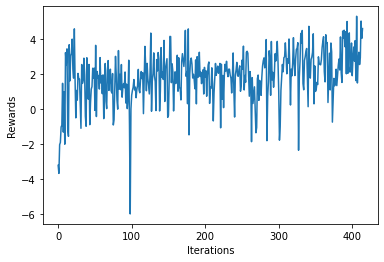

 42%|███████████████████████████████▏                                           | 41605/100000 [31:31<39:27, 24.67it/s]

Updated Weights
Mean Reward = 3.751000000000001
30


 42%|███████████████████████████████▎                                           | 41705/100000 [31:35<42:12, 23.02it/s]

Updated Weights
Mean Reward = 2.3350000000000017
14


 42%|███████████████████████████████▎                                           | 41804/100000 [31:39<39:09, 24.77it/s]

Updated Weights
Mean Reward = 4.4060000000000015
30


 42%|███████████████████████████████▍                                           | 41906/100000 [31:43<36:48, 26.31it/s]

Updated Weights
Mean Reward = 3.8310000000000017
29


 42%|███████████████████████████████▍                                           | 41997/100000 [31:46<30:31, 31.67it/s]

Updated Weights
Mean Reward = 4.357000000000002
36


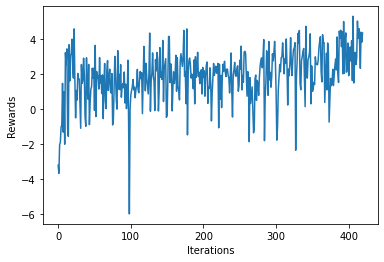

 42%|███████████████████████████████▌                                           | 42103/100000 [31:51<42:27, 22.73it/s]

Updated Weights
Mean Reward = -2.866999999999999
12


 42%|███████████████████████████████▋                                           | 42203/100000 [31:56<38:29, 25.02it/s]

Updated Weights
Mean Reward = -0.39399999999999946
9


 42%|███████████████████████████████▋                                           | 42304/100000 [32:00<43:13, 22.25it/s]

Updated Weights
Mean Reward = 1.6870000000000007
12


 42%|███████████████████████████████▊                                           | 42406/100000 [32:04<45:53, 20.91it/s]

Updated Weights
Mean Reward = 1.8540000000000012
15


 42%|███████████████████████████████▊                                           | 42497/100000 [32:09<44:59, 21.30it/s]

Updated Weights
Mean Reward = 2.1740000000000013
11


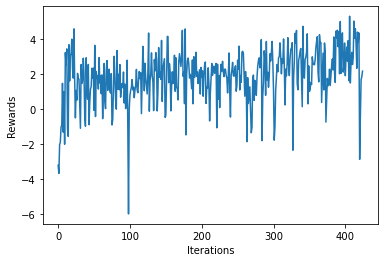

 43%|███████████████████████████████▉                                           | 42602/100000 [32:13<45:36, 20.97it/s]

Updated Weights
Mean Reward = 1.8120000000000005
10


 43%|████████████████████████████████                                           | 42703/100000 [32:18<42:02, 22.71it/s]

Updated Weights
Mean Reward = 3.0810000000000004
17


 43%|████████████████████████████████                                           | 42803/100000 [32:22<42:49, 22.26it/s]

Updated Weights
Mean Reward = 3.8200000000000016
22


 43%|████████████████████████████████▏                                          | 42904/100000 [32:26<44:07, 21.57it/s]

Updated Weights
Mean Reward = 2.2750000000000017
11


 43%|████████████████████████████████▏                                          | 42999/100000 [32:30<30:22, 31.28it/s]

Updated Weights
Mean Reward = 5.769000000000001
37


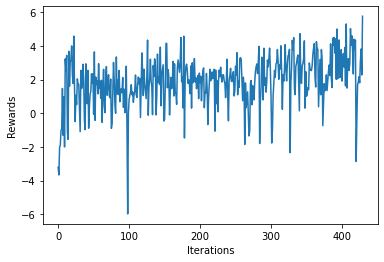

 43%|████████████████████████████████▎                                          | 43106/100000 [32:34<35:11, 26.94it/s]

Updated Weights
Mean Reward = 4.590000000000002
32


 43%|████████████████████████████████▍                                          | 43203/100000 [32:38<42:58, 22.02it/s]

Updated Weights
Mean Reward = 3.471000000000002
25


 43%|████████████████████████████████▍                                          | 43304/100000 [32:42<38:58, 24.25it/s]

Updated Weights
Mean Reward = 3.186000000000001
25


 43%|████████████████████████████████▌                                          | 43404/100000 [32:46<38:26, 24.54it/s]

Updated Weights
Mean Reward = 4.687000000000001
37


 43%|████████████████████████████████▌                                          | 43498/100000 [32:50<37:03, 25.41it/s]

Updated Weights
Mean Reward = 2.0750000000000024
22


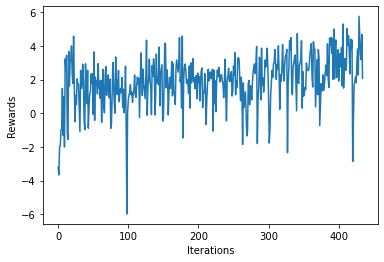

 44%|████████████████████████████████▋                                          | 43603/100000 [32:54<43:10, 21.77it/s]

Updated Weights
Mean Reward = 2.911000000000002
19


 44%|████████████████████████████████▊                                          | 43703/100000 [32:59<45:31, 20.61it/s]

Updated Weights
Mean Reward = 3.762000000000001
23


 44%|████████████████████████████████▊                                          | 43803/100000 [33:02<30:48, 30.39it/s]

Updated Weights
Mean Reward = 5.218000000000002
34


 44%|████████████████████████████████▉                                          | 43904/100000 [33:07<42:28, 22.01it/s]

Updated Weights
Mean Reward = 1.8570000000000013
20


 44%|████████████████████████████████▉                                          | 43999/100000 [33:11<40:16, 23.18it/s]

Updated Weights
Mean Reward = 2.107000000000001
13


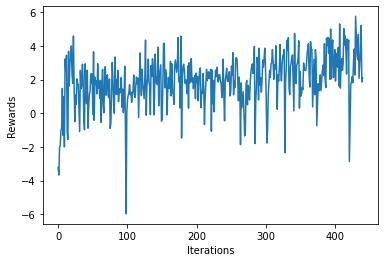

 44%|█████████████████████████████████                                          | 44102/100000 [33:15<38:33, 24.16it/s]

Updated Weights
Mean Reward = 2.4220000000000015
15


 44%|█████████████████████████████████▏                                         | 44204/100000 [33:20<39:48, 23.36it/s]

Updated Weights
Mean Reward = 2.5670000000000006
16


 44%|█████████████████████████████████▏                                         | 44305/100000 [33:24<41:29, 22.37it/s]

Updated Weights
Mean Reward = 3.015000000000002
17


 44%|█████████████████████████████████▎                                         | 44408/100000 [33:28<36:01, 25.72it/s]

Updated Weights
Mean Reward = 3.4180000000000006
20


 44%|█████████████████████████████████▎                                         | 44498/100000 [33:32<40:51, 22.64it/s]

Updated Weights
Mean Reward = 2.6260000000000012
15


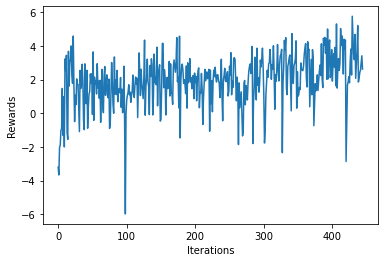

 45%|█████████████████████████████████▍                                         | 44606/100000 [33:37<36:53, 25.03it/s]

Updated Weights
Mean Reward = 2.4220000000000015
17


 45%|█████████████████████████████████▌                                         | 44705/100000 [33:41<38:45, 23.78it/s]

Updated Weights
Mean Reward = 2.860000000000001
15


 45%|█████████████████████████████████▌                                         | 44804/100000 [33:45<41:08, 22.36it/s]

Updated Weights
Mean Reward = 1.7150000000000012
8


 45%|█████████████████████████████████▋                                         | 44903/100000 [33:50<40:44, 22.54it/s]

Updated Weights
Mean Reward = 3.4800000000000018
14


 45%|█████████████████████████████████▋                                         | 44999/100000 [33:54<42:37, 21.50it/s]

Updated Weights
Mean Reward = 0.7920000000000011
8


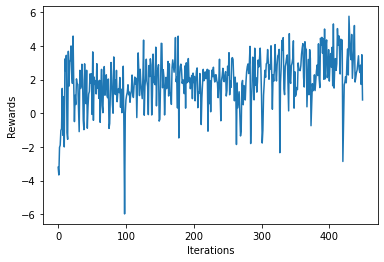

 45%|█████████████████████████████████▊                                         | 45105/100000 [33:59<37:08, 24.64it/s]

Updated Weights
Mean Reward = 0.5430000000000013
8


 45%|█████████████████████████████████▉                                         | 45204/100000 [34:03<39:03, 23.38it/s]

Updated Weights
Mean Reward = 3.6420000000000026
18


 45%|█████████████████████████████████▉                                         | 45303/100000 [34:08<41:53, 21.76it/s]

Updated Weights
Mean Reward = 2.5340000000000025
11


 45%|██████████████████████████████████                                         | 45403/100000 [34:12<40:54, 22.24it/s]

Updated Weights
Mean Reward = 2.9860000000000024
12


 45%|██████████████████████████████████                                         | 45498/100000 [34:16<36:13, 25.08it/s]

Updated Weights
Mean Reward = 4.423000000000003
19


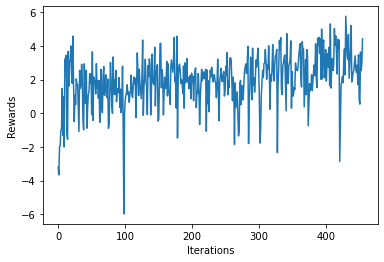

 46%|██████████████████████████████████▏                                        | 45602/100000 [34:21<41:30, 21.84it/s]

Updated Weights
Mean Reward = 2.1980000000000013
10


 46%|██████████████████████████████████▎                                        | 45706/100000 [34:26<35:24, 25.55it/s]

Updated Weights
Mean Reward = 2.411000000000002
9


 46%|██████████████████████████████████▎                                        | 45803/100000 [34:30<39:44, 22.73it/s]

Updated Weights
Mean Reward = 3.9040000000000017
15


 46%|██████████████████████████████████▍                                        | 45906/100000 [34:34<36:39, 24.59it/s]

Updated Weights
Mean Reward = 2.640000000000001
13


 46%|██████████████████████████████████▍                                        | 45999/100000 [34:38<37:45, 23.83it/s]

Updated Weights
Mean Reward = 3.2900000000000023
14


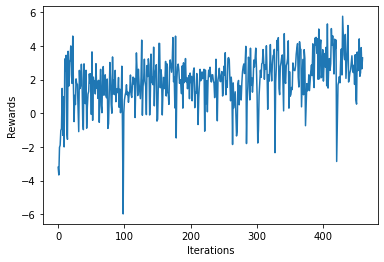

 46%|██████████████████████████████████▌                                        | 46104/100000 [34:43<41:21, 21.72it/s]

Updated Weights
Mean Reward = 2.148000000000001
9


 46%|██████████████████████████████████▋                                        | 46204/100000 [34:48<39:40, 22.60it/s]

Updated Weights
Mean Reward = 1.021000000000001
9


 46%|██████████████████████████████████▋                                        | 46303/100000 [34:52<41:27, 21.58it/s]

Updated Weights
Mean Reward = 1.3950000000000011
6


 46%|██████████████████████████████████▊                                        | 46405/100000 [34:57<38:34, 23.16it/s]

Updated Weights
Mean Reward = 2.1550000000000025
5


 46%|██████████████████████████████████▉                                        | 46500/100000 [35:01<37:15, 23.93it/s]

Updated Weights
Mean Reward = 1.3840000000000012
11


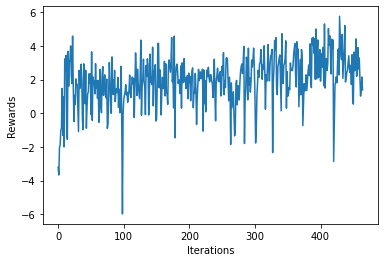

 47%|██████████████████████████████████▉                                        | 46605/100000 [35:06<41:31, 21.43it/s]

Updated Weights
Mean Reward = -0.12299999999999917
4


 47%|███████████████████████████████████                                        | 46704/100000 [35:11<41:11, 21.56it/s]

Updated Weights
Mean Reward = -2.084999999999998
8


 47%|███████████████████████████████████                                        | 46805/100000 [35:15<39:41, 22.34it/s]

Updated Weights
Mean Reward = -4.809999999999999
13


 47%|███████████████████████████████████▏                                       | 46903/100000 [35:19<40:32, 21.83it/s]

Updated Weights
Mean Reward = -6.816
16


 47%|███████████████████████████████████▏                                       | 46998/100000 [35:23<34:53, 25.32it/s]

Updated Weights
Mean Reward = 0.18900000000000106
23


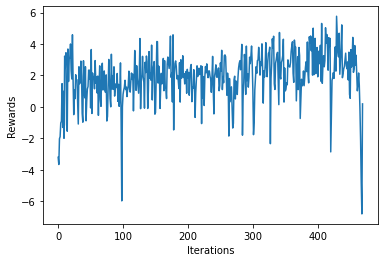

 47%|███████████████████████████████████▎                                       | 47104/100000 [35:27<27:00, 32.65it/s]

Updated Weights
Mean Reward = 2.7560000000000007
31


 47%|███████████████████████████████████▍                                       | 47205/100000 [35:31<29:48, 29.51it/s]

Updated Weights
Mean Reward = 2.389000000000001
30


 47%|███████████████████████████████████▍                                       | 47308/100000 [35:35<29:02, 30.25it/s]

Updated Weights
Mean Reward = 2.9870000000000005
36


 47%|███████████████████████████████████▌                                       | 47406/100000 [35:38<32:14, 27.18it/s]

Updated Weights
Mean Reward = 3.789
34


 47%|███████████████████████████████████▌                                       | 47499/100000 [35:42<25:50, 33.86it/s]

Updated Weights
Mean Reward = 3.079000000000001
32


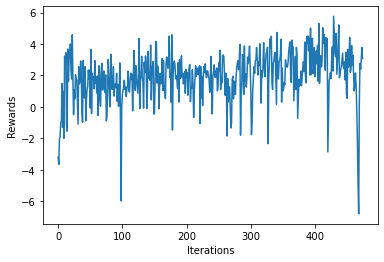

 48%|███████████████████████████████████▋                                       | 47603/100000 [35:46<34:30, 25.31it/s]

Updated Weights
Mean Reward = 3.1160000000000014
24


 48%|███████████████████████████████████▊                                       | 47706/100000 [35:50<34:46, 25.06it/s]

Updated Weights
Mean Reward = 3.0670000000000006
23


 48%|███████████████████████████████████▊                                       | 47805/100000 [35:54<27:02, 32.16it/s]

Updated Weights
Mean Reward = 4.183000000000001
27


 48%|███████████████████████████████████▉                                       | 47904/100000 [35:58<39:26, 22.01it/s]

Updated Weights
Mean Reward = 0.9060000000000008
19


 48%|███████████████████████████████████▉                                       | 47999/100000 [36:03<35:55, 24.12it/s]

Updated Weights
Mean Reward = 3.3050000000000015
15


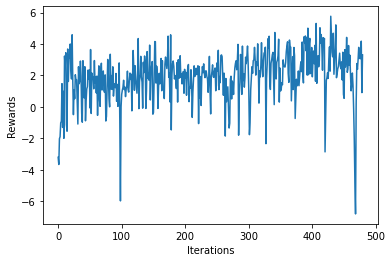

 48%|████████████████████████████████████                                       | 48105/100000 [36:07<30:25, 28.44it/s]

Updated Weights
Mean Reward = 3.4260000000000006
18


 48%|████████████████████████████████████▏                                      | 48204/100000 [36:11<35:26, 24.36it/s]

Updated Weights
Mean Reward = 4.157000000000001
26


 48%|████████████████████████████████████▏                                      | 48303/100000 [36:15<39:18, 21.92it/s]

Updated Weights
Mean Reward = 3.452000000000001
17


 48%|████████████████████████████████████▎                                      | 48405/100000 [36:20<32:23, 26.55it/s]

Updated Weights
Mean Reward = 2.5930000000000013
13


 48%|████████████████████████████████████▎                                      | 48499/100000 [36:24<39:44, 21.60it/s]

Updated Weights
Mean Reward = 2.3620000000000014
11


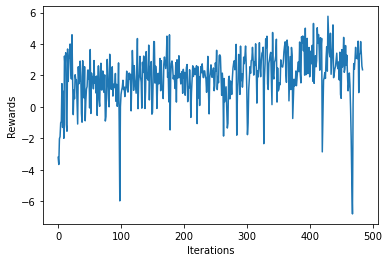

 49%|████████████████████████████████████▍                                      | 48603/100000 [36:29<37:55, 22.59it/s]

Updated Weights
Mean Reward = 1.8670000000000013
13


 49%|████████████████████████████████████▌                                      | 48702/100000 [36:33<38:18, 22.32it/s]

Updated Weights
Mean Reward = 1.9910000000000017
8


 49%|████████████████████████████████████▌                                      | 48806/100000 [36:37<28:12, 30.25it/s]

Updated Weights
Mean Reward = 6.286000000000002
35


 49%|████████████████████████████████████▋                                      | 48902/100000 [36:41<38:48, 21.95it/s]

Updated Weights
Mean Reward = 1.608000000000001
18


 49%|████████████████████████████████████▊                                      | 49000/100000 [36:45<33:48, 25.14it/s]

Updated Weights
Mean Reward = 3.5410000000000026
19


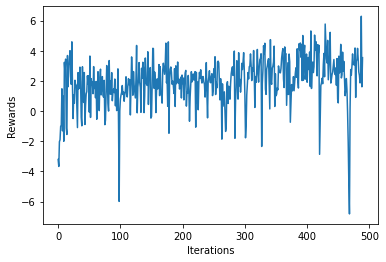

 49%|████████████████████████████████████▊                                      | 49103/100000 [36:49<36:57, 22.95it/s]

Updated Weights
Mean Reward = 5.544000000000002
32


 49%|████████████████████████████████████▉                                      | 49205/100000 [36:53<37:00, 22.87it/s]

Updated Weights
Mean Reward = 3.498000000000001
17


 49%|████████████████████████████████████▉                                      | 49304/100000 [36:57<33:04, 25.55it/s]

Updated Weights
Mean Reward = 4.388000000000003
34


 49%|█████████████████████████████████████                                      | 49403/100000 [37:01<33:06, 25.47it/s]

Updated Weights
Mean Reward = 4.300000000000001
31


 50%|█████████████████████████████████████▏                                     | 49500/100000 [37:05<35:14, 23.89it/s]

Updated Weights
Mean Reward = 2.4040000000000012
20


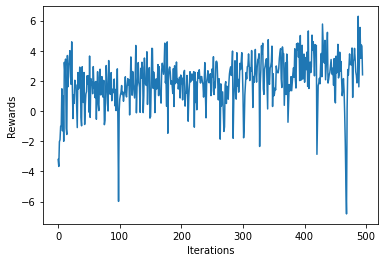

 50%|█████████████████████████████████████▏                                     | 49605/100000 [37:09<34:13, 24.54it/s]

Updated Weights
Mean Reward = 2.150000000000002
8


 50%|█████████████████████████████████████▎                                     | 49706/100000 [37:14<35:41, 23.49it/s]

Updated Weights
Mean Reward = 3.1380000000000017
13


 50%|█████████████████████████████████████▎                                     | 49806/100000 [37:18<32:10, 26.00it/s]

Updated Weights
Mean Reward = 5.004000000000002
30


 50%|█████████████████████████████████████▍                                     | 49906/100000 [37:22<30:51, 27.05it/s]

Updated Weights
Mean Reward = 3.611000000000002
26


 50%|█████████████████████████████████████▍                                     | 49999/100000 [37:25<33:37, 24.78it/s]

Updated Weights
Mean Reward = 5.556000000000003
35


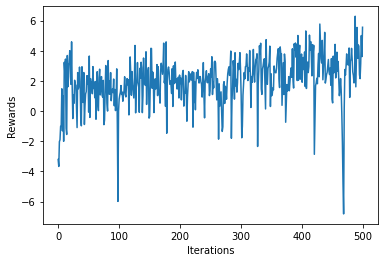

 50%|█████████████████████████████████████▌                                     | 50103/100000 [37:30<34:57, 23.79it/s]

Updated Weights
Mean Reward = 3.5230000000000015
29


 50%|█████████████████████████████████████▋                                     | 50204/100000 [37:35<40:56, 20.27it/s]

Updated Weights
Mean Reward = 4.034000000000001
29


 50%|█████████████████████████████████████▋                                     | 50304/100000 [37:40<37:30, 22.08it/s]

Updated Weights
Mean Reward = 0.534000000000001
6


 50%|█████████████████████████████████████▊                                     | 50404/100000 [37:43<28:46, 28.73it/s]

Updated Weights
Mean Reward = 5.497000000000001
35


 50%|█████████████████████████████████████▉                                     | 50500/100000 [37:48<36:14, 22.76it/s]

Updated Weights
Mean Reward = 1.486000000000001
16


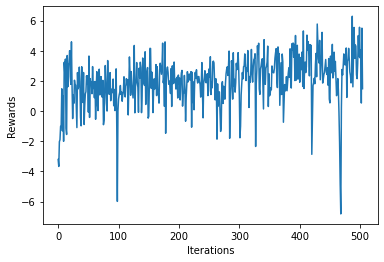

 51%|█████████████████████████████████████▉                                     | 50603/100000 [37:52<43:18, 19.01it/s]

Updated Weights
Mean Reward = 3.0470000000000006
19


 51%|██████████████████████████████████████                                     | 50703/100000 [37:57<34:03, 24.13it/s]

Updated Weights
Mean Reward = 1.6620000000000013
12


 51%|██████████████████████████████████████                                     | 50803/100000 [38:02<45:54, 17.86it/s]

Updated Weights
Mean Reward = 3.0530000000000013
17


 51%|██████████████████████████████████████▏                                    | 50904/100000 [38:06<36:16, 22.56it/s]

Updated Weights
Mean Reward = 3.537000000000002
16


 51%|██████████████████████████████████████▎                                    | 51000/100000 [38:11<41:05, 19.87it/s]

Updated Weights
Mean Reward = 3.754000000000001
17


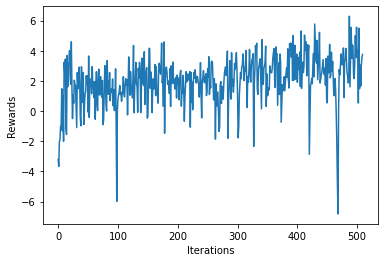

 51%|██████████████████████████████████████▎                                    | 51102/100000 [38:16<34:39, 23.52it/s]

Updated Weights
Mean Reward = 4.115000000000002
22


 51%|██████████████████████████████████████▍                                    | 51203/100000 [38:20<37:34, 21.64it/s]

Updated Weights
Mean Reward = 4.219000000000001
23


 51%|██████████████████████████████████████▍                                    | 51304/100000 [38:24<37:35, 21.59it/s]

Updated Weights
Mean Reward = 3.8750000000000018
22


 51%|██████████████████████████████████████▌                                    | 51404/100000 [38:28<38:01, 21.30it/s]

Updated Weights
Mean Reward = 1.9630000000000016
13


 51%|██████████████████████████████████████▌                                    | 51499/100000 [38:32<34:50, 23.20it/s]

Updated Weights
Mean Reward = 4.725000000000001
24


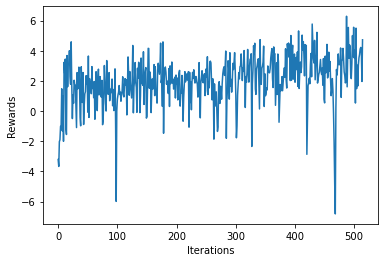

 52%|██████████████████████████████████████▋                                    | 51604/100000 [38:37<35:19, 22.83it/s]

Updated Weights
Mean Reward = 4.061000000000001
22


 52%|██████████████████████████████████████▊                                    | 51703/100000 [38:41<35:25, 22.72it/s]

Updated Weights
Mean Reward = 3.1810000000000014
11


 52%|██████████████████████████████████████▊                                    | 51804/100000 [38:46<36:24, 22.06it/s]

Updated Weights
Mean Reward = 3.8010000000000015
13


 52%|██████████████████████████████████████▉                                    | 51905/100000 [38:50<32:24, 24.74it/s]

Updated Weights
Mean Reward = 4.177000000000001
24


 52%|██████████████████████████████████████▉                                    | 51998/100000 [38:54<35:32, 22.51it/s]

Updated Weights
Mean Reward = 3.6860000000000017
17


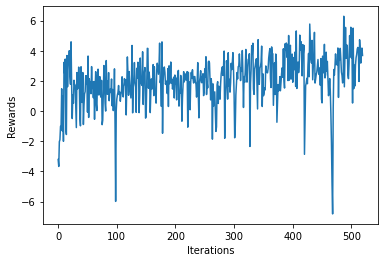

 52%|███████████████████████████████████████                                    | 52105/100000 [38:58<31:45, 25.14it/s]

Updated Weights
Mean Reward = 5.029000000000003
23


 52%|███████████████████████████████████████▏                                   | 52204/100000 [39:02<34:17, 23.23it/s]

Updated Weights
Mean Reward = 4.332000000000002
29


 52%|███████████████████████████████████████▏                                   | 52302/100000 [39:07<34:59, 22.72it/s]

Updated Weights
Mean Reward = 1.8360000000000016
16


 52%|███████████████████████████████████████▎                                   | 52402/100000 [39:11<34:57, 22.70it/s]

Updated Weights
Mean Reward = 4.269000000000001
24


 52%|███████████████████████████████████████▎                                   | 52498/100000 [39:15<33:05, 23.92it/s]

Updated Weights
Mean Reward = 2.7460000000000018
21


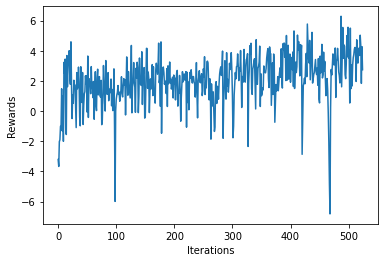

 53%|███████████████████████████████████████▍                                   | 52603/100000 [39:19<33:34, 23.53it/s]

Updated Weights
Mean Reward = 4.312000000000001
26


 53%|███████████████████████████████████████▌                                   | 52705/100000 [39:23<31:25, 25.08it/s]

Updated Weights
Mean Reward = 5.748000000000003
31


 53%|███████████████████████████████████████▌                                   | 52801/100000 [39:27<26:17, 29.92it/s]

Updated Weights
Mean Reward = 4.918000000000001
32


 53%|███████████████████████████████████████▋                                   | 52902/100000 [39:31<36:11, 21.68it/s]

Updated Weights
Mean Reward = -1.1029999999999984
8


 53%|███████████████████████████████████████▊                                   | 53000/100000 [39:36<34:43, 22.55it/s]

Updated Weights
Mean Reward = 3.170000000000002
13


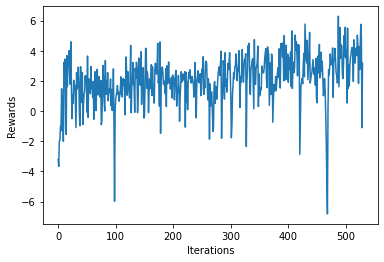

 53%|███████████████████████████████████████▊                                   | 53104/100000 [39:40<35:02, 22.31it/s]

Updated Weights
Mean Reward = 2.7960000000000025
13


 53%|███████████████████████████████████████▉                                   | 53203/100000 [39:44<30:55, 25.22it/s]

Updated Weights
Mean Reward = 4.305000000000002
21


 53%|███████████████████████████████████████▉                                   | 53304/100000 [39:48<25:45, 30.21it/s]

Updated Weights
Mean Reward = 4.270000000000001
22


 53%|████████████████████████████████████████                                   | 53404/100000 [39:53<32:45, 23.71it/s]

Updated Weights
Mean Reward = 3.1040000000000014
15


 53%|████████████████████████████████████████                                   | 53498/100000 [39:56<32:00, 24.22it/s]

Updated Weights
Mean Reward = 5.3370000000000015
34


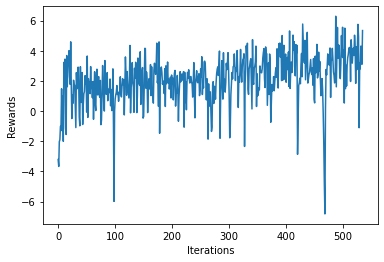

 54%|████████████████████████████████████████▏                                  | 53602/100000 [40:01<31:57, 24.20it/s]

Updated Weights
Mean Reward = 4.152000000000002
25


 54%|████████████████████████████████████████▎                                  | 53704/100000 [40:05<31:05, 24.82it/s]

Updated Weights
Mean Reward = 3.0260000000000016
18


 54%|████████████████████████████████████████▎                                  | 53804/100000 [40:09<33:29, 22.98it/s]

Updated Weights
Mean Reward = 2.984000000000002
18


 54%|████████████████████████████████████████▍                                  | 53905/100000 [40:14<32:18, 23.78it/s]

Updated Weights
Mean Reward = 4.645000000000001
24


 54%|████████████████████████████████████████▌                                  | 54000/100000 [40:17<34:33, 22.19it/s]

Updated Weights
Mean Reward = 4.3370000000000015
25


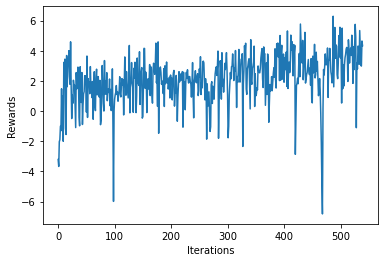

 54%|████████████████████████████████████████▌                                  | 54102/100000 [40:21<26:11, 29.21it/s]

Updated Weights
Mean Reward = 6.512000000000001
39


 54%|████████████████████████████████████████▋                                  | 54206/100000 [40:25<30:48, 24.78it/s]

Updated Weights
Mean Reward = 5.038000000000002
27


 54%|████████████████████████████████████████▋                                  | 54305/100000 [40:29<27:34, 27.62it/s]

Updated Weights
Mean Reward = 4.206
28


 54%|████████████████████████████████████████▊                                  | 54403/100000 [40:33<31:36, 24.04it/s]

Updated Weights
Mean Reward = 4.088000000000001
31


 55%|████████████████████████████████████████▉                                  | 54500/100000 [40:37<27:12, 27.87it/s]

Updated Weights
Mean Reward = 4.310000000000001
31


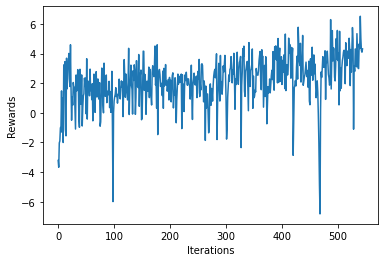

 55%|████████████████████████████████████████▉                                  | 54603/100000 [40:41<34:52, 21.69it/s]

Updated Weights
Mean Reward = 2.6130000000000013
26


 55%|█████████████████████████████████████████                                  | 54703/100000 [40:45<27:26, 27.51it/s]

Updated Weights
Mean Reward = 5.226000000000002
33


 55%|█████████████████████████████████████████                                  | 54802/100000 [40:49<28:20, 26.58it/s]

Updated Weights
Mean Reward = 5.261000000000001
33


 55%|█████████████████████████████████████████▏                                 | 54906/100000 [40:53<28:18, 26.55it/s]

Updated Weights
Mean Reward = 3.561000000000001
25


 55%|█████████████████████████████████████████▏                                 | 54998/100000 [40:57<31:36, 23.72it/s]

Updated Weights
Mean Reward = 2.839
29


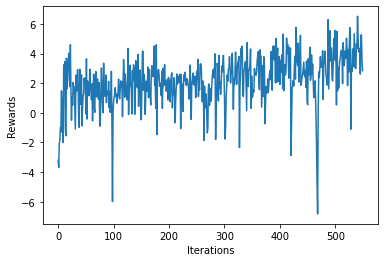

 55%|█████████████████████████████████████████▎                                 | 55104/100000 [41:01<33:35, 22.28it/s]

Updated Weights
Mean Reward = 2.1380000000000017
17


 55%|█████████████████████████████████████████▍                                 | 55203/100000 [41:06<29:23, 25.40it/s]

Updated Weights
Mean Reward = 4.962000000000001
30


 55%|█████████████████████████████████████████▍                                 | 55304/100000 [41:10<30:10, 24.69it/s]

Updated Weights
Mean Reward = 3.567000000000001
25


 55%|█████████████████████████████████████████▌                                 | 55404/100000 [41:14<30:16, 24.54it/s]

Updated Weights
Mean Reward = 4.560000000000001
28


 55%|█████████████████████████████████████████▌                                 | 55499/100000 [41:18<33:58, 21.83it/s]

Updated Weights
Mean Reward = 1.5090000000000015
28


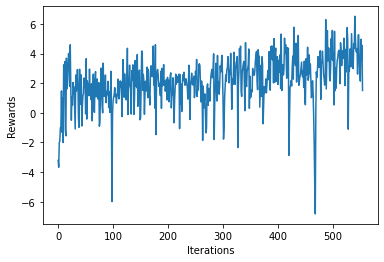

 56%|█████████████████████████████████████████▋                                 | 55603/100000 [41:24<53:50, 13.74it/s]

Updated Weights
Mean Reward = 1.2710000000000015
11


 56%|█████████████████████████████████████████▊                                 | 55703/100000 [41:31<45:29, 16.23it/s]

Updated Weights
Mean Reward = 0.8850000000000006
10


 56%|█████████████████████████████████████████▊                                 | 55805/100000 [41:37<39:22, 18.70it/s]

Updated Weights
Mean Reward = 2.4560000000000013
14


 56%|█████████████████████████████████████████▉                                 | 55902/100000 [41:44<48:23, 15.19it/s]

Updated Weights
Mean Reward = 2.2340000000000013
19


 56%|█████████████████████████████████████████▉                                 | 55999/100000 [41:50<50:21, 14.56it/s]

Updated Weights
Mean Reward = 2.602000000000002
9


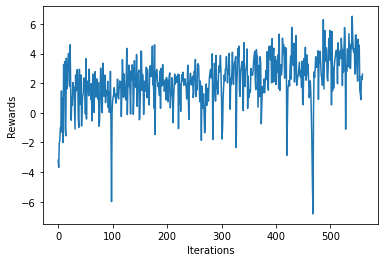

 56%|██████████████████████████████████████████                                 | 56103/100000 [41:57<47:49, 15.30it/s]

Updated Weights
Mean Reward = 3.609000000000001
26


 56%|██████████████████████████████████████████▏                                | 56204/100000 [42:03<44:54, 16.26it/s]

Updated Weights
Mean Reward = 2.6010000000000013
16


 56%|██████████████████████████████████████████▏                                | 56303/100000 [42:09<46:16, 15.74it/s]

Updated Weights
Mean Reward = 2.2450000000000014
11


 56%|██████████████████████████████████████████▎                                | 56403/100000 [42:15<46:19, 15.69it/s]

Updated Weights
Mean Reward = 3.733000000000002
17


 56%|██████████████████████████████████████████▎                                | 56499/100000 [42:21<44:35, 16.26it/s]

Updated Weights
Mean Reward = 4.762000000000001
20


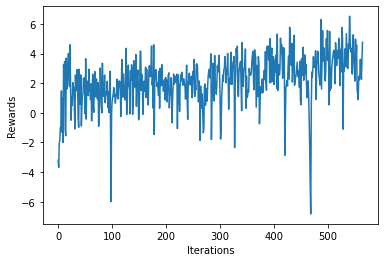

 57%|██████████████████████████████████████████▍                                | 56602/100000 [42:27<47:17, 15.29it/s]

Updated Weights
Mean Reward = 3.737000000000001
17


 57%|██████████████████████████████████████████▌                                | 56702/100000 [42:33<48:33, 14.86it/s]

Updated Weights
Mean Reward = 4.139000000000001
23


 57%|██████████████████████████████████████████▌                                | 56803/100000 [42:39<47:45, 15.08it/s]

Updated Weights
Mean Reward = 3.5250000000000012
17


 57%|██████████████████████████████████████████▋                                | 56902/100000 [42:46<48:57, 14.67it/s]

Updated Weights
Mean Reward = 2.004000000000001
12


 57%|██████████████████████████████████████████▋                                | 57000/100000 [42:52<45:56, 15.60it/s]

Updated Weights
Mean Reward = 2.5220000000000016
10


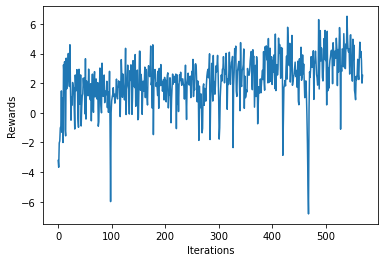

 57%|██████████████████████████████████████████▊                                | 57102/100000 [42:59<50:24, 14.19it/s]

Updated Weights
Mean Reward = 3.1980000000000013
17


 57%|██████████████████████████████████████████▉                                | 57202/100000 [43:06<52:49, 13.50it/s]

Updated Weights
Mean Reward = 3.1040000000000014
10


 57%|██████████████████████████████████████████▉                                | 57303/100000 [43:13<51:20, 13.86it/s]

Updated Weights
Mean Reward = 2.870000000000001
15


 57%|███████████████████████████████████████████                                | 57402/100000 [43:20<53:53, 13.18it/s]

Updated Weights
Mean Reward = 2.624000000000001
12


 57%|███████████████████████████████████████████                                | 57499/100000 [43:27<49:52, 14.20it/s]

Updated Weights
Mean Reward = 3.843000000000003
14


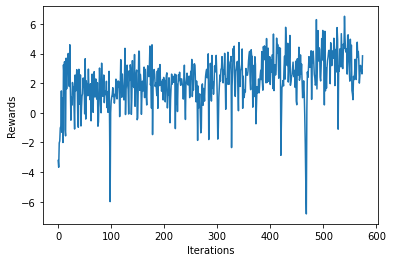

 58%|███████████████████████████████████████████▏                               | 57602/100000 [43:34<45:37, 15.49it/s]

Updated Weights
Mean Reward = 3.583000000000001
23


 58%|███████████████████████████████████████████▎                               | 57702/100000 [43:40<33:19, 21.15it/s]

Updated Weights
Mean Reward = 4.113000000000001
31


 58%|███████████████████████████████████████████▎                               | 57802/100000 [43:46<41:16, 17.04it/s]

Updated Weights
Mean Reward = 4.247000000000002
29


 58%|███████████████████████████████████████████▍                               | 57904/100000 [43:52<40:59, 17.11it/s]

Updated Weights
Mean Reward = 5.661000000000001
35


 58%|███████████████████████████████████████████▍                               | 57998/100000 [43:58<42:56, 16.30it/s]

Updated Weights
Mean Reward = 4.056000000000001
28


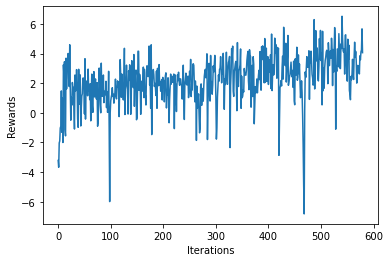

 58%|███████████████████████████████████████████▌                               | 58102/100000 [44:05<53:46, 12.99it/s]

Updated Weights
Mean Reward = 5.039000000000002
27


 58%|███████████████████████████████████████████▋                               | 58202/100000 [44:10<48:58, 14.23it/s]

Updated Weights
Mean Reward = 5.027000000000001
38


 58%|███████████████████████████████████████████▋                               | 58302/100000 [44:17<36:22, 19.11it/s]

Updated Weights
Mean Reward = 2.0210000000000012
25


 58%|███████████████████████████████████████████▊                               | 58403/100000 [44:23<50:00, 13.86it/s]

Updated Weights
Mean Reward = 2.044000000000001
22


 58%|███████████████████████████████████████████▊                               | 58499/100000 [44:29<41:03, 16.85it/s]

Updated Weights
Mean Reward = 2.765000000000001
22


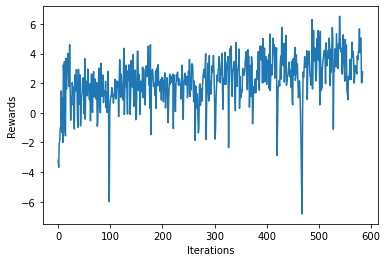

 59%|███████████████████████████████████████████▉                               | 58602/100000 [44:36<30:57, 22.29it/s]

Updated Weights
Mean Reward = 5.998000000000002
36


 59%|████████████████████████████████████████████                               | 58703/100000 [44:43<48:18, 14.25it/s]

Updated Weights
Mean Reward = -1.9689999999999974
8


 59%|████████████████████████████████████████████                               | 58802/100000 [44:50<52:35, 13.05it/s]

Updated Weights
Mean Reward = 1.7530000000000008
10


 59%|████████████████████████████████████████████▏                              | 58903/100000 [44:58<45:29, 15.05it/s]

Updated Weights
Mean Reward = 3.058000000000001
9


 59%|████████████████████████████████████████████▎                              | 59000/100000 [45:04<44:32, 15.34it/s]

Updated Weights
Mean Reward = 2.8780000000000014
9


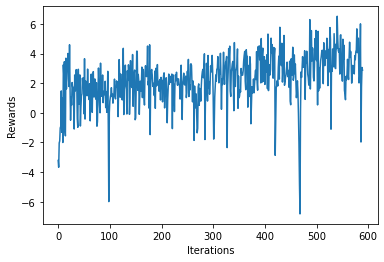

 59%|████████████████████████████████████████████▎                              | 59102/100000 [45:12<48:03, 14.19it/s]

Updated Weights
Mean Reward = 2.4690000000000016
6


 59%|████████████████████████████████████████████▍                              | 59202/100000 [45:19<52:36, 12.93it/s]

Updated Weights
Mean Reward = 3.370000000000002
13


 59%|████████████████████████████████████████████▍                              | 59304/100000 [45:25<44:59, 15.07it/s]

Updated Weights
Mean Reward = 4.424000000000001
23


 59%|████████████████████████████████████████████▌                              | 59403/100000 [45:32<38:33, 17.55it/s]

Updated Weights
Mean Reward = 4.003000000000001
21


 60%|████████████████████████████████████████████▋                              | 59500/100000 [45:38<47:28, 14.22it/s]

Updated Weights
Mean Reward = 2.549000000000002
14


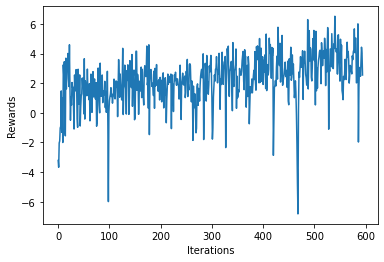

 60%|████████████████████████████████████████████▋                              | 59602/100000 [45:44<38:15, 17.60it/s]

Updated Weights
Mean Reward = 3.2580000000000022
12


 60%|████████████████████████████████████████████▊                              | 59703/100000 [45:50<38:12, 17.58it/s]

Updated Weights
Mean Reward = 3.5550000000000015
12


 60%|████████████████████████████████████████████▊                              | 59805/100000 [45:55<34:07, 19.63it/s]

Updated Weights
Mean Reward = 3.0620000000000016
8


 60%|████████████████████████████████████████████▉                              | 59903/100000 [46:00<30:43, 21.75it/s]

Updated Weights
Mean Reward = 4.359000000000002
18


 60%|████████████████████████████████████████████▉                              | 59999/100000 [46:05<35:55, 18.55it/s]

Updated Weights
Mean Reward = 3.7220000000000018
18


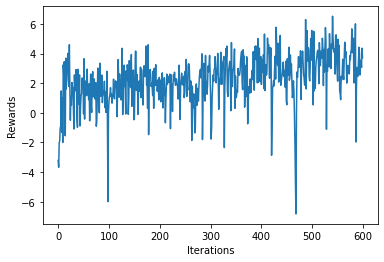

 60%|█████████████████████████████████████████████                              | 60104/100000 [46:10<33:31, 19.83it/s]

Updated Weights
Mean Reward = 3.1810000000000027
15


 60%|█████████████████████████████████████████████▏                             | 60204/100000 [46:15<32:46, 20.23it/s]

Updated Weights
Mean Reward = 4.272000000000001
25


 60%|█████████████████████████████████████████████▏                             | 60303/100000 [46:20<29:31, 22.41it/s]

Updated Weights
Mean Reward = 5.251000000000001
35


 60%|█████████████████████████████████████████████▎                             | 60403/100000 [46:25<37:11, 17.74it/s]

Updated Weights
Mean Reward = 4.012000000000002
20


 60%|█████████████████████████████████████████████▍                             | 60500/100000 [46:29<32:43, 20.12it/s]

Updated Weights
Mean Reward = 3.7000000000000015
23


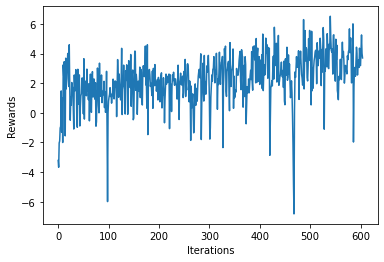

 61%|█████████████████████████████████████████████▍                             | 60604/100000 [46:34<32:39, 20.10it/s]

Updated Weights
Mean Reward = 4.353000000000001
32


 61%|█████████████████████████████████████████████▌                             | 60704/100000 [46:39<30:52, 21.22it/s]

Updated Weights
Mean Reward = 3.5610000000000013
23


 61%|█████████████████████████████████████████████▌                             | 60803/100000 [46:43<32:01, 20.40it/s]

Updated Weights
Mean Reward = 4.426000000000003
24


 61%|█████████████████████████████████████████████▋                             | 60903/100000 [46:47<28:40, 22.73it/s]

Updated Weights
Mean Reward = 4.383000000000001
25


 61%|█████████████████████████████████████████████▊                             | 61000/100000 [46:51<25:44, 25.26it/s]

Updated Weights
Mean Reward = 4.647000000000001
37


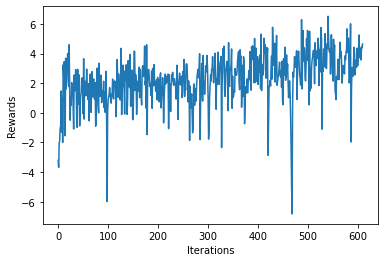

 61%|█████████████████████████████████████████████▊                             | 61103/100000 [46:56<26:29, 24.47it/s]

Updated Weights
Mean Reward = 3.3410000000000015
29


 61%|█████████████████████████████████████████████▉                             | 61202/100000 [47:00<35:25, 18.25it/s]

Updated Weights
Mean Reward = 4.312
32


 61%|█████████████████████████████████████████████▉                             | 61303/100000 [47:05<32:48, 19.65it/s]

Updated Weights
Mean Reward = 3.854000000000002
17


 61%|██████████████████████████████████████████████                             | 61403/100000 [47:11<41:52, 15.36it/s]

Updated Weights
Mean Reward = -0.2779999999999989
6


 62%|██████████████████████████████████████████████▏                            | 61500/100000 [47:17<37:31, 17.10it/s]

Updated Weights
Mean Reward = 3.3220000000000014
16


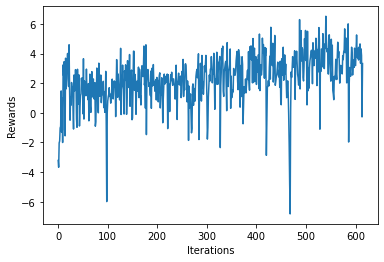

 62%|██████████████████████████████████████████████▏                            | 61603/100000 [47:24<38:01, 16.83it/s]

Updated Weights
Mean Reward = 3.3790000000000013
19


 62%|██████████████████████████████████████████████▎                            | 61703/100000 [47:29<40:57, 15.58it/s]

Updated Weights
Mean Reward = 4.846000000000002
21


 62%|██████████████████████████████████████████████▎                            | 61803/100000 [47:35<28:53, 22.03it/s]

Updated Weights
Mean Reward = 5.215000000000003
26


 62%|██████████████████████████████████████████████▍                            | 61904/100000 [47:40<26:38, 23.84it/s]

Updated Weights
Mean Reward = 5.380000000000001
36


 62%|██████████████████████████████████████████████▍                            | 61999/100000 [47:45<34:56, 18.13it/s]

Updated Weights
Mean Reward = 1.221000000000001
21


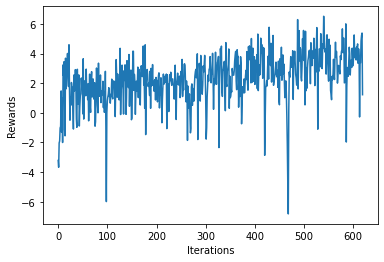

 62%|██████████████████████████████████████████████▌                            | 62104/100000 [47:51<37:40, 16.77it/s]

Updated Weights
Mean Reward = 4.411000000000001
22


 62%|██████████████████████████████████████████████▋                            | 62204/100000 [47:56<24:59, 25.21it/s]

Updated Weights
Mean Reward = 4.683000000000002
25


 62%|██████████████████████████████████████████████▋                            | 62304/100000 [48:00<28:06, 22.35it/s]

Updated Weights
Mean Reward = 2.9840000000000013
14


 62%|██████████████████████████████████████████████▊                            | 62402/100000 [48:05<29:55, 20.94it/s]

Updated Weights
Mean Reward = 3.465000000000002
11


 62%|██████████████████████████████████████████████▊                            | 62498/100000 [48:09<30:04, 20.78it/s]

Updated Weights
Mean Reward = 3.1650000000000023
12


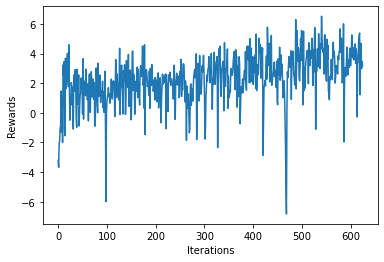

 63%|██████████████████████████████████████████████▉                            | 62605/100000 [48:15<32:26, 19.21it/s]

Updated Weights
Mean Reward = 4.060000000000003
15


 63%|███████████████████████████████████████████████                            | 62703/100000 [48:21<40:15, 15.44it/s]

Updated Weights
Mean Reward = 4.467000000000001
19


 63%|███████████████████████████████████████████████                            | 62803/100000 [48:27<36:34, 16.95it/s]

Updated Weights
Mean Reward = 3.6080000000000023
16


 63%|███████████████████████████████████████████████▏                           | 62903/100000 [48:32<38:24, 16.10it/s]

Updated Weights
Mean Reward = 4.867000000000002
22


 63%|███████████████████████████████████████████████▏                           | 62997/100000 [48:38<39:35, 15.58it/s]

Updated Weights
Mean Reward = 3.078000000000003
13


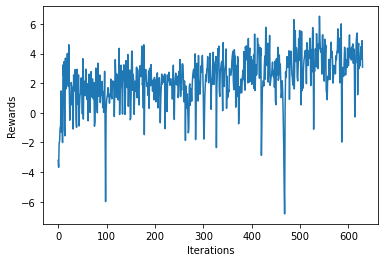

 63%|███████████████████████████████████████████████▎                           | 63102/100000 [48:44<36:23, 16.90it/s]

Updated Weights
Mean Reward = 4.6880000000000015
22


 63%|███████████████████████████████████████████████▍                           | 63205/100000 [48:49<31:29, 19.47it/s]

Updated Weights
Mean Reward = 6.164000000000001
36


 63%|███████████████████████████████████████████████▍                           | 63303/100000 [48:54<28:23, 21.55it/s]

Updated Weights
Mean Reward = 5.590000000000001
28


 63%|███████████████████████████████████████████████▌                           | 63402/100000 [48:57<19:43, 30.92it/s]

Updated Weights
Mean Reward = 4.924000000000001
28


 64%|███████████████████████████████████████████████▋                           | 63500/100000 [49:01<23:22, 26.02it/s]

Updated Weights
Mean Reward = 3.412000000000002
22


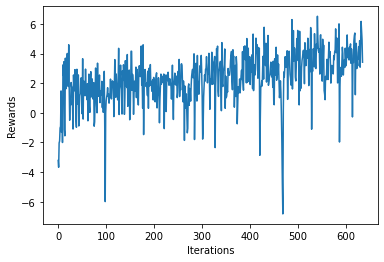

 64%|███████████████████████████████████████████████▋                           | 63605/100000 [49:06<23:38, 25.66it/s]

Updated Weights
Mean Reward = 4.019
26


 64%|███████████████████████████████████████████████▊                           | 63704/100000 [49:10<26:14, 23.05it/s]

Updated Weights
Mean Reward = 5.127000000000002
39


 64%|███████████████████████████████████████████████▊                           | 63803/100000 [49:14<29:00, 20.79it/s]

Updated Weights
Mean Reward = 3.564000000000002
22


 64%|███████████████████████████████████████████████▉                           | 63905/100000 [49:18<24:02, 25.02it/s]

Updated Weights
Mean Reward = 4.395000000000001
29


 64%|███████████████████████████████████████████████▉                           | 63999/100000 [49:22<26:46, 22.41it/s]

Updated Weights
Mean Reward = 2.9610000000000007
23


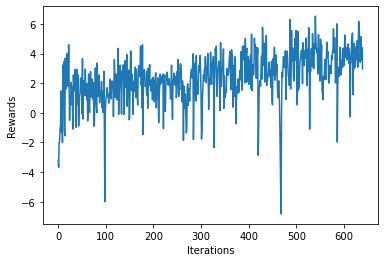

 64%|████████████████████████████████████████████████                           | 64105/100000 [49:26<26:46, 22.35it/s]

Updated Weights
Mean Reward = 3.684000000000002
26


 64%|████████████████████████████████████████████████▏                          | 64205/100000 [49:30<22:17, 26.75it/s]

Updated Weights
Mean Reward = 2.6080000000000014
19


 64%|████████████████████████████████████████████████▏                          | 64306/100000 [49:35<23:06, 25.74it/s]

Updated Weights
Mean Reward = 3.8350000000000017
24


 64%|████████████████████████████████████████████████▎                          | 64404/100000 [49:39<22:44, 26.09it/s]

Updated Weights
Mean Reward = 4.689000000000002
25


 64%|████████████████████████████████████████████████▎                          | 64498/100000 [49:42<19:02, 31.08it/s]

Updated Weights
Mean Reward = 6.810000000000001
41


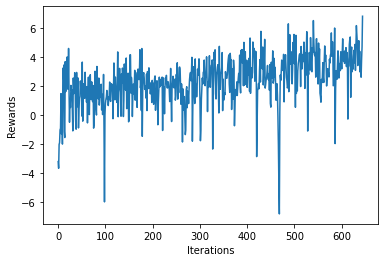

 65%|████████████████████████████████████████████████▍                          | 64602/100000 [49:47<33:50, 17.44it/s]

Updated Weights
Mean Reward = 0.6620000000000009
15


 65%|████████████████████████████████████████████████▌                          | 64701/100000 [49:53<28:24, 20.70it/s]

Updated Weights
Mean Reward = 4.102000000000001
26


 65%|████████████████████████████████████████████████▌                          | 64803/100000 [49:59<33:23, 17.57it/s]

Updated Weights
Mean Reward = 4.269000000000001
19


 65%|████████████████████████████████████████████████▋                          | 64903/100000 [50:04<33:24, 17.51it/s]

Updated Weights
Mean Reward = 5.668000000000003
30


 65%|████████████████████████████████████████████████▊                          | 65000/100000 [50:09<37:14, 15.66it/s]

Updated Weights
Mean Reward = 3.171000000000002
19


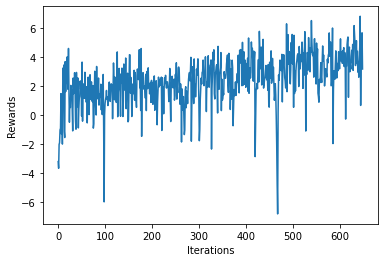

 65%|████████████████████████████████████████████████▊                          | 65104/100000 [50:15<29:00, 20.04it/s]

Updated Weights
Mean Reward = 5.235
28


 65%|████████████████████████████████████████████████▉                          | 65204/100000 [50:18<22:22, 25.91it/s]

Updated Weights
Mean Reward = 6.692000000000002
43


 65%|████████████████████████████████████████████████▉                          | 65303/100000 [50:23<23:58, 24.13it/s]

Updated Weights
Mean Reward = 1.9300000000000008
13


 65%|█████████████████████████████████████████████████                          | 65404/100000 [50:27<24:36, 23.44it/s]

Updated Weights
Mean Reward = 1.3900000000000006
21


 65%|█████████████████████████████████████████████████                          | 65499/100000 [50:30<22:06, 26.01it/s]

Updated Weights
Mean Reward = 5.723000000000001
35


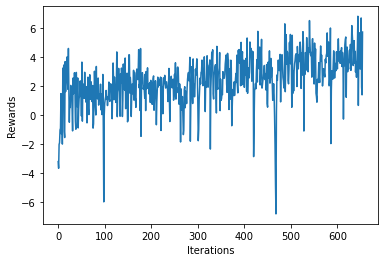

 66%|█████████████████████████████████████████████████▏                         | 65604/100000 [50:34<23:30, 24.38it/s]

Updated Weights
Mean Reward = 2.8700000000000006
24


 66%|█████████████████████████████████████████████████▎                         | 65704/100000 [50:39<25:30, 22.41it/s]

Updated Weights
Mean Reward = 4.4970000000000026
18


 66%|█████████████████████████████████████████████████▎                         | 65805/100000 [50:43<25:42, 22.16it/s]

Updated Weights
Mean Reward = 3.7830000000000017
14


 66%|█████████████████████████████████████████████████▍                         | 65904/100000 [50:47<26:25, 21.51it/s]

Updated Weights
Mean Reward = 4.955000000000002
26


 66%|█████████████████████████████████████████████████▍                         | 65999/100000 [50:53<33:32, 16.89it/s]

Updated Weights
Mean Reward = 4.145000000000002
19


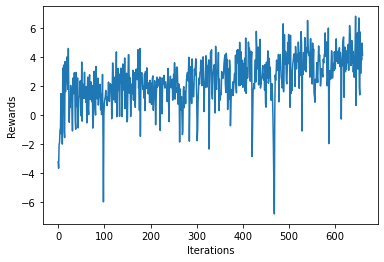

 66%|█████████████████████████████████████████████████▌                         | 66104/100000 [50:59<32:27, 17.41it/s]

Updated Weights
Mean Reward = 3.6120000000000023
13


 66%|█████████████████████████████████████████████████▋                         | 66204/100000 [51:04<31:54, 17.65it/s]

Updated Weights
Mean Reward = 5.293000000000002
26


 66%|█████████████████████████████████████████████████▋                         | 66304/100000 [51:09<23:23, 24.00it/s]

Updated Weights
Mean Reward = 4.098000000000001
20


 66%|█████████████████████████████████████████████████▊                         | 66403/100000 [51:14<25:58, 21.56it/s]

Updated Weights
Mean Reward = 3.2750000000000017
21


 66%|█████████████████████████████████████████████████▊                         | 66496/100000 [51:18<22:10, 25.17it/s]

Updated Weights
Mean Reward = 3.4890000000000017
23


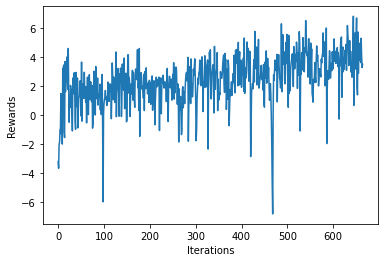

 67%|█████████████████████████████████████████████████▉                         | 66602/100000 [51:23<38:43, 14.38it/s]

Updated Weights
Mean Reward = 5.1720000000000015
22


 67%|██████████████████████████████████████████████████                         | 66702/100000 [51:29<41:45, 13.29it/s]

Updated Weights
Mean Reward = 4.442000000000002
29


 67%|██████████████████████████████████████████████████                         | 66802/100000 [51:36<42:03, 13.16it/s]

Updated Weights
Mean Reward = 4.014000000000001
14


 67%|██████████████████████████████████████████████████▏                        | 66903/100000 [51:43<38:55, 14.17it/s]

Updated Weights
Mean Reward = 4.339000000000001
20


 67%|██████████████████████████████████████████████████▎                        | 67000/100000 [51:49<35:09, 15.64it/s]

Updated Weights
Mean Reward = 4.424000000000003
20


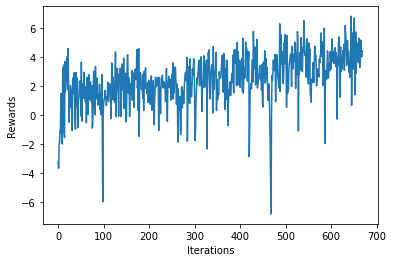

 67%|██████████████████████████████████████████████████▎                        | 67102/100000 [51:55<36:50, 14.88it/s]

Updated Weights
Mean Reward = 3.4110000000000014
18


 67%|██████████████████████████████████████████████████▍                        | 67203/100000 [52:01<32:23, 16.88it/s]

Updated Weights
Mean Reward = 3.0030000000000023
18


 67%|██████████████████████████████████████████████████▍                        | 67304/100000 [52:09<37:52, 14.39it/s]

Updated Weights
Mean Reward = 4.084000000000002
26


 67%|██████████████████████████████████████████████████▌                        | 67403/100000 [52:15<32:34, 16.68it/s]

Updated Weights
Mean Reward = 3.9400000000000004
28


 68%|██████████████████████████████████████████████████▋                        | 67500/100000 [52:22<38:23, 14.11it/s]

Updated Weights
Mean Reward = 6.040000000000001
30


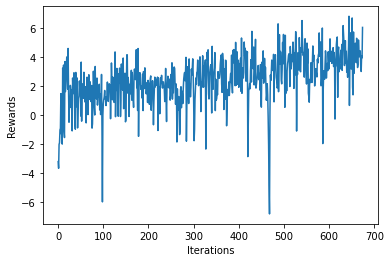

 68%|██████████████████████████████████████████████████▋                        | 67602/100000 [52:29<31:13, 17.29it/s]

Updated Weights
Mean Reward = 5.792000000000001
42


 68%|██████████████████████████████████████████████████▊                        | 67701/100000 [52:36<26:16, 20.49it/s]

Updated Weights
Mean Reward = 6.191000000000002
40


 68%|██████████████████████████████████████████████████▊                        | 67801/100000 [52:44<45:07, 11.89it/s]

Updated Weights
Mean Reward = 2.184000000000001
18


 68%|██████████████████████████████████████████████████▉                        | 67904/100000 [52:52<35:31, 15.06it/s]

Updated Weights
Mean Reward = 4.458000000000002
28


 68%|██████████████████████████████████████████████████▉                        | 67999/100000 [52:59<35:29, 15.03it/s]

Updated Weights
Mean Reward = 4.283000000000001
25


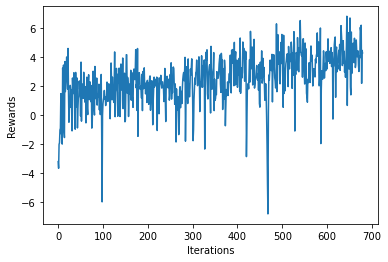

 68%|███████████████████████████████████████████████████                        | 68103/100000 [53:06<36:48, 14.44it/s]

Updated Weights
Mean Reward = 4.944
34


 68%|███████████████████████████████████████████████████▏                       | 68204/100000 [53:12<32:58, 16.07it/s]

Updated Weights
Mean Reward = 3.3770000000000007
24


 68%|███████████████████████████████████████████████████▏                       | 68303/100000 [53:19<36:29, 14.48it/s]

Updated Weights
Mean Reward = 6.557
41


 68%|███████████████████████████████████████████████████▎                       | 68402/100000 [53:26<40:46, 12.92it/s]

Updated Weights
Mean Reward = 3.2720000000000002
23


 68%|███████████████████████████████████████████████████▎                       | 68499/100000 [53:32<37:08, 14.14it/s]

Updated Weights
Mean Reward = 4.608000000000001
30


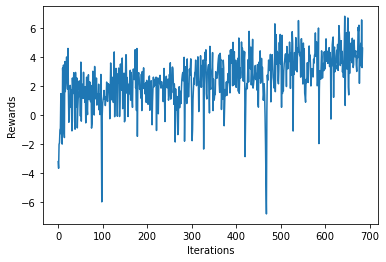

 69%|███████████████████████████████████████████████████▍                       | 68602/100000 [53:41<56:35,  9.25it/s]

Updated Weights
Mean Reward = 5.229000000000001
36


 69%|███████████████████████████████████████████████████▌                       | 68701/100000 [53:49<41:17, 12.63it/s]

Updated Weights
Mean Reward = 3.0650000000000013
18


 69%|███████████████████████████████████████████████████▌                       | 68802/100000 [53:56<38:41, 13.44it/s]

Updated Weights
Mean Reward = 4.7890000000000015
25


 69%|███████████████████████████████████████████████████▋                       | 68901/100000 [54:04<37:44, 13.73it/s]

Updated Weights
Mean Reward = 4.615000000000002
27


 69%|███████████████████████████████████████████████████▋                       | 68998/100000 [54:12<40:43, 12.69it/s]

Updated Weights
Mean Reward = 4.093000000000001
24


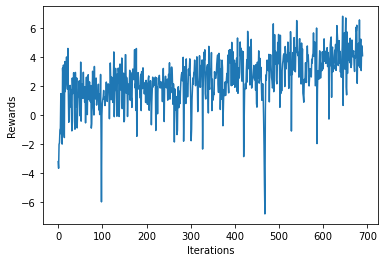

 69%|███████████████████████████████████████████████████▊                       | 69103/100000 [54:19<35:28, 14.51it/s]

Updated Weights
Mean Reward = 5.339000000000002
40


 69%|███████████████████████████████████████████████████▉                       | 69203/100000 [54:27<42:08, 12.18it/s]

Updated Weights
Mean Reward = 2.8140000000000014
27


 69%|███████████████████████████████████████████████████▉                       | 69301/100000 [54:36<51:32,  9.93it/s]

Updated Weights
Mean Reward = 1.4090000000000011
9


 69%|████████████████████████████████████████████████████                       | 69402/100000 [54:46<48:07, 10.60it/s]

Updated Weights
Mean Reward = 2.6310000000000024
11


 69%|████████████████████████████████████████████████████                       | 69499/100000 [54:55<35:39, 14.25it/s]

Updated Weights
Mean Reward = 3.6050000000000013
14


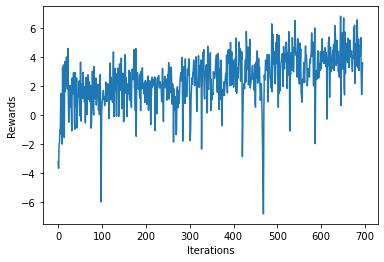

 70%|████████████████████████████████████████████████████▏                      | 69602/100000 [55:05<45:26, 11.15it/s]

Updated Weights
Mean Reward = 4.815000000000003
26


 70%|████████████████████████████████████████████████████▎                      | 69703/100000 [55:13<40:45, 12.39it/s]

Updated Weights
Mean Reward = 3.494000000000002
15


 70%|████████████████████████████████████████████████████▎                      | 69803/100000 [55:22<35:12, 14.30it/s]

Updated Weights
Mean Reward = 4.945000000000001
21


 70%|████████████████████████████████████████████████████▍                      | 69903/100000 [55:28<33:55, 14.79it/s]

Updated Weights
Mean Reward = 4.278000000000002
21


 70%|████████████████████████████████████████████████████▍                      | 69999/100000 [55:35<34:13, 14.61it/s]

Updated Weights
Mean Reward = 3.3820000000000023
10


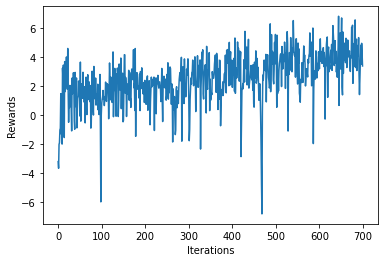

 70%|████████████████████████████████████████████████████▌                      | 70103/100000 [55:42<32:55, 15.14it/s]

Updated Weights
Mean Reward = 3.693000000000002
16


 70%|████████████████████████████████████████████████████▋                      | 70203/100000 [55:48<32:12, 15.42it/s]

Updated Weights
Mean Reward = 5.144000000000003
23


 70%|████████████████████████████████████████████████████▋                      | 70304/100000 [55:55<29:51, 16.58it/s]

Updated Weights
Mean Reward = 4.934000000000003
20


 70%|████████████████████████████████████████████████████▊                      | 70402/100000 [56:01<31:18, 15.76it/s]

Updated Weights
Mean Reward = 3.3410000000000015
20


 70%|████████████████████████████████████████████████████▉                      | 70500/100000 [56:09<35:20, 13.91it/s]

Updated Weights
Mean Reward = 4.901000000000002
24


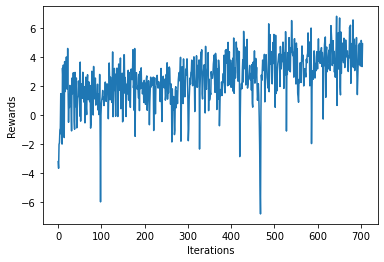

 71%|████████████████████████████████████████████████████▉                      | 70603/100000 [56:16<31:41, 15.46it/s]

Updated Weights
Mean Reward = 5.661000000000002
26


 71%|█████████████████████████████████████████████████████                      | 70702/100000 [56:23<42:32, 11.48it/s]

Updated Weights
Mean Reward = 5.129
31


 71%|█████████████████████████████████████████████████████                      | 70804/100000 [56:30<32:08, 15.14it/s]

Updated Weights
Mean Reward = 3.5310000000000015
25


 71%|█████████████████████████████████████████████████████▏                     | 70902/100000 [56:36<32:36, 14.87it/s]

Updated Weights
Mean Reward = 4.384000000000001
29


 71%|█████████████████████████████████████████████████████▏                     | 70999/100000 [56:43<36:58, 13.07it/s]

Updated Weights
Mean Reward = 2.7510000000000012
15


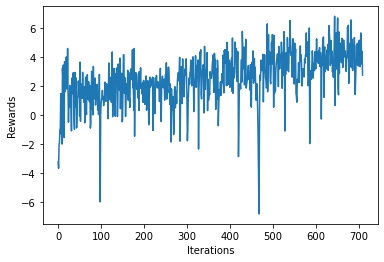

 71%|█████████████████████████████████████████████████████▎                     | 71103/100000 [56:51<36:07, 13.33it/s]

Updated Weights
Mean Reward = 3.453000000000001
19


 71%|█████████████████████████████████████████████████████▍                     | 71202/100000 [56:58<36:49, 13.03it/s]

Updated Weights
Mean Reward = 4.147000000000001
22


 71%|█████████████████████████████████████████████████████▍                     | 71303/100000 [57:05<36:39, 13.05it/s]

Updated Weights
Mean Reward = 5.433000000000002
29


 71%|█████████████████████████████████████████████████████▌                     | 71402/100000 [57:13<30:01, 15.87it/s]

Updated Weights
Mean Reward = 2.4890000000000008
12


 71%|█████████████████████████████████████████████████████▌                     | 71499/100000 [57:21<35:26, 13.40it/s]

Updated Weights
Mean Reward = 5.063000000000002
20


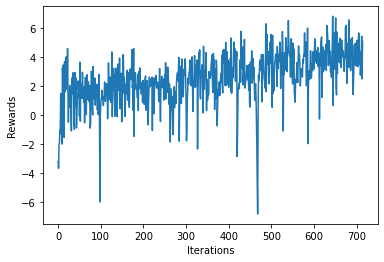

 72%|█████████████████████████████████████████████████████▋                     | 71602/100000 [57:29<29:30, 16.04it/s]

Updated Weights
Mean Reward = 4.618000000000002
19


 72%|█████████████████████████████████████████████████████▊                     | 71703/100000 [57:35<31:22, 15.03it/s]

Updated Weights
Mean Reward = 3.766000000000002
17


 72%|█████████████████████████████████████████████████████▊                     | 71805/100000 [57:42<24:42, 19.01it/s]

Updated Weights
Mean Reward = 6.145000000000002
33


 72%|█████████████████████████████████████████████████████▉                     | 71902/100000 [57:48<31:45, 14.75it/s]

Updated Weights
Mean Reward = 2.416000000000001
14


 72%|█████████████████████████████████████████████████████▉                     | 71998/100000 [57:54<33:50, 13.79it/s]

Updated Weights
Mean Reward = 4.465000000000001
19


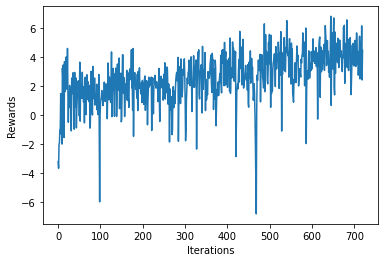

 72%|██████████████████████████████████████████████████████                     | 72103/100000 [58:00<16:46, 27.71it/s]

Updated Weights
Mean Reward = 4.332000000000002
19


 72%|██████████████████████████████████████████████████████▏                    | 72203/100000 [58:05<23:55, 19.37it/s]

Updated Weights
Mean Reward = 3.5800000000000023
17


 72%|██████████████████████████████████████████████████████▏                    | 72303/100000 [58:09<18:33, 24.88it/s]

Updated Weights
Mean Reward = 4.284000000000001
17


 72%|██████████████████████████████████████████████████████▎                    | 72405/100000 [58:13<18:27, 24.92it/s]

Updated Weights
Mean Reward = 4.929000000000001
28


 72%|██████████████████████████████████████████████████████▍                    | 72500/100000 [58:17<19:32, 23.46it/s]

Updated Weights
Mean Reward = 6.3450000000000015
35


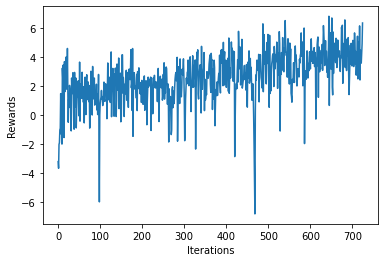

 73%|██████████████████████████████████████████████████████▍                    | 72603/100000 [58:21<18:50, 24.24it/s]

Updated Weights
Mean Reward = 5.739000000000002
26


 73%|██████████████████████████████████████████████████████▌                    | 72704/100000 [58:25<19:54, 22.86it/s]

Updated Weights
Mean Reward = 6.660000000000001
37


 73%|██████████████████████████████████████████████████████▌                    | 72803/100000 [58:29<19:15, 23.54it/s]

Updated Weights
Mean Reward = 2.652000000000001
25


 73%|██████████████████████████████████████████████████████▋                    | 72905/100000 [58:34<19:19, 23.36it/s]

Updated Weights
Mean Reward = 4.4650000000000025
24


 73%|██████████████████████████████████████████████████████▋                    | 72999/100000 [58:37<18:20, 24.54it/s]

Updated Weights
Mean Reward = 4.731000000000002
21


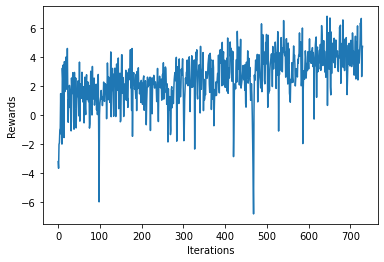

 73%|██████████████████████████████████████████████████████▊                    | 73104/100000 [58:42<17:56, 24.97it/s]

Updated Weights
Mean Reward = 4.263000000000002
21


 73%|██████████████████████████████████████████████████████▉                    | 73204/100000 [58:46<17:45, 25.14it/s]

Updated Weights
Mean Reward = 5.247000000000002
25


 73%|██████████████████████████████████████████████████████▉                    | 73303/100000 [58:50<18:32, 23.99it/s]

Updated Weights
Mean Reward = 5.110000000000001
30


 73%|███████████████████████████████████████████████████████                    | 73402/100000 [58:54<22:58, 19.30it/s]

Updated Weights
Mean Reward = 1.8190000000000013
12


 73%|███████████████████████████████████████████████████████                    | 73499/100000 [58:59<18:13, 24.23it/s]

Updated Weights
Mean Reward = 4.502000000000002
21


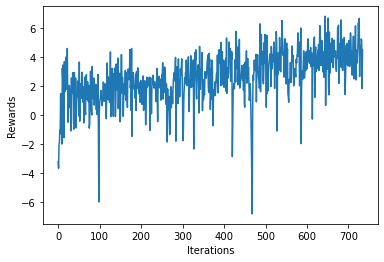

 74%|███████████████████████████████████████████████████████▏                   | 73604/100000 [59:03<18:01, 24.41it/s]

Updated Weights
Mean Reward = 5.343000000000002
26


 74%|███████████████████████████████████████████████████████▎                   | 73704/100000 [59:07<17:29, 25.05it/s]

Updated Weights
Mean Reward = 4.760000000000001
27


 74%|███████████████████████████████████████████████████████▎                   | 73805/100000 [59:11<17:06, 25.52it/s]

Updated Weights
Mean Reward = 3.545000000000002
20


 74%|███████████████████████████████████████████████████████▍                   | 73902/100000 [59:15<16:26, 26.44it/s]

Updated Weights
Mean Reward = 5.401000000000002
30


 74%|███████████████████████████████████████████████████████▌                   | 74000/100000 [59:19<19:04, 22.71it/s]

Updated Weights
Mean Reward = 3.1050000000000004
14


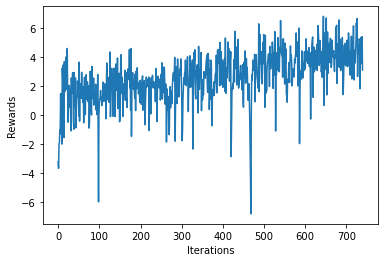

 74%|███████████████████████████████████████████████████████▌                   | 74104/100000 [59:23<19:39, 21.96it/s]

Updated Weights
Mean Reward = 5.107000000000001
26


 74%|███████████████████████████████████████████████████████▋                   | 74204/100000 [59:28<18:16, 23.52it/s]

Updated Weights
Mean Reward = 4.819000000000002
22


 74%|███████████████████████████████████████████████████████▋                   | 74302/100000 [59:33<24:38, 17.38it/s]

Updated Weights
Mean Reward = 4.258000000000001
20


 74%|███████████████████████████████████████████████████████▊                   | 74404/100000 [59:39<25:07, 16.98it/s]

Updated Weights
Mean Reward = 4.1720000000000015
24


 74%|███████████████████████████████████████████████████████▉                   | 74500/100000 [59:44<25:18, 16.79it/s]

Updated Weights
Mean Reward = 4.724000000000001
23


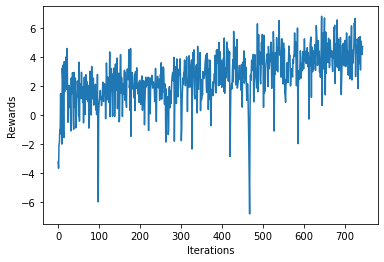

 75%|███████████████████████████████████████████████████████▉                   | 74602/100000 [59:49<21:56, 19.29it/s]

Updated Weights
Mean Reward = 5.309000000000001
31


 75%|████████████████████████████████████████████████████████                   | 74704/100000 [59:55<25:20, 16.63it/s]

Updated Weights
Mean Reward = 3.1470000000000002
29


 75%|██████████████████████████████████████████████████████▌                  | 74803/100000 [1:00:00<25:13, 16.64it/s]

Updated Weights
Mean Reward = 5.376000000000001
30


 75%|██████████████████████████████████████████████████████▋                  | 74904/100000 [1:00:05<21:53, 19.11it/s]

Updated Weights
Mean Reward = 6.671
38


 75%|██████████████████████████████████████████████████████▋                  | 74999/100000 [1:00:11<26:09, 15.93it/s]

Updated Weights
Mean Reward = 5.493000000000002
38


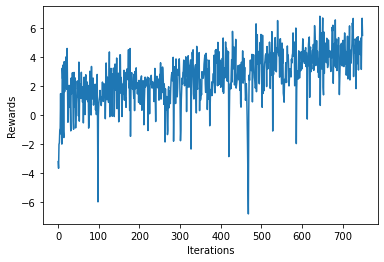

 75%|██████████████████████████████████████████████████████▊                  | 75102/100000 [1:00:17<20:39, 20.09it/s]

Updated Weights
Mean Reward = 1.497000000000002
14


 75%|██████████████████████████████████████████████████████▉                  | 75203/100000 [1:00:22<24:01, 17.20it/s]

Updated Weights
Mean Reward = 3.679000000000002
20


 75%|██████████████████████████████████████████████████████▉                  | 75304/100000 [1:00:27<16:26, 25.03it/s]

Updated Weights
Mean Reward = 2.0990000000000015
10


 75%|███████████████████████████████████████████████████████                  | 75402/100000 [1:00:31<16:49, 24.36it/s]

Updated Weights
Mean Reward = 4.519000000000002
27


 75%|███████████████████████████████████████████████████████                  | 75498/100000 [1:00:35<16:41, 24.47it/s]

Updated Weights
Mean Reward = 4.051000000000001
23


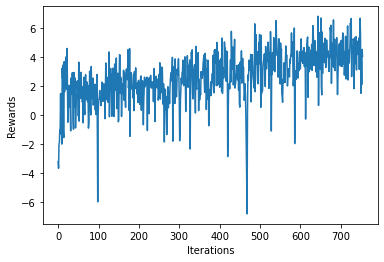

 76%|███████████████████████████████████████████████████████▏                 | 75605/100000 [1:00:39<16:25, 24.75it/s]

Updated Weights
Mean Reward = 5.524000000000001
27


 76%|███████████████████████████████████████████████████████▎                 | 75704/100000 [1:00:43<15:20, 26.40it/s]

Updated Weights
Mean Reward = 4.327000000000002
22


 76%|███████████████████████████████████████████████████████▎                 | 75804/100000 [1:00:47<15:27, 26.10it/s]

Updated Weights
Mean Reward = 5.477
30


 76%|███████████████████████████████████████████████████████▍                 | 75906/100000 [1:00:51<13:56, 28.80it/s]

Updated Weights
Mean Reward = 6.0520000000000005
38


 76%|███████████████████████████████████████████████████████▍                 | 75999/100000 [1:00:54<17:10, 23.30it/s]

Updated Weights
Mean Reward = 3.5570000000000017
21


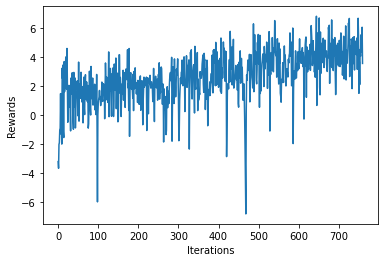

 76%|███████████████████████████████████████████████████████▌                 | 76103/100000 [1:00:58<17:00, 23.42it/s]

Updated Weights
Mean Reward = 3.5940000000000016
23


 76%|███████████████████████████████████████████████████████▋                 | 76205/100000 [1:01:03<19:55, 19.91it/s]

Updated Weights
Mean Reward = 0.5740000000000012
23


 76%|███████████████████████████████████████████████████████▋                 | 76304/100000 [1:01:07<17:19, 22.79it/s]

Updated Weights
Mean Reward = -1.6049999999999989
6


 76%|███████████████████████████████████████████████████████▊                 | 76403/100000 [1:01:13<21:00, 18.72it/s]

Updated Weights
Mean Reward = 2.2580000000000022
15


 76%|███████████████████████████████████████████████████████▊                 | 76500/100000 [1:01:20<26:57, 14.53it/s]

Updated Weights
Mean Reward = 4.770000000000001
27


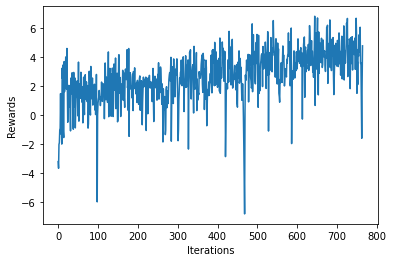

 77%|███████████████████████████████████████████████████████▉                 | 76603/100000 [1:01:27<24:26, 15.96it/s]

Updated Weights
Mean Reward = 5.305
23


 77%|███████████████████████████████████████████████████████▉                 | 76703/100000 [1:01:33<22:09, 17.52it/s]

Updated Weights
Mean Reward = 5.164000000000002
19


 77%|████████████████████████████████████████████████████████                 | 76803/100000 [1:01:38<23:20, 16.56it/s]

Updated Weights
Mean Reward = 6.044000000000002
27


 77%|████████████████████████████████████████████████████████▏                | 76905/100000 [1:01:43<14:51, 25.92it/s]

Updated Weights
Mean Reward = 6.867000000000002
31


 77%|████████████████████████████████████████████████████████▏                | 76999/100000 [1:01:47<14:38, 26.20it/s]

Updated Weights
Mean Reward = 6.1240000000000006
36


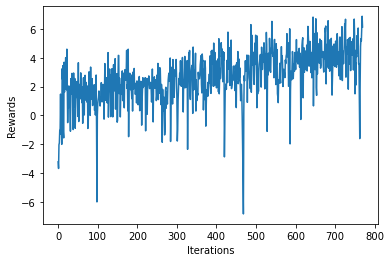

 77%|████████████████████████████████████████████████████████▎                | 77104/100000 [1:01:51<16:54, 22.56it/s]

Updated Weights
Mean Reward = 4.790000000000002
37


 77%|████████████████████████████████████████████████████████▎                | 77203/100000 [1:01:55<16:04, 23.64it/s]

Updated Weights
Mean Reward = 4.180000000000001
27


 77%|████████████████████████████████████████████████████████▍                | 77303/100000 [1:01:59<16:03, 23.55it/s]

Updated Weights
Mean Reward = 2.4970000000000017
15


 77%|████████████████████████████████████████████████████████▌                | 77402/100000 [1:02:03<16:25, 22.93it/s]

Updated Weights
Mean Reward = 4.013000000000002
16


 78%|████████████████████████████████████████████████████████▌                | 77500/100000 [1:02:07<16:10, 23.19it/s]

Updated Weights
Mean Reward = 4.5870000000000015
20


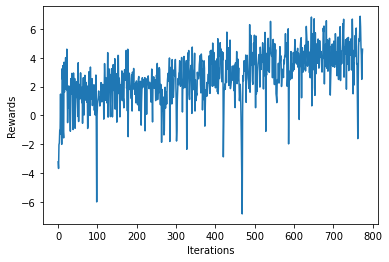

 78%|████████████████████████████████████████████████████████▋                | 77603/100000 [1:02:12<15:50, 23.57it/s]

Updated Weights
Mean Reward = 4.428000000000003
17


 78%|████████████████████████████████████████████████████████▋                | 77705/100000 [1:02:16<15:37, 23.79it/s]

Updated Weights
Mean Reward = 4.852000000000001
21


 78%|████████████████████████████████████████████████████████▊                | 77805/100000 [1:02:20<15:07, 24.46it/s]

Updated Weights
Mean Reward = 4.740000000000002
22


 78%|████████████████████████████████████████████████████████▊                | 77903/100000 [1:02:24<15:42, 23.44it/s]

Updated Weights
Mean Reward = 4.451000000000002
20


 78%|████████████████████████████████████████████████████████▉                | 77999/100000 [1:02:28<14:26, 25.40it/s]

Updated Weights
Mean Reward = 4.936000000000002
23


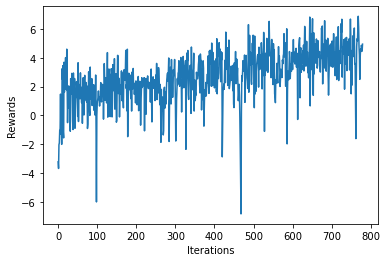

 78%|█████████████████████████████████████████████████████████                | 78103/100000 [1:02:32<16:39, 21.91it/s]

Updated Weights
Mean Reward = 3.404000000000002
15


 78%|█████████████████████████████████████████████████████████                | 78203/100000 [1:02:36<15:31, 23.41it/s]

Updated Weights
Mean Reward = 4.546000000000001
21


 78%|█████████████████████████████████████████████████████████▏               | 78303/100000 [1:02:40<14:06, 25.64it/s]

Updated Weights
Mean Reward = 6.250000000000003
30


 78%|█████████████████████████████████████████████████████████▏               | 78405/100000 [1:02:45<15:28, 23.26it/s]

Updated Weights
Mean Reward = 4.886000000000003
23


 78%|█████████████████████████████████████████████████████████▎               | 78499/100000 [1:02:48<13:27, 26.62it/s]

Updated Weights
Mean Reward = 7.021000000000002
33


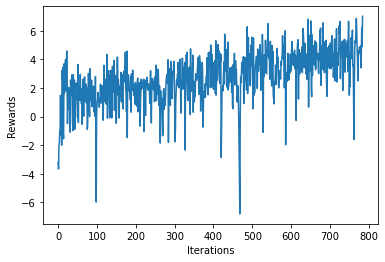

 79%|█████████████████████████████████████████████████████████▍               | 78604/100000 [1:02:53<13:49, 25.79it/s]

Updated Weights
Mean Reward = 5.119000000000002
24


 79%|█████████████████████████████████████████████████████████▍               | 78703/100000 [1:02:57<14:50, 23.91it/s]

Updated Weights
Mean Reward = 6.804000000000001
35


 79%|█████████████████████████████████████████████████████████▌               | 78801/100000 [1:03:00<11:31, 30.68it/s]

Updated Weights
Mean Reward = 7.219000000000002
41


 79%|█████████████████████████████████████████████████████████▌               | 78904/100000 [1:03:04<13:24, 26.22it/s]

Updated Weights
Mean Reward = 6.139000000000001
36


 79%|█████████████████████████████████████████████████████████▋               | 78998/100000 [1:03:07<13:56, 25.12it/s]

Updated Weights
Mean Reward = 1.408000000000002
24


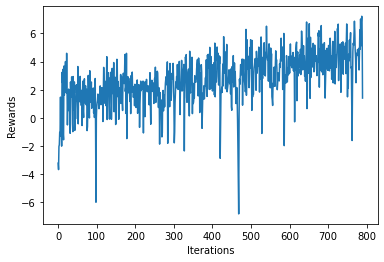

 79%|█████████████████████████████████████████████████████████▋               | 79102/100000 [1:03:11<13:25, 25.94it/s]

Updated Weights
Mean Reward = 4.514000000000003
23


 79%|█████████████████████████████████████████████████████████▊               | 79204/100000 [1:03:16<13:00, 26.63it/s]

Updated Weights
Mean Reward = 4.724000000000002
23


 79%|█████████████████████████████████████████████████████████▉               | 79303/100000 [1:03:19<12:05, 28.55it/s]

Updated Weights
Mean Reward = 8.302
47


 79%|█████████████████████████████████████████████████████████▉               | 79405/100000 [1:03:23<13:10, 26.04it/s]

Updated Weights
Mean Reward = -1.1299999999999988
13


 79%|██████████████████████████████████████████████████████████               | 79499/100000 [1:03:27<11:27, 29.83it/s]

Updated Weights
Mean Reward = 5.246000000000001
28


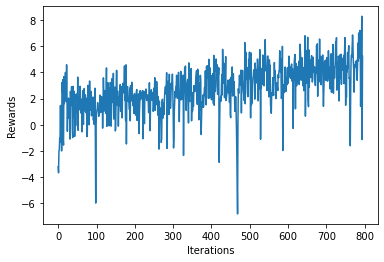

 80%|██████████████████████████████████████████████████████████               | 79602/100000 [1:03:31<14:38, 23.21it/s]

Updated Weights
Mean Reward = 5.073000000000002
26


 80%|██████████████████████████████████████████████████████████▏              | 79703/100000 [1:03:35<13:46, 24.56it/s]

Updated Weights
Mean Reward = 5.307000000000003
24


 80%|██████████████████████████████████████████████████████████▎              | 79805/100000 [1:03:39<13:09, 25.57it/s]

Updated Weights
Mean Reward = 5.861000000000003
26


 80%|██████████████████████████████████████████████████████████▎              | 79904/100000 [1:03:43<13:13, 25.32it/s]

Updated Weights
Mean Reward = 5.359000000000002
25


 80%|██████████████████████████████████████████████████████████▍              | 79997/100000 [1:03:46<11:00, 30.27it/s]

Updated Weights
Mean Reward = 7.159000000000003
38


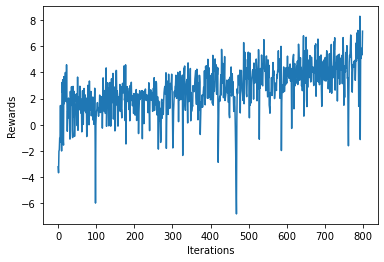

 80%|██████████████████████████████████████████████████████████▍              | 80108/100000 [1:03:50<09:47, 33.89it/s]

Updated Weights
Mean Reward = 5.948000000000002
33


 80%|██████████████████████████████████████████████████████████▌              | 80204/100000 [1:03:54<12:38, 26.09it/s]

Updated Weights
Mean Reward = 3.971000000000002
29


 80%|██████████████████████████████████████████████████████████▌              | 80304/100000 [1:03:58<13:55, 23.57it/s]

Updated Weights
Mean Reward = 4.586000000000002
30


 80%|██████████████████████████████████████████████████████████▋              | 80403/100000 [1:04:02<12:01, 27.16it/s]

Updated Weights
Mean Reward = 5.003000000000001
27


 80%|██████████████████████████████████████████████████████████▊              | 80500/100000 [1:04:05<13:00, 24.98it/s]

Updated Weights
Mean Reward = 6.235000000000002
32


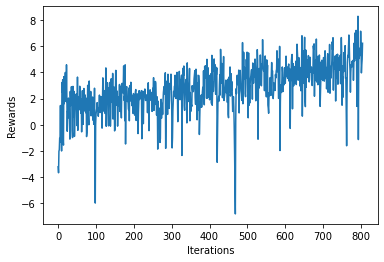

 81%|██████████████████████████████████████████████████████████▊              | 80605/100000 [1:04:10<13:27, 24.03it/s]

Updated Weights
Mean Reward = 4.004000000000002
32


 81%|██████████████████████████████████████████████████████████▉              | 80703/100000 [1:04:13<12:44, 25.23it/s]

Updated Weights
Mean Reward = 4.452000000000002
29


 81%|██████████████████████████████████████████████████████████▉              | 80803/100000 [1:04:17<10:51, 29.45it/s]

Updated Weights
Mean Reward = 5.044000000000002
28


 81%|███████████████████████████████████████████████████████████              | 80906/100000 [1:04:21<09:54, 32.10it/s]

Updated Weights
Mean Reward = 6.228000000000003
37


 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [1:04:24<12:20, 25.64it/s]

Updated Weights
Mean Reward = 1.5500000000000014
33


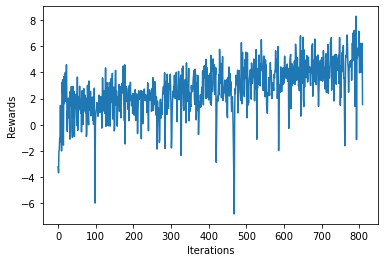

 81%|███████████████████████████████████████████████████████████▏             | 81105/100000 [1:04:29<11:29, 27.39it/s]

Updated Weights
Mean Reward = 2.787000000000002
24


 81%|███████████████████████████████████████████████████████████▎             | 81202/100000 [1:04:33<14:00, 22.36it/s]

Updated Weights
Mean Reward = 2.432000000000002
18


 81%|███████████████████████████████████████████████████████████▎             | 81304/100000 [1:04:37<11:13, 27.75it/s]

Updated Weights
Mean Reward = 6.037000000000001
33


 81%|███████████████████████████████████████████████████████████▍             | 81402/100000 [1:04:40<11:16, 27.51it/s]

Updated Weights
Mean Reward = 4.6770000000000005
34


 81%|███████████████████████████████████████████████████████████▍             | 81498/100000 [1:04:44<10:14, 30.10it/s]

Updated Weights
Mean Reward = 6.27
36


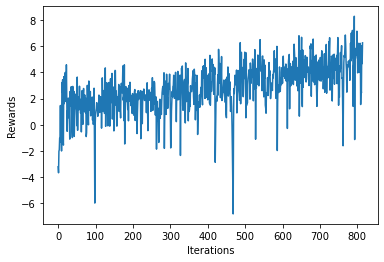

 82%|███████████████████████████████████████████████████████████▌             | 81605/100000 [1:04:47<11:12, 27.35it/s]

Updated Weights
Mean Reward = 6.458000000000002
38


 82%|███████████████████████████████████████████████████████████▋             | 81702/100000 [1:04:51<11:23, 26.77it/s]

Updated Weights
Mean Reward = 3.177000000000001
24


 82%|███████████████████████████████████████████████████████████▋             | 81805/100000 [1:04:55<10:21, 29.26it/s]

Updated Weights
Mean Reward = 4.766000000000002
27


 82%|███████████████████████████████████████████████████████████▊             | 81906/100000 [1:04:59<12:11, 24.72it/s]

Updated Weights
Mean Reward = 5.711000000000001
30


 82%|███████████████████████████████████████████████████████████▊             | 81999/100000 [1:05:02<11:05, 27.05it/s]

Updated Weights
Mean Reward = 6.918000000000003
37


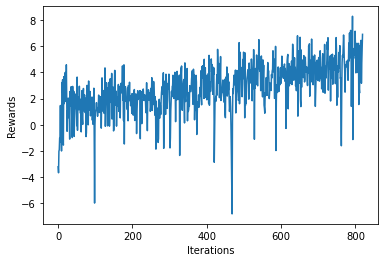

 82%|███████████████████████████████████████████████████████████▉             | 82104/100000 [1:05:06<12:32, 23.77it/s]

Updated Weights
Mean Reward = 6.810000000000002
35


 82%|████████████████████████████████████████████████████████████             | 82204/100000 [1:05:10<12:30, 23.73it/s]

Updated Weights
Mean Reward = 3.9990000000000006
28


 82%|████████████████████████████████████████████████████████████             | 82305/100000 [1:05:14<09:49, 30.01it/s]

Updated Weights
Mean Reward = 5.801000000000001
36


 82%|████████████████████████████████████████████████████████████▏            | 82405/100000 [1:05:18<13:09, 22.29it/s]

Updated Weights
Mean Reward = 4.548000000000002
24


 82%|████████████████████████████████████████████████████████████▏            | 82499/100000 [1:05:21<07:44, 37.71it/s]

Updated Weights
Mean Reward = 7.314000000000002
47


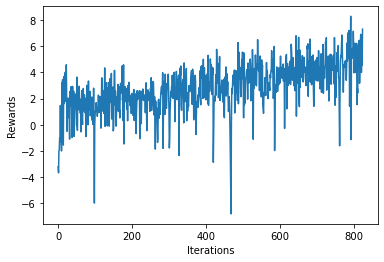

 83%|████████████████████████████████████████████████████████████▎            | 82605/100000 [1:05:25<12:20, 23.48it/s]

Updated Weights
Mean Reward = -2.1449999999999996
16


 83%|████████████████████████████████████████████████████████████▍            | 82708/100000 [1:05:29<08:35, 33.56it/s]

Updated Weights
Mean Reward = 2.483000000000001
23


 83%|████████████████████████████████████████████████████████████▍            | 82802/100000 [1:05:33<10:04, 28.43it/s]

Updated Weights
Mean Reward = 7.504
45


 83%|████████████████████████████████████████████████████████████▌            | 82906/100000 [1:05:37<09:01, 31.57it/s]

Updated Weights
Mean Reward = 5.175000000000001
31


 83%|████████████████████████████████████████████████████████████▌            | 82998/100000 [1:05:40<10:02, 28.24it/s]

Updated Weights
Mean Reward = 6.96
43


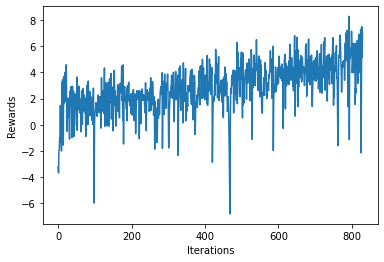

 83%|████████████████████████████████████████████████████████████▋            | 83103/100000 [1:05:44<12:57, 21.74it/s]

Updated Weights
Mean Reward = 5.003000000000001
25


 83%|████████████████████████████████████████████████████████████▋            | 83204/100000 [1:05:49<11:07, 25.16it/s]

Updated Weights
Mean Reward = 5.139000000000003
27


 83%|████████████████████████████████████████████████████████████▊            | 83304/100000 [1:05:53<11:34, 24.04it/s]

Updated Weights
Mean Reward = 4.984000000000002
27


 83%|████████████████████████████████████████████████████████████▉            | 83403/100000 [1:05:56<11:42, 23.63it/s]

Updated Weights
Mean Reward = 5.433000000000002
28


 83%|████████████████████████████████████████████████████████████▉            | 83497/100000 [1:06:00<11:46, 23.35it/s]

Updated Weights
Mean Reward = 3.8800000000000017
21


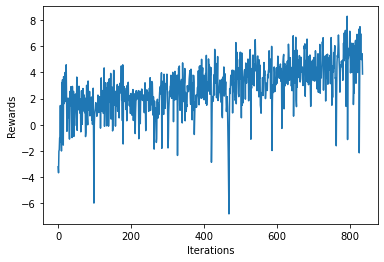

 84%|█████████████████████████████████████████████████████████████            | 83604/100000 [1:06:04<10:53, 25.08it/s]

Updated Weights
Mean Reward = 7.825000000000001
47


 84%|█████████████████████████████████████████████████████████████            | 83704/100000 [1:06:08<11:58, 22.67it/s]

Updated Weights
Mean Reward = 4.341000000000002
21


 84%|█████████████████████████████████████████████████████████████▏           | 83804/100000 [1:06:12<10:37, 25.40it/s]

Updated Weights
Mean Reward = 5.856000000000002
30


 84%|█████████████████████████████████████████████████████████████▎           | 83906/100000 [1:06:15<09:19, 28.79it/s]

Updated Weights
Mean Reward = 5.627000000000001
37


 84%|█████████████████████████████████████████████████████████████▎           | 84000/100000 [1:06:19<10:57, 24.34it/s]

Updated Weights
Mean Reward = 5.086000000000002
26


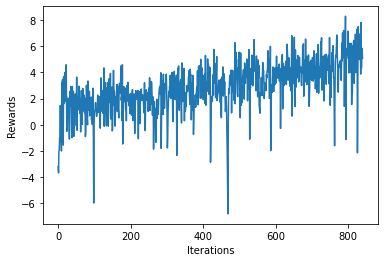

 84%|█████████████████████████████████████████████████████████████▍           | 84104/100000 [1:06:23<10:13, 25.92it/s]

Updated Weights
Mean Reward = 5.203000000000002
29


 84%|█████████████████████████████████████████████████████████████▍           | 84208/100000 [1:06:27<07:49, 33.66it/s]

Updated Weights
Mean Reward = 6.0470000000000015
34


 84%|█████████████████████████████████████████████████████████████▌           | 84306/100000 [1:06:31<09:41, 27.00it/s]

Updated Weights
Mean Reward = 6.637000000000003
38


 84%|█████████████████████████████████████████████████████████████▌           | 84404/100000 [1:06:34<09:50, 26.41it/s]

Updated Weights
Mean Reward = 6.626
34


 84%|█████████████████████████████████████████████████████████████▋           | 84497/100000 [1:06:38<10:35, 24.41it/s]

Updated Weights
Mean Reward = 6.2150000000000025
34


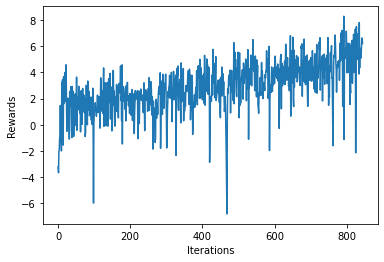

 85%|█████████████████████████████████████████████████████████████▊           | 84603/100000 [1:06:42<07:46, 32.99it/s]

Updated Weights
Mean Reward = 7.205000000000001
41


 85%|█████████████████████████████████████████████████████████████▊           | 84704/100000 [1:06:45<10:04, 25.32it/s]

Updated Weights
Mean Reward = 6.6240000000000006
37


 85%|█████████████████████████████████████████████████████████████▉           | 84806/100000 [1:06:49<09:50, 25.72it/s]

Updated Weights
Mean Reward = 5.6320000000000014
34


 85%|█████████████████████████████████████████████████████████████▉           | 84903/100000 [1:06:52<08:05, 31.07it/s]

Updated Weights
Mean Reward = 7.508000000000001
43


 85%|██████████████████████████████████████████████████████████████           | 84998/100000 [1:06:56<09:38, 25.94it/s]

Updated Weights
Mean Reward = 5.715
33


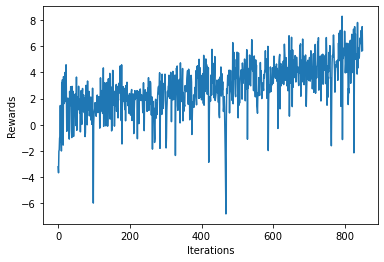

 85%|██████████████████████████████████████████████████████████████▏          | 85103/100000 [1:07:00<09:23, 26.42it/s]

Updated Weights
Mean Reward = 7.292000000000002
41


 85%|██████████████████████████████████████████████████████████████▏          | 85205/100000 [1:07:04<09:59, 24.69it/s]

Updated Weights
Mean Reward = 3.5510000000000015
23


 85%|██████████████████████████████████████████████████████████████▎          | 85309/100000 [1:07:08<07:08, 34.25it/s]

Updated Weights
Mean Reward = 3.709000000000001
22


 85%|██████████████████████████████████████████████████████████████▎          | 85404/100000 [1:07:11<08:36, 28.26it/s]

Updated Weights
Mean Reward = 6.271000000000003
49


 85%|██████████████████████████████████████████████████████████████▍          | 85499/100000 [1:07:15<08:54, 27.15it/s]

Updated Weights
Mean Reward = 6.054000000000001
31


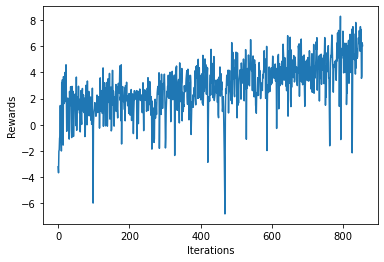

 86%|██████████████████████████████████████████████████████████████▍          | 85604/100000 [1:07:19<09:32, 25.13it/s]

Updated Weights
Mean Reward = 4.833000000000002
26


 86%|██████████████████████████████████████████████████████████████▌          | 85704/100000 [1:07:22<07:02, 33.82it/s]

Updated Weights
Mean Reward = 7.569000000000002
53


 86%|██████████████████████████████████████████████████████████████▋          | 85804/100000 [1:07:26<10:06, 23.41it/s]

Updated Weights
Mean Reward = 4.659000000000001
29


 86%|██████████████████████████████████████████████████████████████▋          | 85903/100000 [1:07:29<09:00, 26.08it/s]

Updated Weights
Mean Reward = 6.558000000000002
40


 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [1:07:33<09:44, 23.94it/s]

Updated Weights
Mean Reward = 3.3420000000000023
23


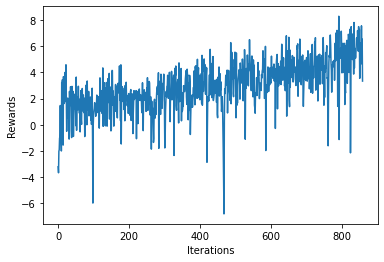

 86%|██████████████████████████████████████████████████████████████▊          | 86106/100000 [1:07:37<08:53, 26.06it/s]

Updated Weights
Mean Reward = 6.296000000000001
35


 86%|██████████████████████████████████████████████████████████████▉          | 86202/100000 [1:07:41<09:46, 23.53it/s]

Updated Weights
Mean Reward = 4.966000000000003
29


 86%|███████████████████████████████████████████████████████████████          | 86302/100000 [1:07:44<09:18, 24.52it/s]

Updated Weights
Mean Reward = 6.292000000000002
32


 86%|███████████████████████████████████████████████████████████████          | 86405/100000 [1:07:48<08:01, 28.22it/s]

Updated Weights
Mean Reward = 6.520000000000002
32


 86%|███████████████████████████████████████████████████████████████▏         | 86500/100000 [1:07:52<08:27, 26.60it/s]

Updated Weights
Mean Reward = 8.324000000000003
45


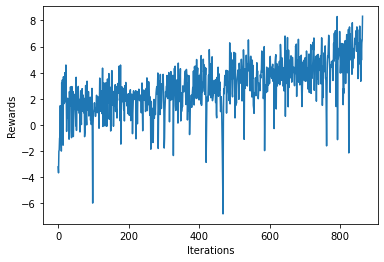

 87%|███████████████████████████████████████████████████████████████▏         | 86605/100000 [1:07:56<08:11, 27.25it/s]

Updated Weights
Mean Reward = 6.656000000000002
36


 87%|███████████████████████████████████████████████████████████████▎         | 86704/100000 [1:07:59<07:52, 28.17it/s]

Updated Weights
Mean Reward = 7.708000000000003
41


 87%|███████████████████████████████████████████████████████████████▎         | 86802/100000 [1:08:03<09:52, 22.27it/s]

Updated Weights
Mean Reward = 5.627000000000002
32


 87%|███████████████████████████████████████████████████████████████▍         | 86903/100000 [1:08:06<07:39, 28.50it/s]

Updated Weights
Mean Reward = 5.705000000000001
40


 87%|███████████████████████████████████████████████████████████████▌         | 87000/100000 [1:08:10<07:52, 27.51it/s]

Updated Weights
Mean Reward = 2.9870000000000023
19


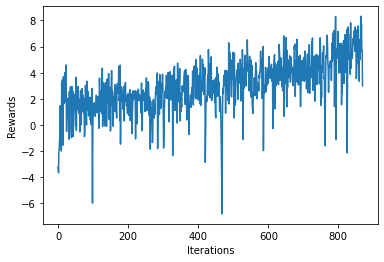

 87%|███████████████████████████████████████████████████████████████▌         | 87105/100000 [1:08:14<08:45, 24.55it/s]

Updated Weights
Mean Reward = 4.912000000000001
32


 87%|███████████████████████████████████████████████████████████████▋         | 87207/100000 [1:08:18<06:51, 31.10it/s]

Updated Weights
Mean Reward = 8.108
48


 87%|███████████████████████████████████████████████████████████████▋         | 87304/100000 [1:08:21<08:46, 24.12it/s]

Updated Weights
Mean Reward = 5.896000000000002
32


 87%|███████████████████████████████████████████████████████████████▊         | 87405/100000 [1:08:25<08:27, 24.83it/s]

Updated Weights
Mean Reward = 5.206000000000001
28


 87%|███████████████████████████████████████████████████████████████▊         | 87498/100000 [1:08:28<07:04, 29.45it/s]

Updated Weights
Mean Reward = 7.738000000000002
47


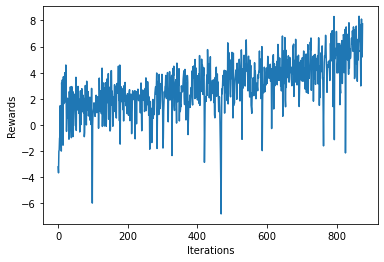

 88%|███████████████████████████████████████████████████████████████▉         | 87607/100000 [1:08:32<06:32, 31.61it/s]

Updated Weights
Mean Reward = 7.303000000000003
39


 88%|████████████████████████████████████████████████████████████████         | 87704/100000 [1:08:36<08:43, 23.50it/s]

Updated Weights
Mean Reward = 5.019000000000002
26


 88%|████████████████████████████████████████████████████████████████         | 87805/100000 [1:08:39<08:12, 24.75it/s]

Updated Weights
Mean Reward = 5.456000000000001
32


 88%|████████████████████████████████████████████████████████████████▏        | 87904/100000 [1:08:44<09:15, 21.76it/s]

Updated Weights
Mean Reward = 3.2530000000000006
32


 88%|████████████████████████████████████████████████████████████████▏        | 87999/100000 [1:08:47<08:09, 24.53it/s]

Updated Weights
Mean Reward = 4.0150000000000015
21


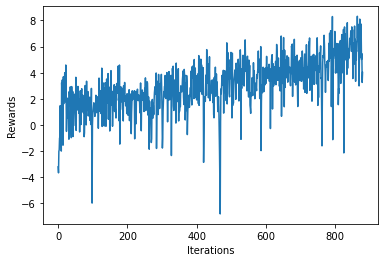

 88%|████████████████████████████████████████████████████████████████▎        | 88103/100000 [1:08:52<10:55, 18.15it/s]

Updated Weights
Mean Reward = 4.254000000000002
17


 88%|████████████████████████████████████████████████████████████████▍        | 88202/100000 [1:08:56<07:29, 26.25it/s]

Updated Weights
Mean Reward = 5.157
38


 88%|████████████████████████████████████████████████████████████████▍        | 88304/100000 [1:09:00<08:01, 24.30it/s]

Updated Weights
Mean Reward = 4.450000000000002
23


 88%|████████████████████████████████████████████████████████████████▌        | 88405/100000 [1:09:04<06:30, 29.67it/s]

Updated Weights
Mean Reward = 8.192000000000002
46


 88%|████████████████████████████████████████████████████████████████▌        | 88500/100000 [1:09:07<07:59, 23.97it/s]

Updated Weights
Mean Reward = 6.589000000000002
33


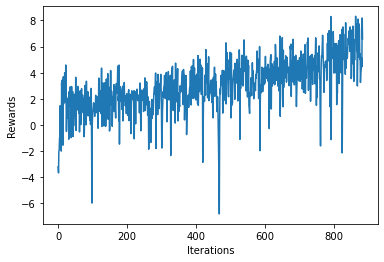

 89%|████████████████████████████████████████████████████████████████▋        | 88603/100000 [1:09:12<07:59, 23.75it/s]

Updated Weights
Mean Reward = 5.693000000000004
29


 89%|████████████████████████████████████████████████████████████████▊        | 88705/100000 [1:09:16<07:46, 24.19it/s]

Updated Weights
Mean Reward = 5.037000000000003
29


 89%|████████████████████████████████████████████████████████████████▊        | 88805/100000 [1:09:20<08:07, 22.94it/s]

Updated Weights
Mean Reward = 7.3480000000000025
41


 89%|████████████████████████████████████████████████████████████████▉        | 88903/100000 [1:09:26<11:00, 16.81it/s]

Updated Weights
Mean Reward = 5.8590000000000035
36


 89%|████████████████████████████████████████████████████████████████▉        | 88999/100000 [1:09:32<10:42, 17.11it/s]

Updated Weights
Mean Reward = 5.604000000000002
27


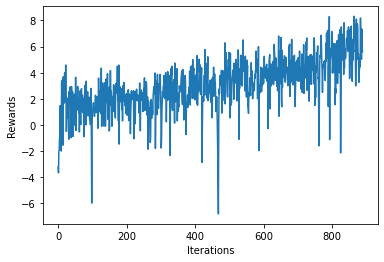

 89%|█████████████████████████████████████████████████████████████████        | 89103/100000 [1:09:38<10:28, 17.33it/s]

Updated Weights
Mean Reward = 3.3240000000000016
33


 89%|█████████████████████████████████████████████████████████████████        | 89203/100000 [1:09:44<12:03, 14.92it/s]

Updated Weights
Mean Reward = 1.6040000000000012
7


 89%|█████████████████████████████████████████████████████████████████▏       | 89303/100000 [1:09:50<10:05, 17.66it/s]

Updated Weights
Mean Reward = 4.085000000000002
24


 89%|█████████████████████████████████████████████████████████████████▎       | 89403/100000 [1:09:56<10:29, 16.84it/s]

Updated Weights
Mean Reward = 5.998000000000002
30


 90%|█████████████████████████████████████████████████████████████████▎       | 89500/100000 [1:10:01<08:56, 19.59it/s]

Updated Weights
Mean Reward = 6.818000000000003
33


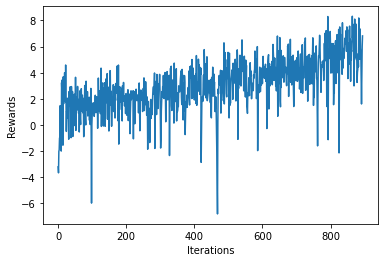

 90%|█████████████████████████████████████████████████████████████████▍       | 89607/100000 [1:10:06<06:57, 24.90it/s]

Updated Weights
Mean Reward = 5.387000000000001
30


 90%|█████████████████████████████████████████████████████████████████▍       | 89703/100000 [1:10:11<09:59, 17.17it/s]

Updated Weights
Mean Reward = 4.789000000000001
37


 90%|█████████████████████████████████████████████████████████████████▌       | 89802/100000 [1:10:16<07:00, 24.26it/s]

Updated Weights
Mean Reward = 4.045000000000002
20


 90%|█████████████████████████████████████████████████████████████████▋       | 89904/100000 [1:10:21<07:42, 21.82it/s]

Updated Weights
Mean Reward = 4.557000000000001
16


 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [1:10:25<08:02, 20.74it/s]

Updated Weights
Mean Reward = 5.179000000000002
26


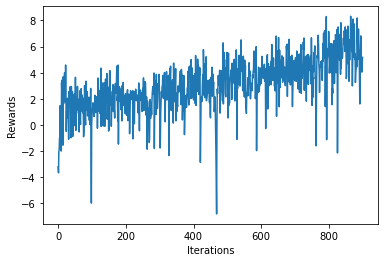

 90%|█████████████████████████████████████████████████████████████████▊       | 90105/100000 [1:10:29<07:28, 22.06it/s]

Updated Weights
Mean Reward = 6.832000000000002
40


 90%|█████████████████████████████████████████████████████████████████▊       | 90204/100000 [1:10:33<07:16, 22.45it/s]

Updated Weights
Mean Reward = 7.295000000000003
40


 90%|█████████████████████████████████████████████████████████████████▉       | 90303/100000 [1:10:38<11:11, 14.45it/s]

Updated Weights
Mean Reward = 6.855000000000003
34


 90%|█████████████████████████████████████████████████████████████████▉       | 90404/100000 [1:10:43<06:24, 24.94it/s]

Updated Weights
Mean Reward = 8.402000000000001
48


 90%|██████████████████████████████████████████████████████████████████       | 90498/100000 [1:10:47<07:14, 21.87it/s]

Updated Weights
Mean Reward = 6.421000000000001
39


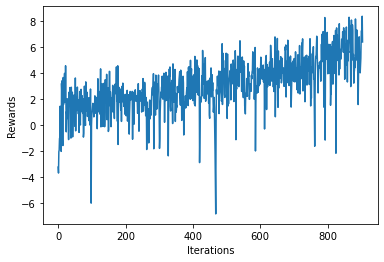

 91%|██████████████████████████████████████████████████████████████████▏      | 90603/100000 [1:10:53<09:53, 15.83it/s]

Updated Weights
Mean Reward = 5.897
31


 91%|██████████████████████████████████████████████████████████████████▏      | 90703/100000 [1:11:01<13:07, 11.81it/s]

Updated Weights
Mean Reward = 2.8750000000000018
20


 91%|██████████████████████████████████████████████████████████████████▎      | 90803/100000 [1:11:09<13:45, 11.14it/s]

Updated Weights
Mean Reward = 0.7630000000000011
9


 91%|██████████████████████████████████████████████████████████████████▎      | 90902/100000 [1:11:16<11:56, 12.70it/s]

Updated Weights
Mean Reward = 4.335000000000003
22


 91%|██████████████████████████████████████████████████████████████████▍      | 91000/100000 [1:11:25<13:42, 10.94it/s]

Updated Weights
Mean Reward = 2.866000000000002
16


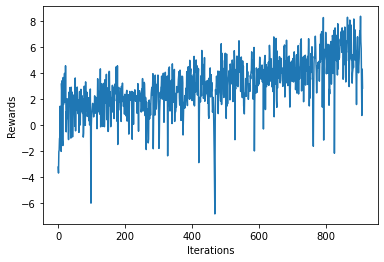

 91%|██████████████████████████████████████████████████████████████████▌      | 91102/100000 [1:11:34<11:02, 13.44it/s]

Updated Weights
Mean Reward = 5.422000000000002
27


 91%|██████████████████████████████████████████████████████████████████▌      | 91202/100000 [1:11:41<10:05, 14.52it/s]

Updated Weights
Mean Reward = 7.571000000000002
39


 91%|██████████████████████████████████████████████████████████████████▋      | 91303/100000 [1:11:49<12:55, 11.22it/s]

Updated Weights
Mean Reward = 3.415000000000001
23


 91%|██████████████████████████████████████████████████████████████████▋      | 91401/100000 [1:11:57<11:12, 12.79it/s]

Updated Weights
Mean Reward = 6.288000000000003
32


 91%|██████████████████████████████████████████████████████████████████▊      | 91499/100000 [1:12:04<11:45, 12.05it/s]

Updated Weights
Mean Reward = 6.532
34


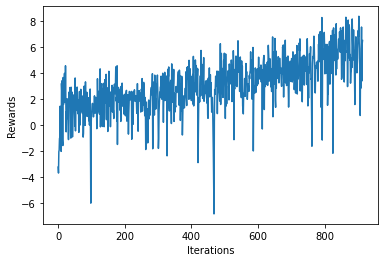

 92%|██████████████████████████████████████████████████████████████████▊      | 91603/100000 [1:12:12<09:46, 14.33it/s]

Updated Weights
Mean Reward = 6.448000000000003
31


 92%|██████████████████████████████████████████████████████████████████▉      | 91705/100000 [1:12:17<06:49, 20.26it/s]

Updated Weights
Mean Reward = 6.230000000000001
32


 92%|███████████████████████████████████████████████████████████████████      | 91803/100000 [1:12:22<06:30, 21.01it/s]

Updated Weights
Mean Reward = 8.252000000000002
44


 92%|███████████████████████████████████████████████████████████████████      | 91904/100000 [1:12:30<09:42, 13.90it/s]

Updated Weights
Mean Reward = 3.8800000000000017
34


 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [1:12:38<10:52, 12.26it/s]

Updated Weights
Mean Reward = 6.801000000000003
33


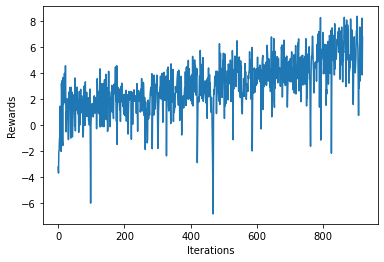

 92%|███████████████████████████████████████████████████████████████████▏     | 92101/100000 [1:12:46<11:10, 11.79it/s]

Updated Weights
Mean Reward = 8.082000000000003
47


 92%|███████████████████████████████████████████████████████████████████▎     | 92202/100000 [1:12:53<09:28, 13.71it/s]

Updated Weights
Mean Reward = 6.262000000000001
35


 92%|███████████████████████████████████████████████████████████████████▍     | 92302/100000 [1:13:01<10:26, 12.28it/s]

Updated Weights
Mean Reward = 6.671
36


 92%|███████████████████████████████████████████████████████████████████▍     | 92402/100000 [1:13:08<08:31, 14.85it/s]

Updated Weights
Mean Reward = 7.2920000000000025
38


 92%|███████████████████████████████████████████████████████████████████▌     | 92499/100000 [1:13:16<11:38, 10.74it/s]

Updated Weights
Mean Reward = 3.8930000000000025
22


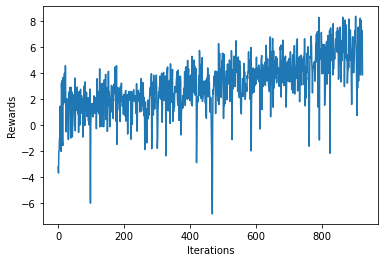

 93%|███████████████████████████████████████████████████████████████████▌     | 92602/100000 [1:13:26<11:01, 11.18it/s]

Updated Weights
Mean Reward = 5.012000000000002
24


 93%|███████████████████████████████████████████████████████████████████▋     | 92704/100000 [1:13:33<08:31, 14.26it/s]

Updated Weights
Mean Reward = 6.958000000000002
38


 93%|███████████████████████████████████████████████████████████████████▋     | 92802/100000 [1:13:41<10:31, 11.40it/s]

Updated Weights
Mean Reward = 4.312000000000001
25


 93%|███████████████████████████████████████████████████████████████████▊     | 92901/100000 [1:13:49<10:05, 11.73it/s]

Updated Weights
Mean Reward = 5.350000000000002
27


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:13:56<06:37, 17.61it/s]

Updated Weights
Mean Reward = 5.814000000000002
29


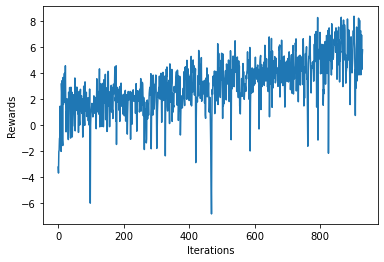

 93%|███████████████████████████████████████████████████████████████████▉     | 93102/100000 [1:14:04<09:47, 11.75it/s]

Updated Weights
Mean Reward = 5.718000000000002
35


 93%|████████████████████████████████████████████████████████████████████     | 93202/100000 [1:14:11<07:01, 16.15it/s]

Updated Weights
Mean Reward = 6.231000000000002
38


 93%|████████████████████████████████████████████████████████████████████     | 93303/100000 [1:14:18<05:31, 20.21it/s]

Updated Weights
Mean Reward = 6.464000000000003
32


 93%|████████████████████████████████████████████████████████████████████▏    | 93403/100000 [1:14:26<09:18, 11.81it/s]

Updated Weights
Mean Reward = 4.654000000000001
28


 94%|████████████████████████████████████████████████████████████████████▎    | 93500/100000 [1:14:33<08:51, 12.23it/s]

Updated Weights
Mean Reward = 7.661000000000001
42


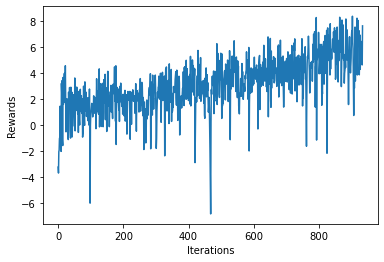

 94%|████████████████████████████████████████████████████████████████████▎    | 93602/100000 [1:14:40<05:08, 20.74it/s]

Updated Weights
Mean Reward = 8.057
44


 94%|████████████████████████████████████████████████████████████████████▍    | 93703/100000 [1:14:48<08:09, 12.87it/s]

Updated Weights
Mean Reward = 1.5640000000000014
29


 94%|████████████████████████████████████████████████████████████████████▍    | 93802/100000 [1:14:56<08:52, 11.65it/s]

Updated Weights
Mean Reward = 2.546000000000001
13


 94%|████████████████████████████████████████████████████████████████████▌    | 93903/100000 [1:15:04<06:54, 14.72it/s]

Updated Weights
Mean Reward = 4.600000000000003
22


 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [1:15:11<07:44, 12.93it/s]

Updated Weights
Mean Reward = 7.931000000000003
46


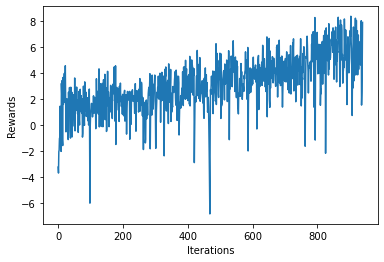

 94%|████████████████████████████████████████████████████████████████████▋    | 94102/100000 [1:15:18<08:04, 12.17it/s]

Updated Weights
Mean Reward = 5.301000000000001
38


 94%|████████████████████████████████████████████████████████████████████▊    | 94203/100000 [1:15:26<07:00, 13.77it/s]

Updated Weights
Mean Reward = 6.5260000000000025
33


 94%|████████████████████████████████████████████████████████████████████▊    | 94303/100000 [1:15:33<06:09, 15.41it/s]

Updated Weights
Mean Reward = 8.345000000000002
45


 94%|████████████████████████████████████████████████████████████████████▉    | 94404/100000 [1:15:39<04:23, 21.22it/s]

Updated Weights
Mean Reward = 8.841000000000003
52


 94%|████████████████████████████████████████████████████████████████████▉    | 94499/100000 [1:15:47<06:30, 14.10it/s]

Updated Weights
Mean Reward = 4.272000000000002
29


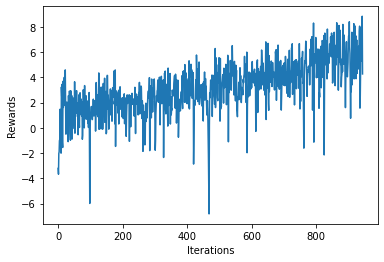

 95%|█████████████████████████████████████████████████████████████████████    | 94601/100000 [1:15:54<05:47, 15.54it/s]

Updated Weights
Mean Reward = 7.949000000000002
45


 95%|█████████████████████████████████████████████████████████████████████▏   | 94702/100000 [1:16:01<07:49, 11.29it/s]

Updated Weights
Mean Reward = 7.164000000000002
39


 95%|█████████████████████████████████████████████████████████████████████▏   | 94803/100000 [1:16:09<05:11, 16.71it/s]

Updated Weights
Mean Reward = 7.574000000000001
44


 95%|█████████████████████████████████████████████████████████████████████▎   | 94903/100000 [1:16:17<07:01, 12.10it/s]

Updated Weights
Mean Reward = 4.600000000000002
20


 95%|█████████████████████████████████████████████████████████████████████▎   | 94997/100000 [1:16:23<06:18, 13.21it/s]

Updated Weights
Mean Reward = 6.472000000000003
36


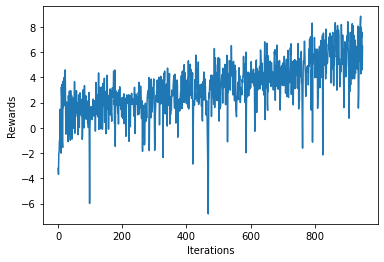

 95%|█████████████████████████████████████████████████████████████████████▍   | 95102/100000 [1:16:31<05:40, 14.38it/s]

Updated Weights
Mean Reward = 7.265000000000002
40


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [1:16:38<06:19, 12.65it/s]

Updated Weights
Mean Reward = 7.838000000000002
40


 95%|█████████████████████████████████████████████████████████████████████▌   | 95304/100000 [1:16:46<05:32, 14.10it/s]

Updated Weights
Mean Reward = 5.856000000000002
30


 95%|█████████████████████████████████████████████████████████████████████▋   | 95402/100000 [1:16:54<06:07, 12.51it/s]

Updated Weights
Mean Reward = 4.465000000000002
24


 95%|█████████████████████████████████████████████████████████████████████▋   | 95499/100000 [1:17:01<06:05, 12.31it/s]

Updated Weights
Mean Reward = 5.586000000000001
28


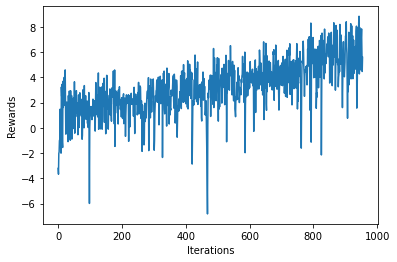

 96%|█████████████████████████████████████████████████████████████████████▊   | 95603/100000 [1:17:08<05:25, 13.50it/s]

Updated Weights
Mean Reward = 6.198000000000002
41


 96%|█████████████████████████████████████████████████████████████████████▊   | 95702/100000 [1:17:17<06:00, 11.91it/s]

Updated Weights
Mean Reward = 4.613000000000002
20


 96%|█████████████████████████████████████████████████████████████████████▉   | 95804/100000 [1:17:24<04:46, 14.63it/s]

Updated Weights
Mean Reward = 7.054000000000002
37


 96%|██████████████████████████████████████████████████████████████████████   | 95903/100000 [1:17:31<04:16, 15.98it/s]

Updated Weights
Mean Reward = 9.165000000000001
51


 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [1:17:39<05:31, 12.08it/s]

Updated Weights
Mean Reward = 3.2630000000000012
26


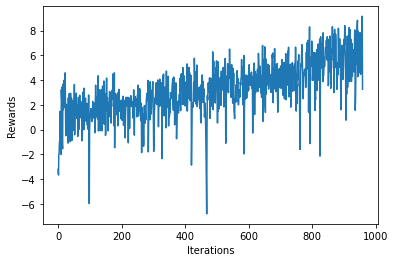

 96%|██████████████████████████████████████████████████████████████████████▏  | 96102/100000 [1:17:47<04:56, 13.15it/s]

Updated Weights
Mean Reward = 7.323000000000003
39


 96%|██████████████████████████████████████████████████████████████████████▏  | 96201/100000 [1:17:53<03:31, 17.99it/s]

Updated Weights
Mean Reward = 7.6030000000000015
47


 96%|██████████████████████████████████████████████████████████████████████▎  | 96302/100000 [1:18:01<05:49, 10.58it/s]

Updated Weights
Mean Reward = 1.4380000000000013
28


 96%|██████████████████████████████████████████████████████████████████████▎  | 96402/100000 [1:18:11<05:11, 11.54it/s]

Updated Weights
Mean Reward = 1.218000000000001
11


 96%|██████████████████████████████████████████████████████████████████████▍  | 96500/100000 [1:18:18<03:44, 15.56it/s]

Updated Weights
Mean Reward = 3.972000000000002
34


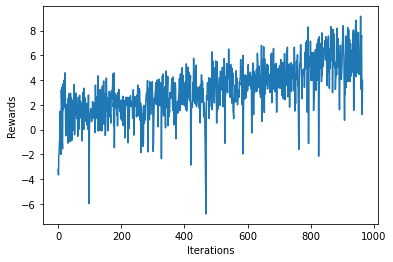

 97%|██████████████████████████████████████████████████████████████████████▌  | 96603/100000 [1:18:26<04:22, 12.96it/s]

Updated Weights
Mean Reward = 6.193000000000001
41


 97%|██████████████████████████████████████████████████████████████████████▌  | 96702/100000 [1:18:33<03:53, 14.15it/s]

Updated Weights
Mean Reward = 7.191000000000002
41


 97%|██████████████████████████████████████████████████████████████████████▋  | 96804/100000 [1:18:39<03:44, 14.24it/s]

Updated Weights
Mean Reward = 8.030000000000003
45


 97%|██████████████████████████████████████████████████████████████████████▋  | 96901/100000 [1:18:48<04:28, 11.54it/s]

Updated Weights
Mean Reward = 1.4590000000000012
23


 97%|██████████████████████████████████████████████████████████████████████▊  | 96999/100000 [1:18:55<03:52, 12.88it/s]

Updated Weights
Mean Reward = 5.089000000000002
25


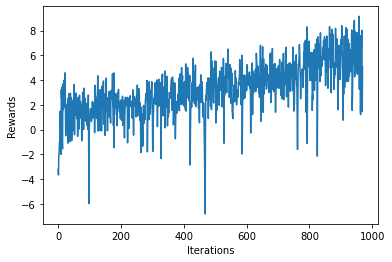

 97%|██████████████████████████████████████████████████████████████████████▉  | 97101/100000 [1:19:04<03:53, 12.42it/s]

Updated Weights
Mean Reward = 6.599000000000002
29


 97%|██████████████████████████████████████████████████████████████████████▉  | 97204/100000 [1:19:11<02:50, 16.39it/s]

Updated Weights
Mean Reward = 6.032000000000003
27


 97%|███████████████████████████████████████████████████████████████████████  | 97303/100000 [1:19:17<03:02, 14.74it/s]

Updated Weights
Mean Reward = 6.684000000000002
35


 97%|███████████████████████████████████████████████████████████████████████  | 97402/100000 [1:19:24<02:55, 14.82it/s]

Updated Weights
Mean Reward = 4.290000000000003
23


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:19:31<02:39, 15.69it/s]

Updated Weights
Mean Reward = 5.734000000000001
36


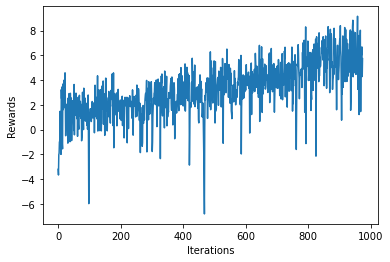

 98%|███████████████████████████████████████████████████████████████████████▎ | 97604/100000 [1:19:38<02:43, 14.66it/s]

Updated Weights
Mean Reward = 5.982000000000002
32


 98%|███████████████████████████████████████████████████████████████████████▎ | 97703/100000 [1:19:45<02:33, 14.93it/s]

Updated Weights
Mean Reward = 6.291
40


 98%|███████████████████████████████████████████████████████████████████████▍ | 97803/100000 [1:19:51<02:15, 16.20it/s]

Updated Weights
Mean Reward = 4.968000000000001
31


 98%|███████████████████████████████████████████████████████████████████████▍ | 97904/100000 [1:19:58<02:21, 14.86it/s]

Updated Weights
Mean Reward = 4.511000000000001
31


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:20:04<02:23, 13.98it/s]

Updated Weights
Mean Reward = 7.409000000000001
48


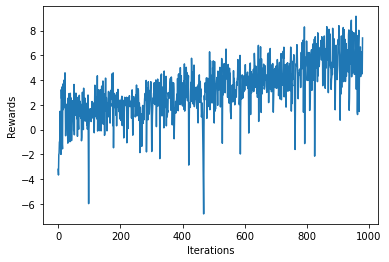

 98%|███████████████████████████████████████████████████████████████████████▌ | 98102/100000 [1:20:11<02:16, 13.93it/s]

Updated Weights
Mean Reward = 4.504000000000001
42


 98%|███████████████████████████████████████████████████████████████████████▋ | 98203/100000 [1:20:18<02:06, 14.21it/s]

Updated Weights
Mean Reward = 5.833000000000002
37


 98%|███████████████████████████████████████████████████████████████████████▊ | 98302/100000 [1:20:24<02:21, 12.02it/s]

Updated Weights
Mean Reward = 6.841000000000003
41


 98%|███████████████████████████████████████████████████████████████████████▊ | 98403/100000 [1:20:31<01:40, 15.95it/s]

Updated Weights
Mean Reward = 4.221000000000001
37


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [1:20:37<01:58, 12.62it/s]

Updated Weights
Mean Reward = 4.565000000000001
33


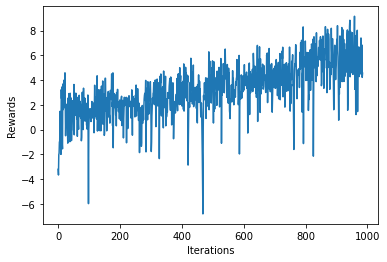

 99%|███████████████████████████████████████████████████████████████████████▉ | 98603/100000 [1:20:44<01:49, 12.75it/s]

Updated Weights
Mean Reward = 6.69
44


 99%|████████████████████████████████████████████████████████████████████████ | 98704/100000 [1:20:52<01:32, 14.07it/s]

Updated Weights
Mean Reward = 4.805000000000002
34


 99%|████████████████████████████████████████████████████████████████████████▏| 98802/100000 [1:20:59<01:26, 13.93it/s]

Updated Weights
Mean Reward = 6.583000000000002
38


 99%|████████████████████████████████████████████████████████████████████████▏| 98903/100000 [1:21:06<01:29, 12.22it/s]

Updated Weights
Mean Reward = 4.980000000000001
35


 99%|████████████████████████████████████████████████████████████████████████▎| 98999/100000 [1:21:13<01:23, 11.94it/s]

Updated Weights
Mean Reward = 6.126000000000001
44


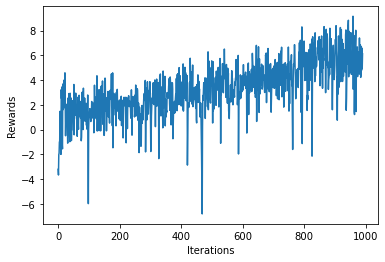

 99%|████████████████████████████████████████████████████████████████████████▎| 99104/100000 [1:21:22<01:00, 14.81it/s]

Updated Weights
Mean Reward = 1.8470000000000022
17


 99%|████████████████████████████████████████████████████████████████████████▍| 99204/100000 [1:21:29<00:51, 15.55it/s]

Updated Weights
Mean Reward = 6.570000000000001
37


 99%|████████████████████████████████████████████████████████████████████████▍| 99303/100000 [1:21:36<00:47, 14.63it/s]

Updated Weights
Mean Reward = 5.381000000000003
27


 99%|████████████████████████████████████████████████████████████████████████▌| 99402/100000 [1:21:43<00:35, 16.86it/s]

Updated Weights
Mean Reward = 5.423000000000001
30


 99%|████████████████████████████████████████████████████████████████████████▋| 99499/100000 [1:21:51<00:43, 11.64it/s]

Updated Weights
Mean Reward = 2.512000000000002
27


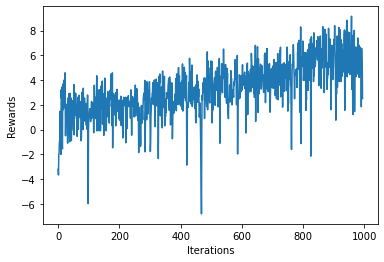

100%|████████████████████████████████████████████████████████████████████████▋| 99602/100000 [1:21:58<00:31, 12.55it/s]

Updated Weights
Mean Reward = 7.014000000000002
37


100%|████████████████████████████████████████████████████████████████████████▊| 99703/100000 [1:22:05<00:23, 12.49it/s]

Updated Weights
Mean Reward = 5.458000000000001
34


100%|████████████████████████████████████████████████████████████████████████▊| 99803/100000 [1:22:13<00:16, 12.18it/s]

Updated Weights
Mean Reward = 5.703000000000003
29


100%|████████████████████████████████████████████████████████████████████████▉| 99903/100000 [1:22:20<00:06, 14.40it/s]

Updated Weights
Mean Reward = 4.9860000000000015
29


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:22:27<00:00, 20.21it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        print('Updated Weights')

       
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [15]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.5, 0.4, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]
[0.5, 0.6, 0.5, 0.9]
[0.5, 0.5, 0.5, 0.9]


In [8]:
print(done)

0


In [9]:
user_agent.model.save_weights('user_agent.h5')